### Project Implementation Introduction

<p>
    Introductory Paragraph
</p>

In [1]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# import kerastunner as kt

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

In [2]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# Implemented model name keys
NBC = "NBC"
SVM = "SVM"
DTC = "DTC"
RFC = "RFC"
ANN = "ANN"

# dataset label keys
kddcup99 = "kddcup99"
unswnb15 = "unswnb15"

# Analysis dataset name dictionary
dataset_label_dict = {
    kddcup99: "KDD CUPP 99",
    unswnb15: "UNSW NB15"
}

# Implemented model name dictionary
model_label_dict = {
    NBC: "NAIVE BAYES CLASSIFIER",
    SVM: "SUPPORT VECTOR MACHINE",
    DTC: "DECISION TREE CLASSIFIER",
    RFC: "RANDOM FOREST CLASSIFIER",
    ANN: "ARTIFICIAL NEURAL NETWORK",
}

# Evaluation Metrics labels
AUC = "AUC"
GMEAN = "G-MEAN"

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"


### Implemented Objects Declaration

In [3]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

In [4]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [5]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [6]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [7]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [8]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [9]:
# This function is used to retrieve the features names of column whose datatype is of the float64 datatype

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [10]:
# This function is used to show bar charts for all categorical variables. The function also show the summary for the count of 
# the different unique values in the varaible

def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print()
    print()
    print()
    for ax, feature in zip(axes, feature_column_list):
        print("Summary for {} feature value counts".format(feature.upper()))
        print()
        print(df[feature].value_counts())
        print()
        print()
        print()
        title = "This is title for {} bar chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="bar")
        ax.set(title=title)
        
    plt.show()    
    

In [11]:
# This function is used to show histogram chart for all continuous variables.

def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [12]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print()
    print()
    print()
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print()
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print()
        print()
        
    return df


In [13]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [14]:
# This function is used to perform model analysis for the Naive Bayes supervised learning algorithm for experiment one.
# The function create an instance of the GaussianNB module and proceed to call the perform_model_analysis function to 
# train and make prediction using Naive Bayes model.

def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        model = GaussianNB()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [15]:
# This function is used to perform model analysis for the Support Vector Machine (SVM) supervised learning algorithm 
# for experiment one. The function create an instance of the SVC module and proceed to call the perform_model_analysis  
# function to train and make prediction using SVM model.

def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        model = svm.SVC(gamma = 'scale')
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [16]:
# This function is used to perform model analysis for the Decision Tree supervised learning algorithm 
# for experiment one. The function create an instance of the DecisionTreeClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Decision Tree model.

def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [17]:
# This function is used to perform model analysis for the Random Forest supervised learning algorithm 
# for experiment one. The function create an instance of the RandomForestClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Random Forest model.

def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        model = RandomForestClassifier(n_estimators=30)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [72]:
# This function is used to perform model analysis for the Artificial Neural Network (ANN) which is a deep learning 
# algorithm for experiment one. The function create an instance of the ArtificailNeuralNetworkClassifier that we created and proceed  
# to call the perform_model_analysis function to train and make prediction using ANN model.


def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', ['accuracy'])
        model = ann.get_model()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [19]:
# This function is use to perform model analysis and show summary for the model analysis and the function is invoked by all
# model analysing function created above. This function help to train the model by calling the fit method on the model 
# instance, then use the trained model to make predictions which is then used to analyse and display the summary of the
# model performance

def perform_model_analysis(model, analysis_df_dict, dataset_key, model_name):
    
    model.fit(analysis_df_dict[dataset_key][x_train_key], analysis_df_dict[dataset_key][y_train_key].values.ravel())
        
        
    model_preditions = model.predict(analysis_df_dict[dataset_key][x_test_key])
    
    print()
    print()
    print("ANALYSIS SUMMARY FOR {} MODEL FOR {} DATASET".format(model_label_dict[model_name], dataset_label_dict[dataset_key]))
    print()
    print()
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print()
    print(classification_report(model_preditions, analysis_df_dict[dataset_key][y_test_key], target_names=["Normal", "Attack"]))
    
    
    print()
    print()
    print()
    print("CONFUSION MATRIX")
    print("=========================================================")
    print()
    conf_mat = confusion_matrix(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print()
    print()
    print()
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print()
    auc_score = roc_auc_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    
    result = {
        AUC: auc_score,
        GMEAN: gmean_score
    }
    
    return result
    

#### Import Dataset into IDE

In [20]:
dataset_directory_path = "/data/project/"
kdd_cup_filename = "kddcup.data.corrected"

unsw_nb15_filename1 = "UNSW_NB15_training-set.csv"
unsw_nb15_filename2 = "UNSW_NB15_testing-set.csv"


kdd_cup_df = None
unsw_nb15_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + kdd_cup_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    unsw_nb15_df1 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename1)
    unsw_nb15_df2 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename2)
    
    unsw_nb15_df = pd.concat([unsw_nb15_df1, unsw_nb15_df2], ignore_index=True)
    unsw_nb15_df.rename(columns={"label": target_variable}, inplace = True)
    
    kdd_cup_df = kdd_cup_df.sample(n=50000)
    unsw_nb15_df = unsw_nb15_df.sample(n=50000)
except NameError:
    kdd_cup_df = None
    unsw_nb15_df = None
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()

#### Preprocesing and Dataset Cleaning

In [21]:
kdd_cup_df.head(100)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,traffic_type
1704492,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4203393,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4178178,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
1376154,0,tcp,http,SF,147,10388,0,0,0,0,...,255,1.00,0.00,0.03,0.08,0.0,0.01,0.00,0.01,normal.
2755980,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4443591,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
996154,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4334358,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4272031,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4774770,7,udp,private,SF,105,147,0,0,0,0,...,240,0.94,0.01,0.01,0.00,0.0,0.00,0.00,0.00,normal.


In [22]:
unsw_nb15_df.head(100)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,traffic_type
59545,59546,0.000010,udp,dns,INT,2,0,114,0,1.000000e+05,...,3,7,0,0,0,7,10,0,Generic,1
2414,2415,0.179562,tcp,-,FIN,10,6,2416,268,8.353660e+01,...,1,1,0,0,1,1,1,0,Exploits,1
192911,110580,0.000000,arp,-,INT,1,0,46,0,0.000000e+00,...,1,1,0,0,0,1,1,1,Normal,0
140477,58146,0.883534,tcp,smtp,FIN,50,24,41225,1950,8.262274e+01,...,1,2,0,0,0,1,2,0,Exploits,1
243867,161536,0.000009,udp,dns,INT,2,0,114,0,1.111111e+05,...,16,33,0,0,0,34,33,0,Generic,1
94147,11816,1.276661,tcp,-,FIN,122,126,7814,16912,1.934734e+02,...,1,1,0,0,0,8,4,0,Normal,0
218099,135768,0.000005,udp,dns,INT,2,0,114,0,2.000000e+05,...,17,33,0,0,0,34,33,0,Generic,1
212859,130528,0.000003,udp,dns,INT,2,0,114,0,3.333333e+05,...,6,7,0,0,0,6,6,0,Generic,1
102493,20162,1.299210,tcp,http,FIN,14,18,1684,10168,2.386066e+01,...,1,3,0,0,1,1,2,0,Normal,0
175964,93633,1.150245,tcp,ftp-data,FIN,8,8,364,682,1.304070e+01,...,1,2,0,0,0,2,1,0,Exploits,1


In [23]:
kdd_cup_df.shape

(50000, 42)

In [24]:
unsw_nb15_df.shape

(50000, 45)

In [25]:
kdd_cup_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [26]:
unsw_nb15_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [27]:
kdd_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1704492 to 157895
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     50000 non-null  int64  
 1   protocol_type                50000 non-null  object 
 2   service                      50000 non-null  object 
 3   flag                         50000 non-null  object 
 4   src_bytes                    50000 non-null  int64  
 5   dst_bytes                    50000 non-null  int64  
 6   land                         50000 non-null  int64  
 7   wrong_fragment               50000 non-null  int64  
 8   urgent                       50000 non-null  int64  
 9   hot                          50000 non-null  int64  
 10  num_failed_logins            50000 non-null  int64  
 11  logged_in                    50000 non-null  int64  
 12  num_compromised              50000 non-null  int64  
 13  root_shel

In [28]:
unsw_nb15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 59545 to 191650
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 50000 non-null  int64  
 1   dur                50000 non-null  float64
 2   proto              50000 non-null  object 
 3   service            50000 non-null  object 
 4   state              50000 non-null  object 
 5   spkts              50000 non-null  int64  
 6   dpkts              50000 non-null  int64  
 7   sbytes             50000 non-null  int64  
 8   dbytes             50000 non-null  int64  
 9   rate               50000 non-null  float64
 10  sttl               50000 non-null  int64  
 11  dttl               50000 non-null  int64  
 12  sload              50000 non-null  float64
 13  dload              50000 non-null  float64
 14  sloss              50000 non-null  int64  
 15  dloss              50000 non-null  int64  
 16  sinpkt           

In [29]:
# kdd_cup_df = kdd_cup_df.drop(['num_outbound_cmds'], axis=1)
unsw_nb15_df = unsw_nb15_df.drop(['attack_cat'], axis=1)

In [30]:
kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))

#### Exploratory Data Analysis (EDA)

In [31]:
eda_kdd_cup_df = kdd_cup_df
eda_unsw_nb15_df = unsw_nb15_df

eda_kdd_cup_df[target_variable] = eda_kdd_cup_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)

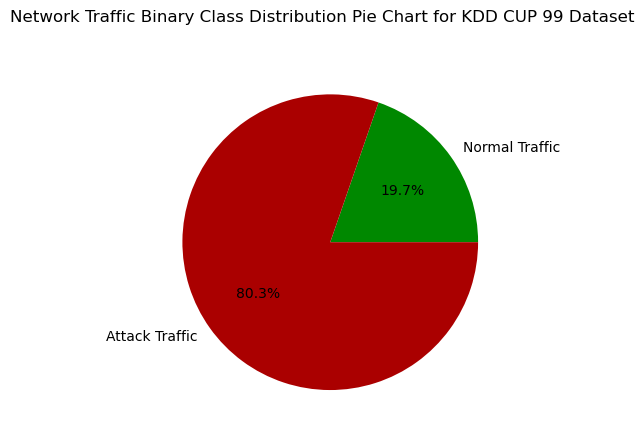

In [32]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_kdd_cup_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for KDD CUP 99 Dataset')

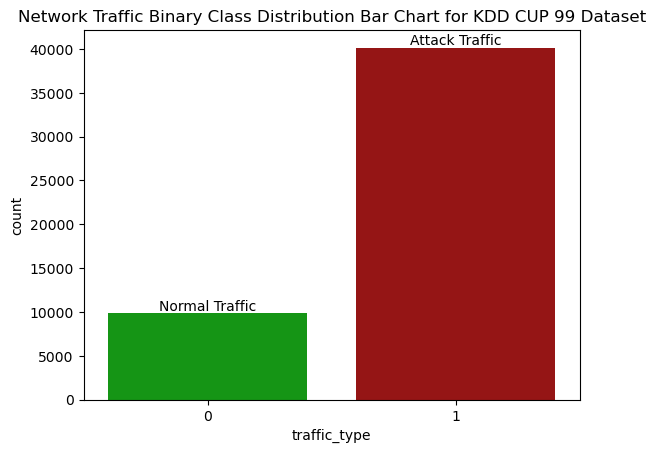

In [33]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_kdd_cup_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart for KDD CUP 99 Dataset')

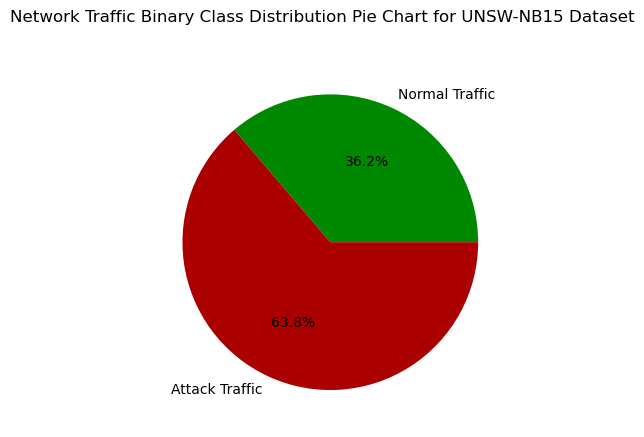

In [34]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_unsw_nb15_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for UNSW-NB15 Dataset')

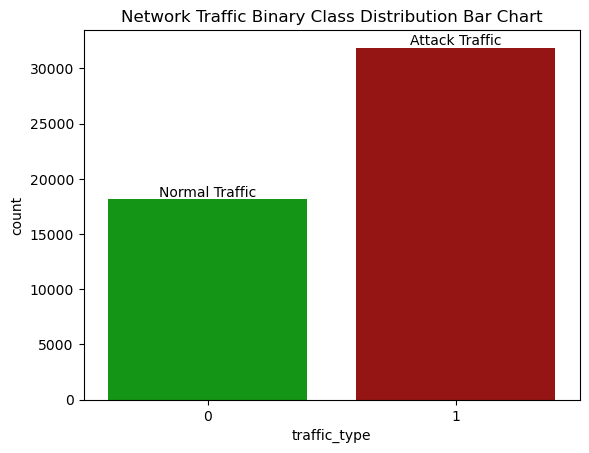

In [35]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_unsw_nb15_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [36]:
eda_kdd_cup_df = eda_kdd_cup_df.drop([target_variable], axis=1)
eda_unsw_nb15_df = eda_unsw_nb15_df.drop([target_variable], axis=1)

In [37]:
eda_kdd_cup_99_categorical_features, eda_kdd_cup_99_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_kdd_cup_df)

In [38]:
eda_unsw_nb15_categorical_features, eda_unsw_nb15_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_unsw_nb15_df)




Summary for SERVICE feature value counts

ecr_i          28832
private        11220
http            6255
smtp             988
other            770
domain_u         594
ftp_data         419
eco_i            162
finger            63
ftp               63
urp_i             51
ntp_u             40
telnet            30
auth              29
pop_3             23
vmnet             17
time              16
netstat           15
uucp              15
printer           15
netbios_dgm       15
sql_net           14
ctf               14
link              13
rje               13
imap4             13
supdup            13
shell             13
ssh               13
netbios_ssn       13
name              12
daytime           12
efs               11
whois             11
sunrpc            11
klogin            10
http_443          10
echo              10
uucp_path          9
remote_job         9
login              9
csnet_ns           9
mtp                9
iso_tsap           9
bgp                9
pop_2     

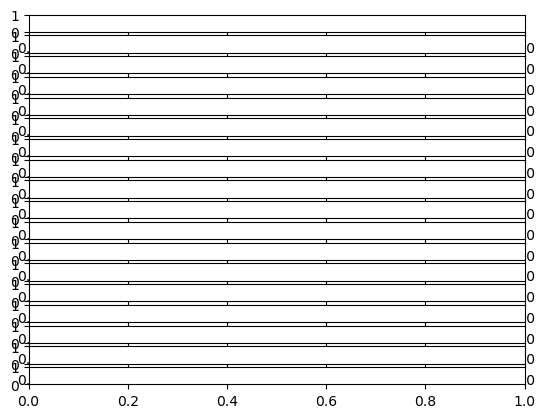

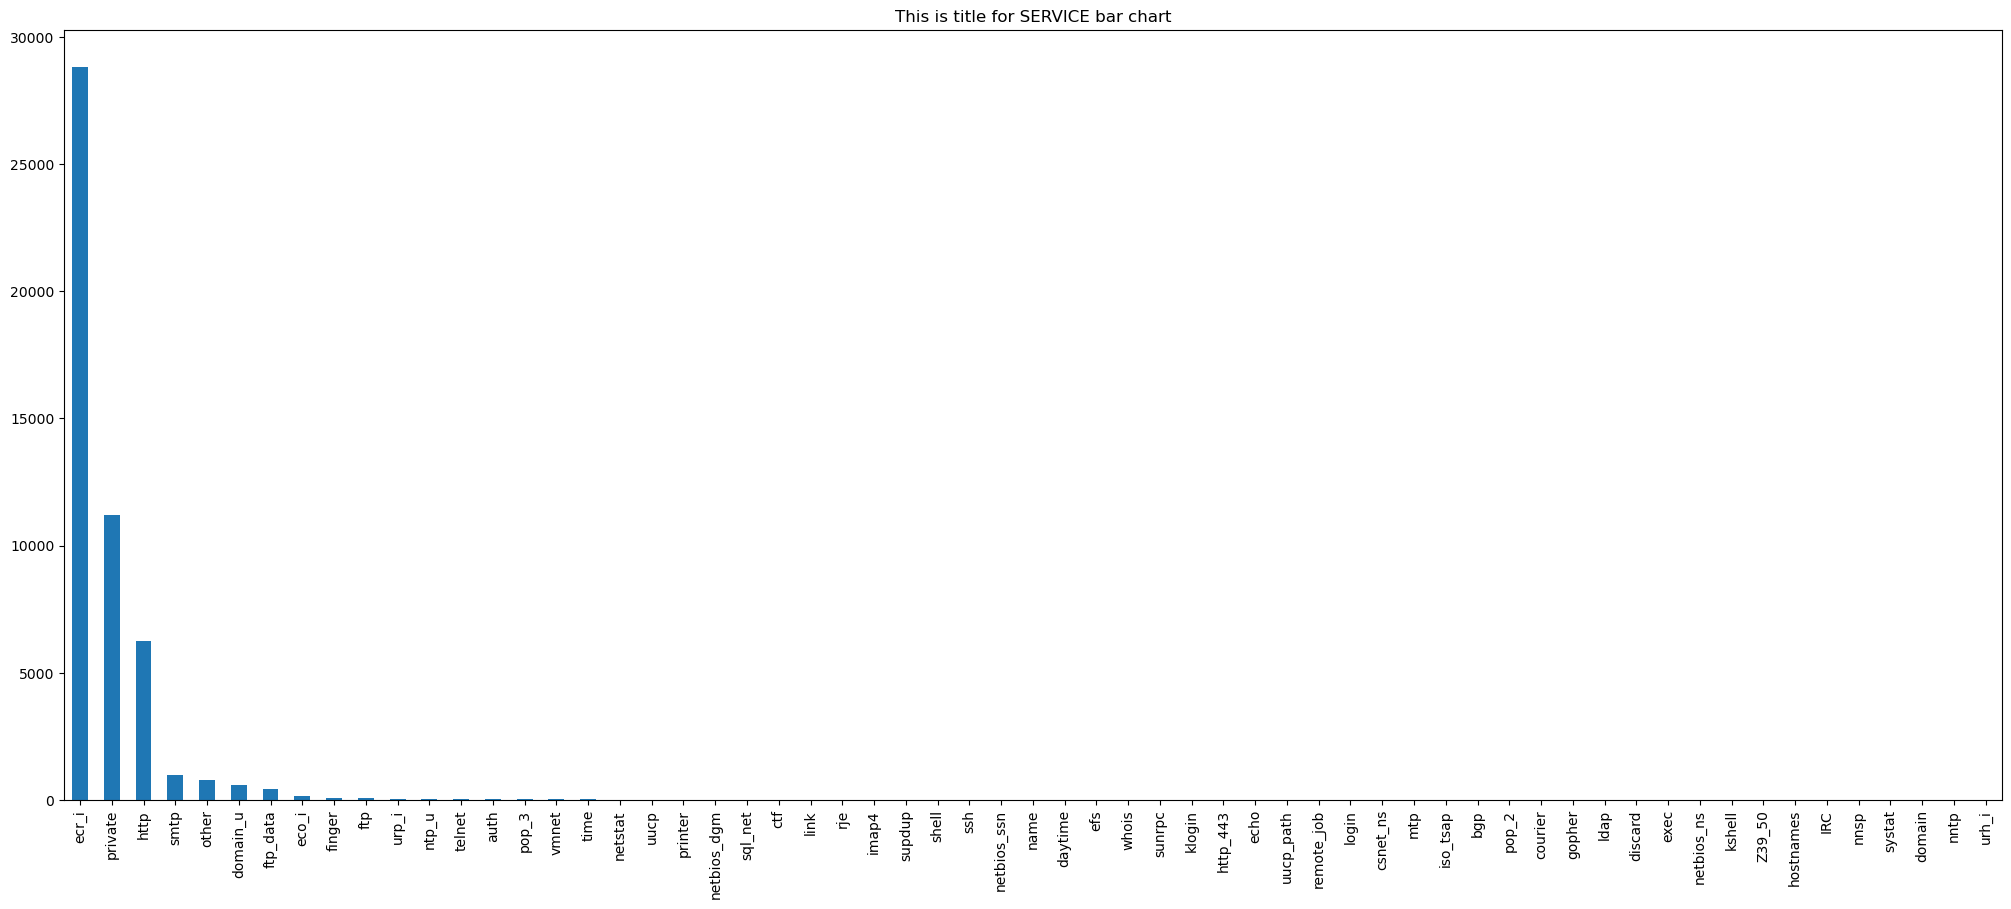

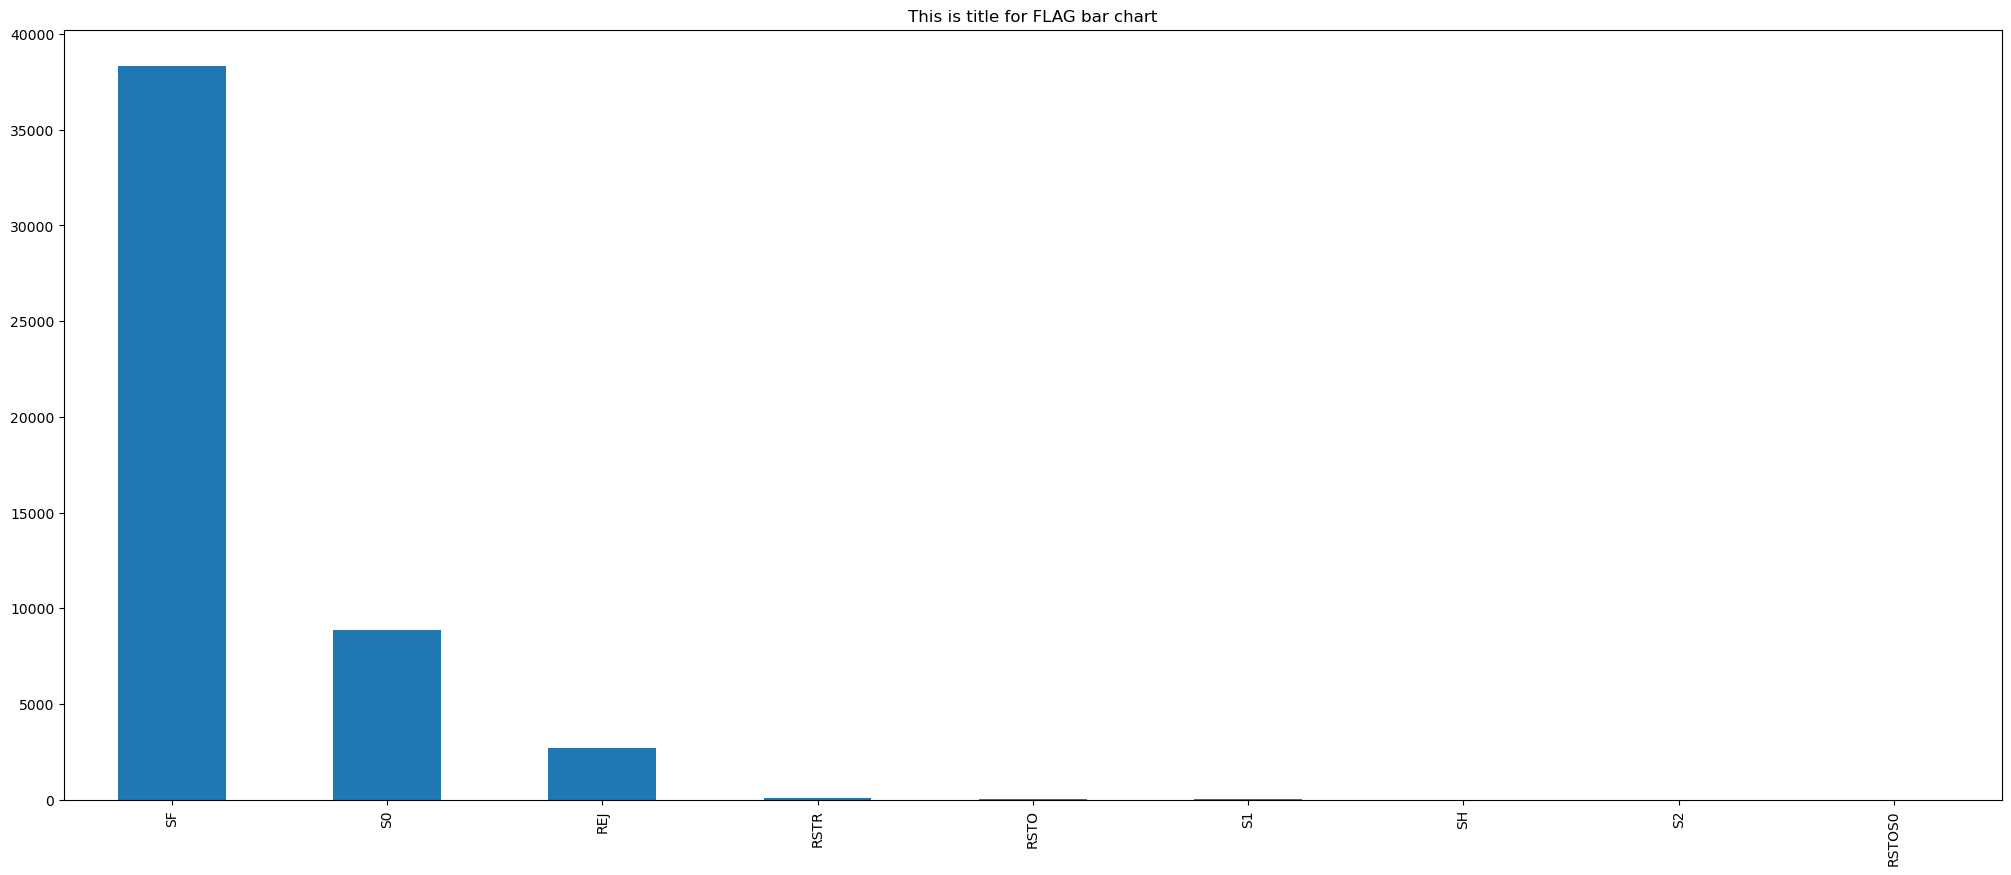

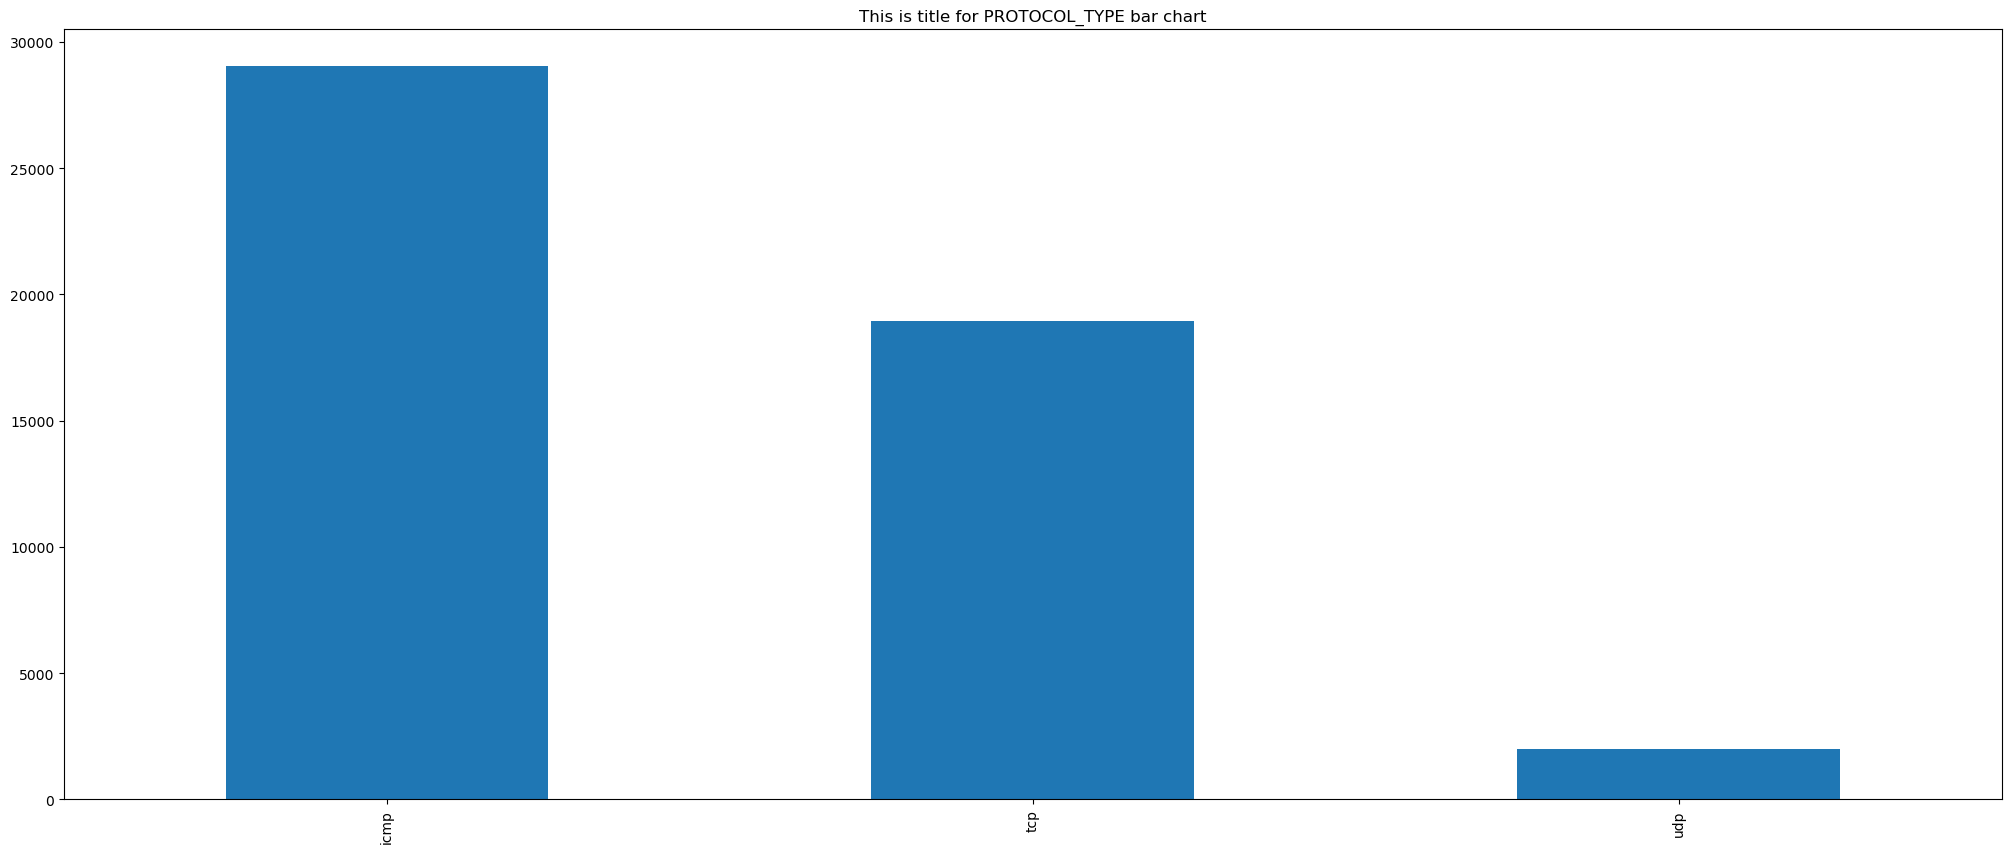

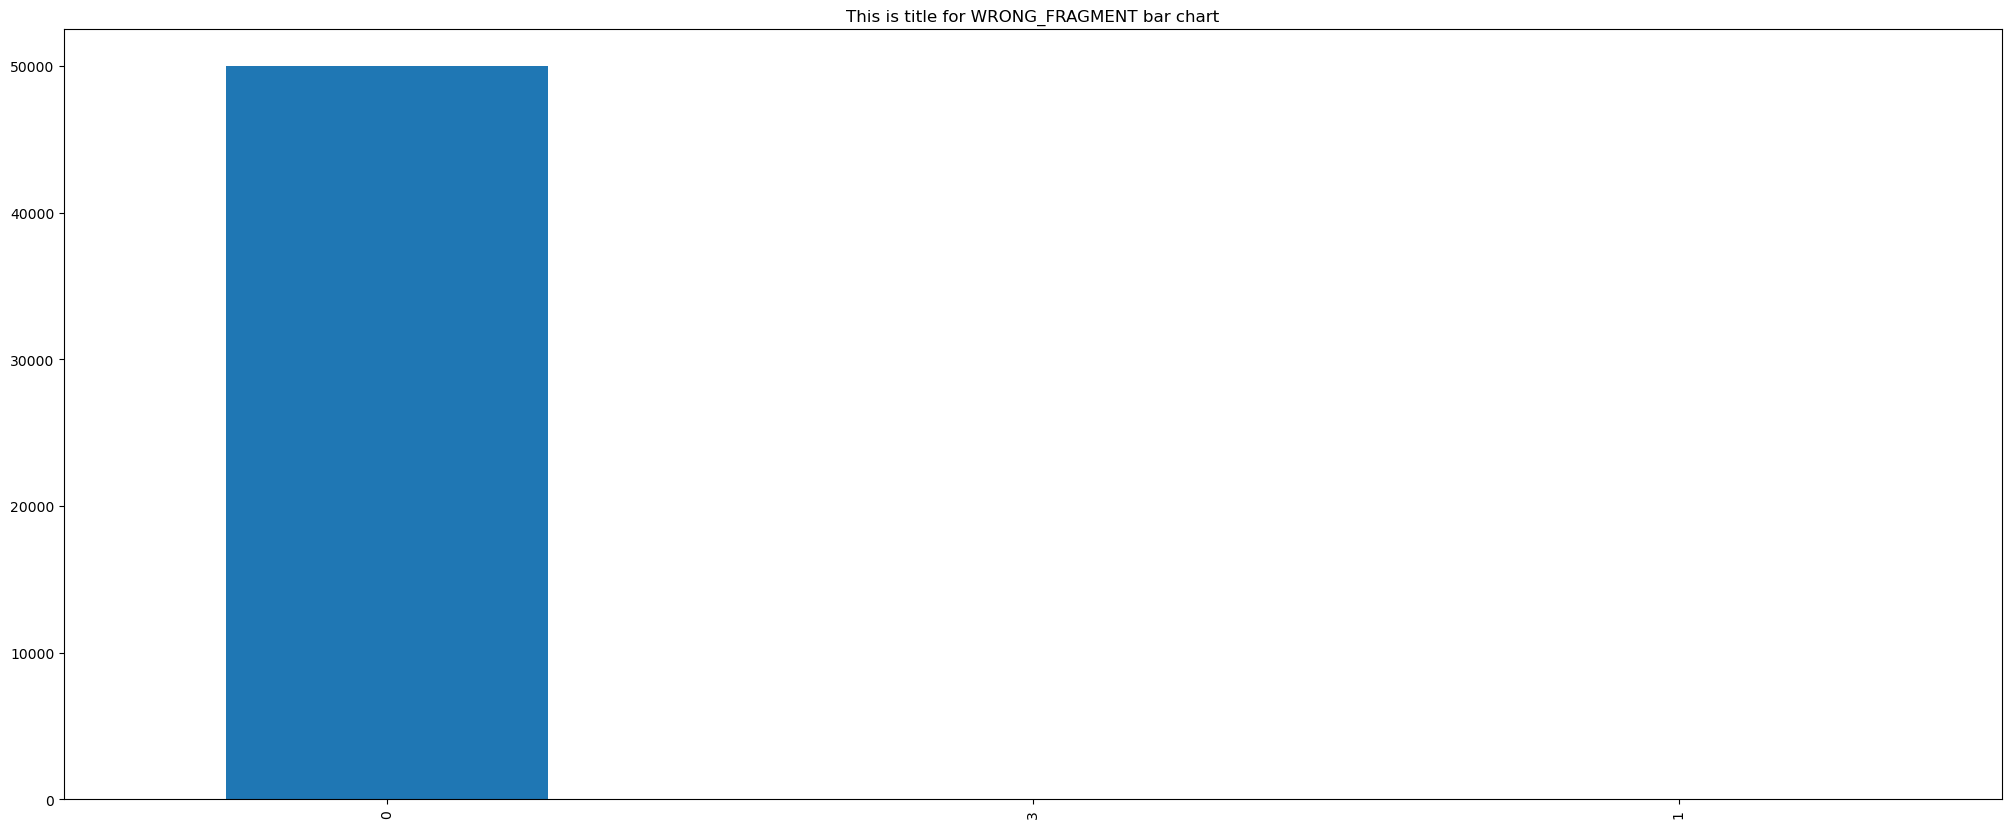

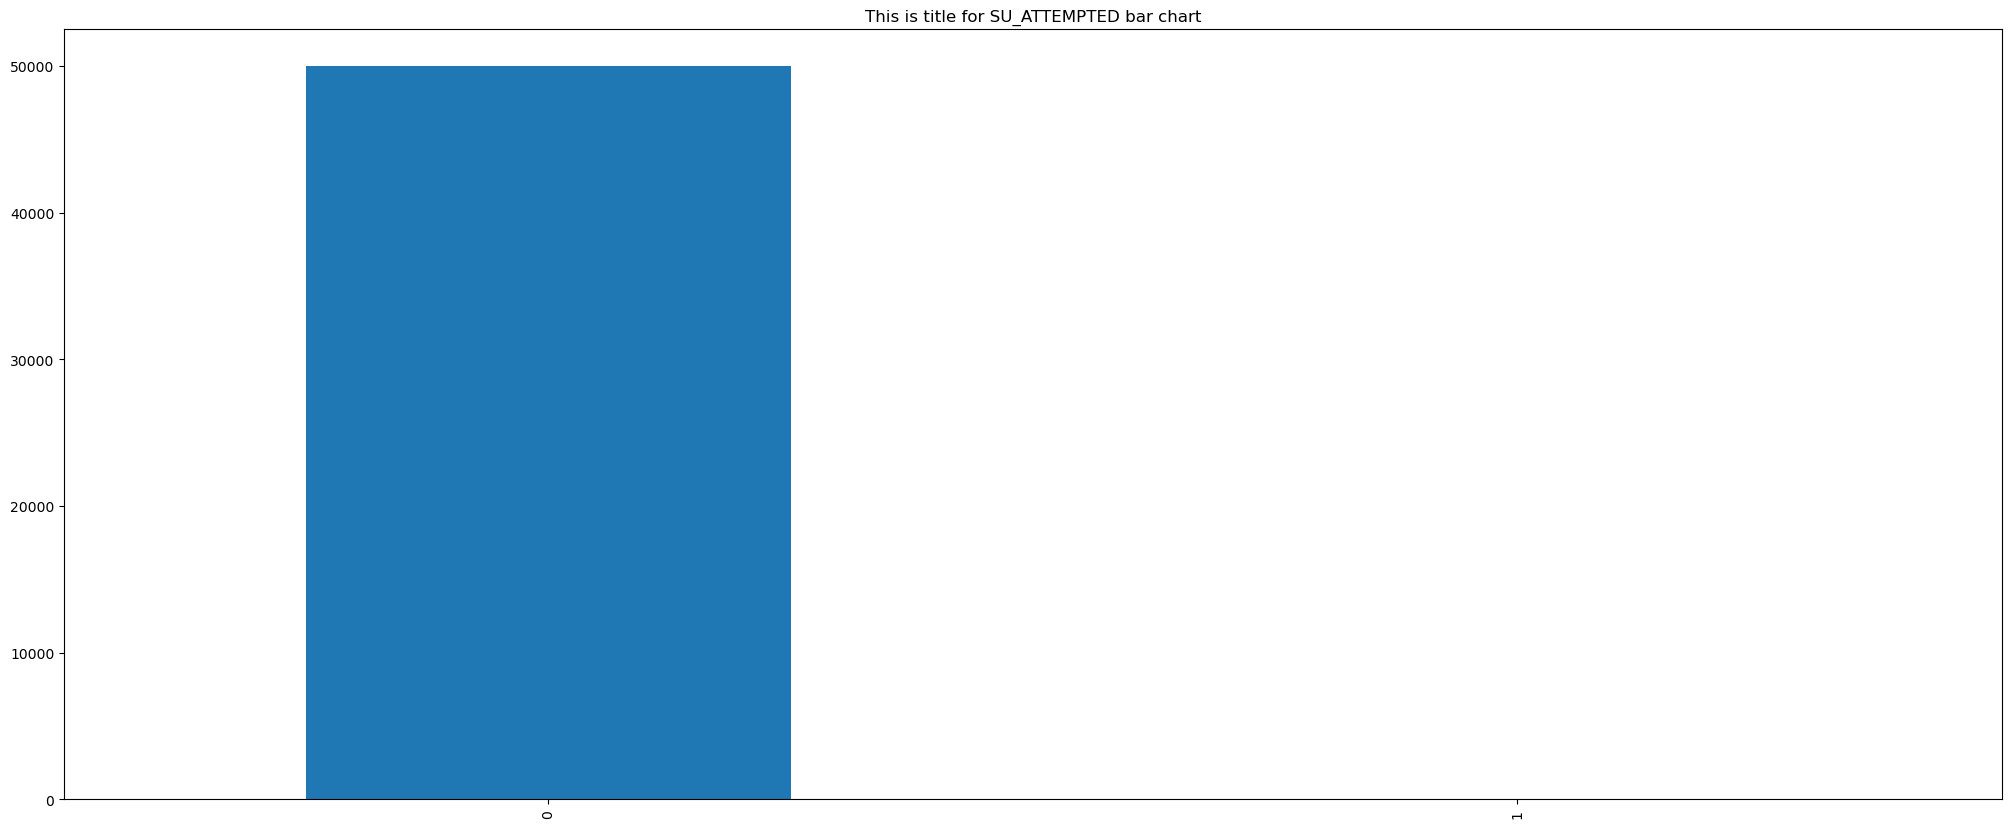

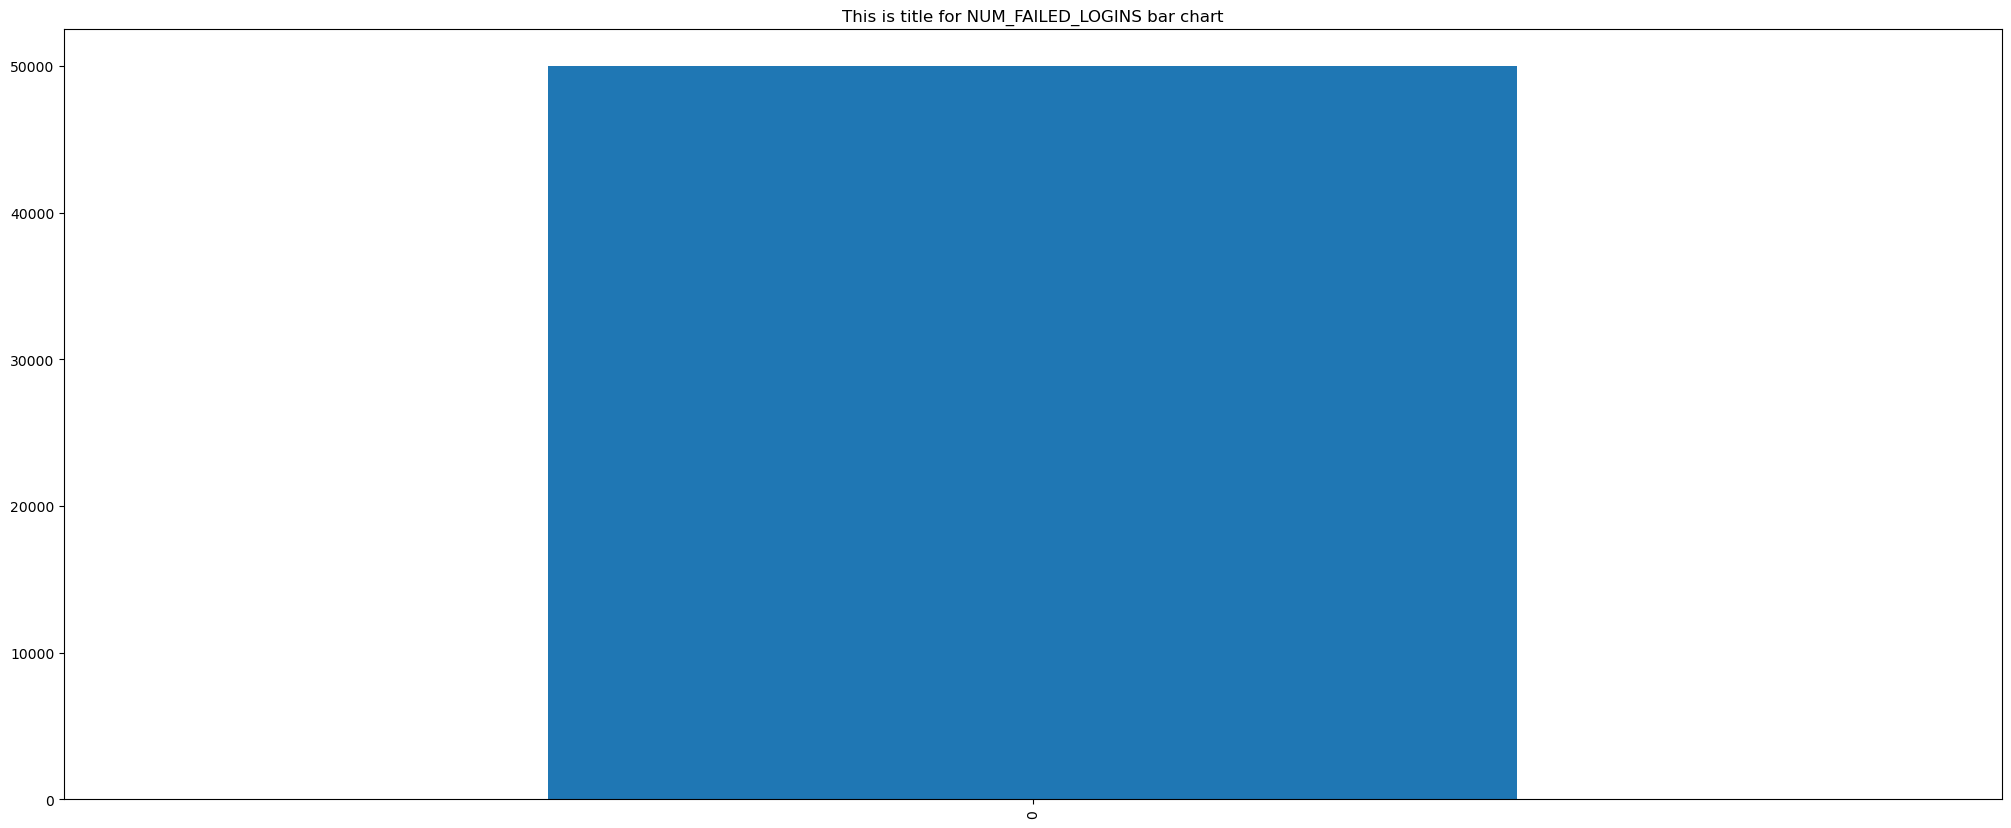

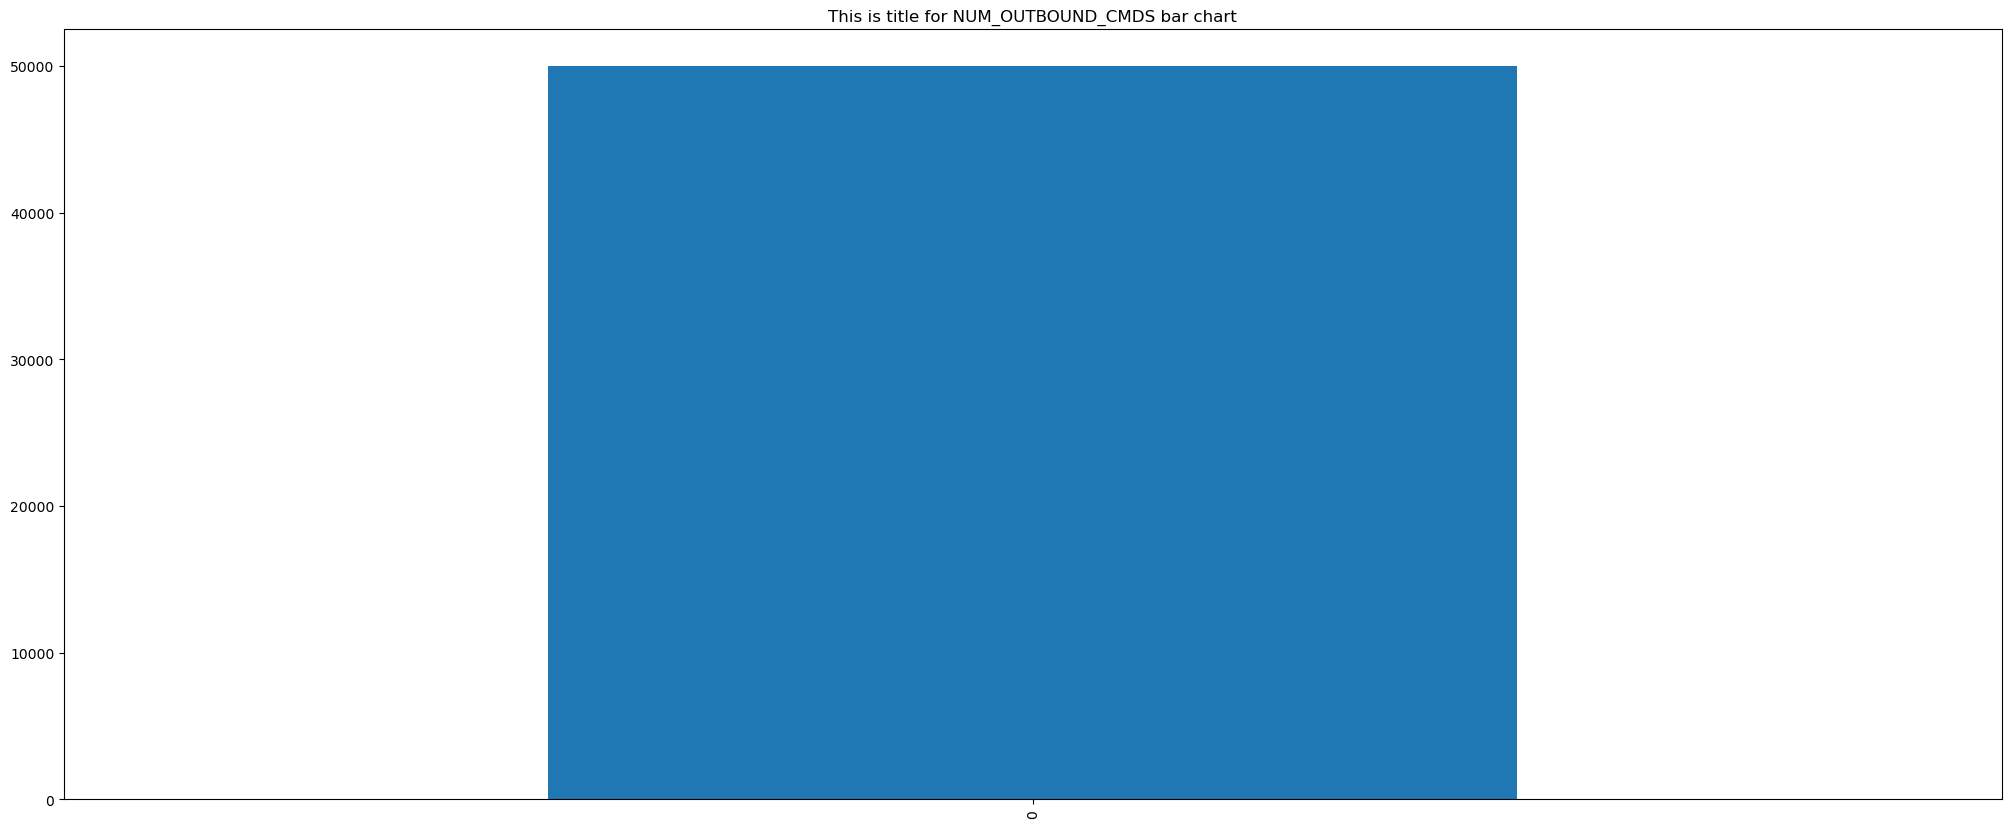

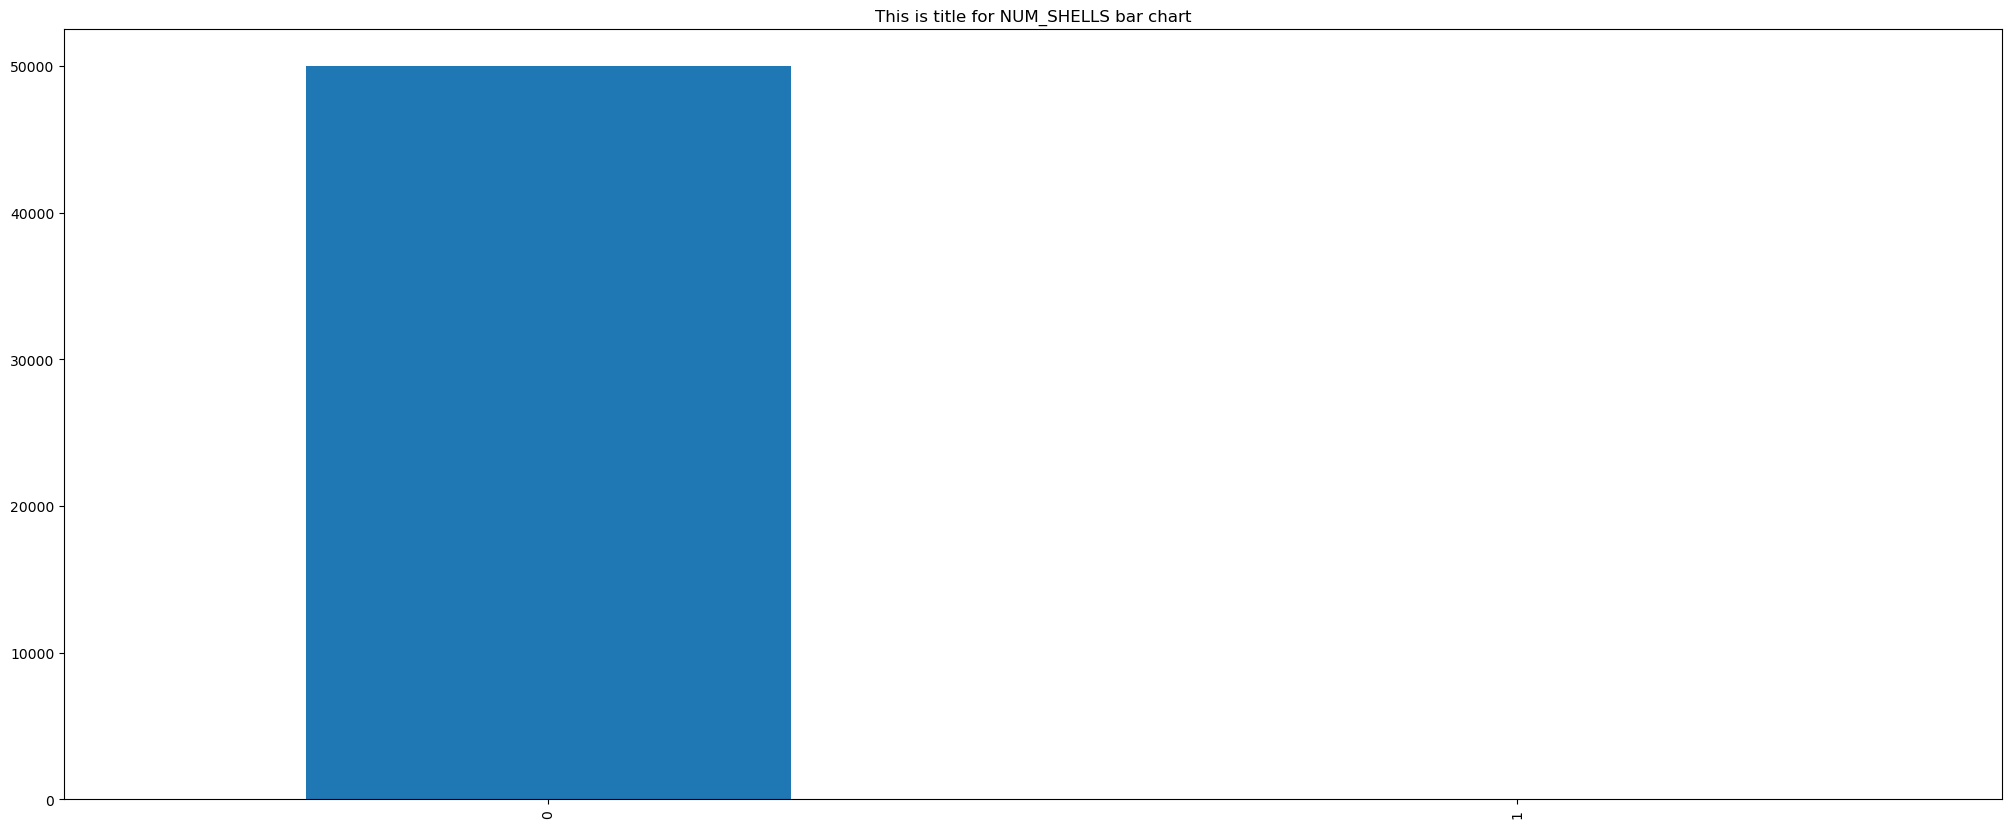

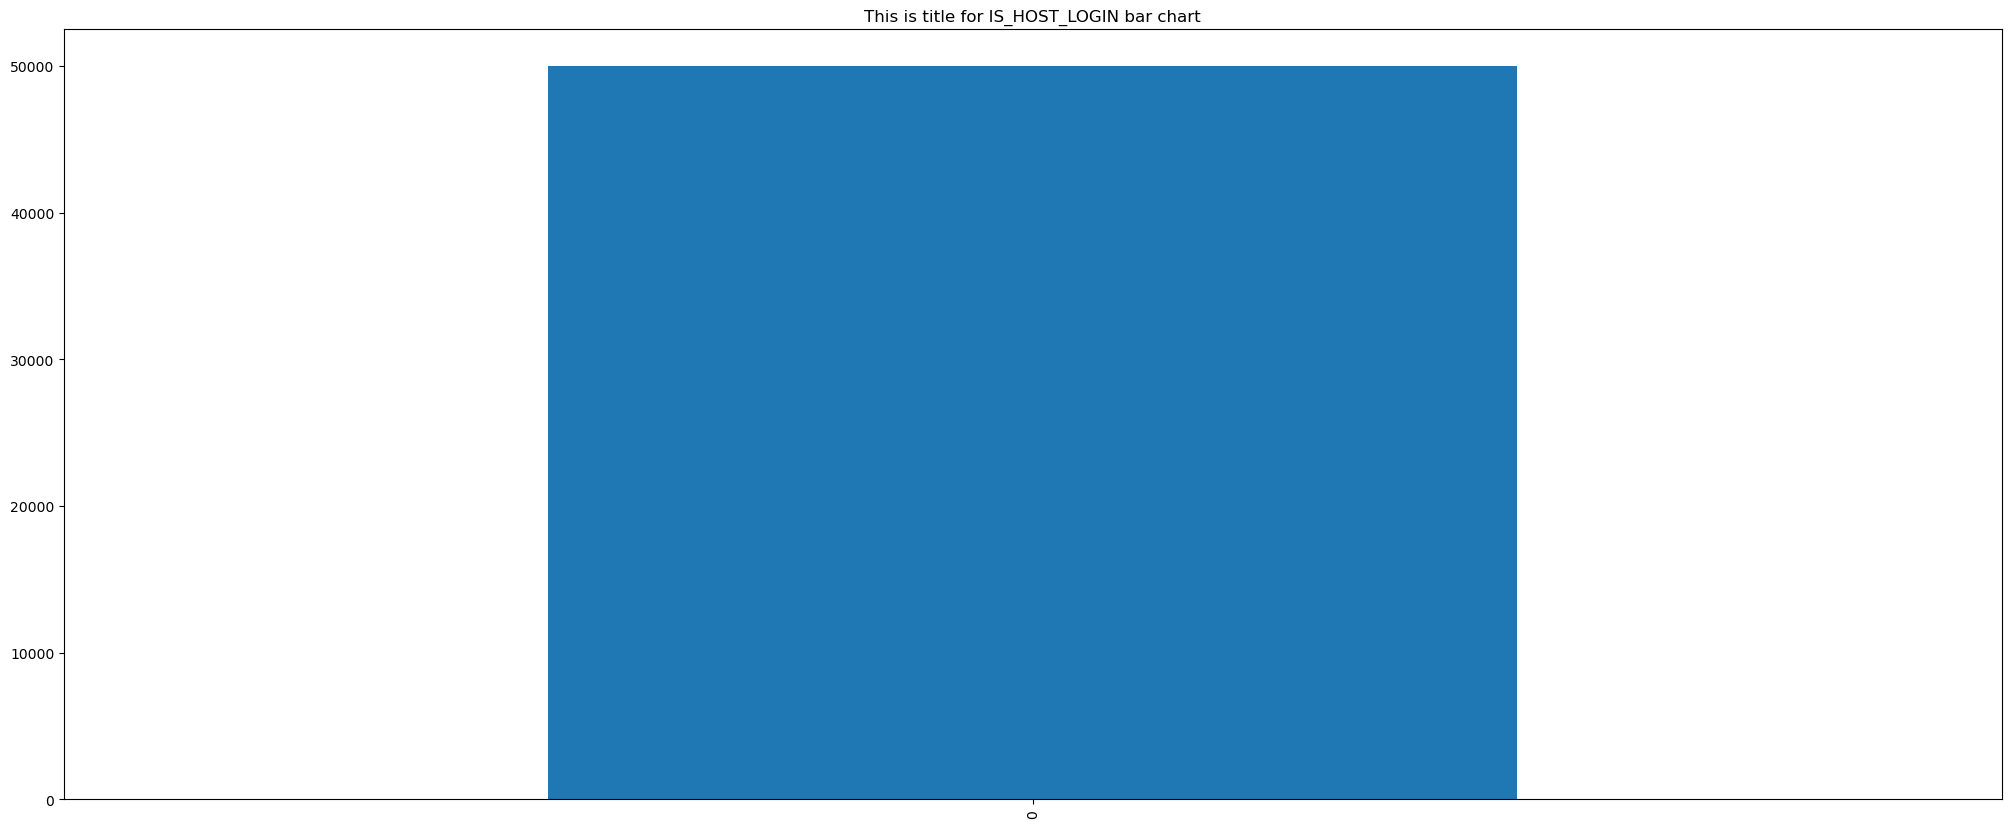

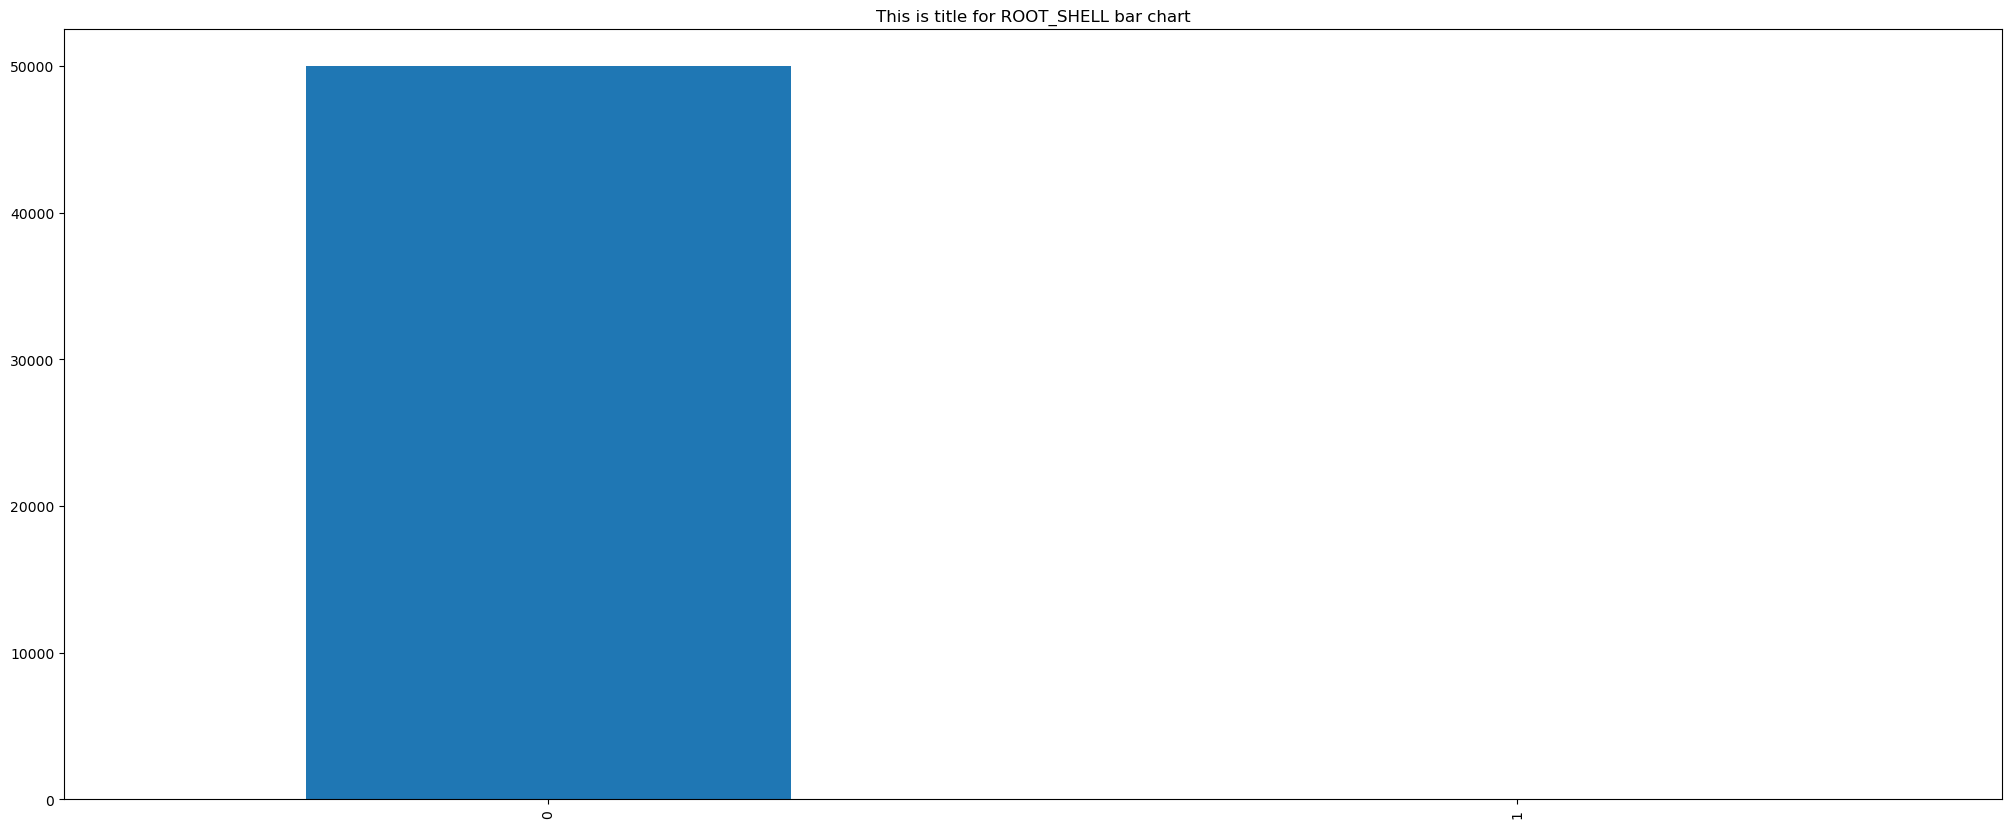

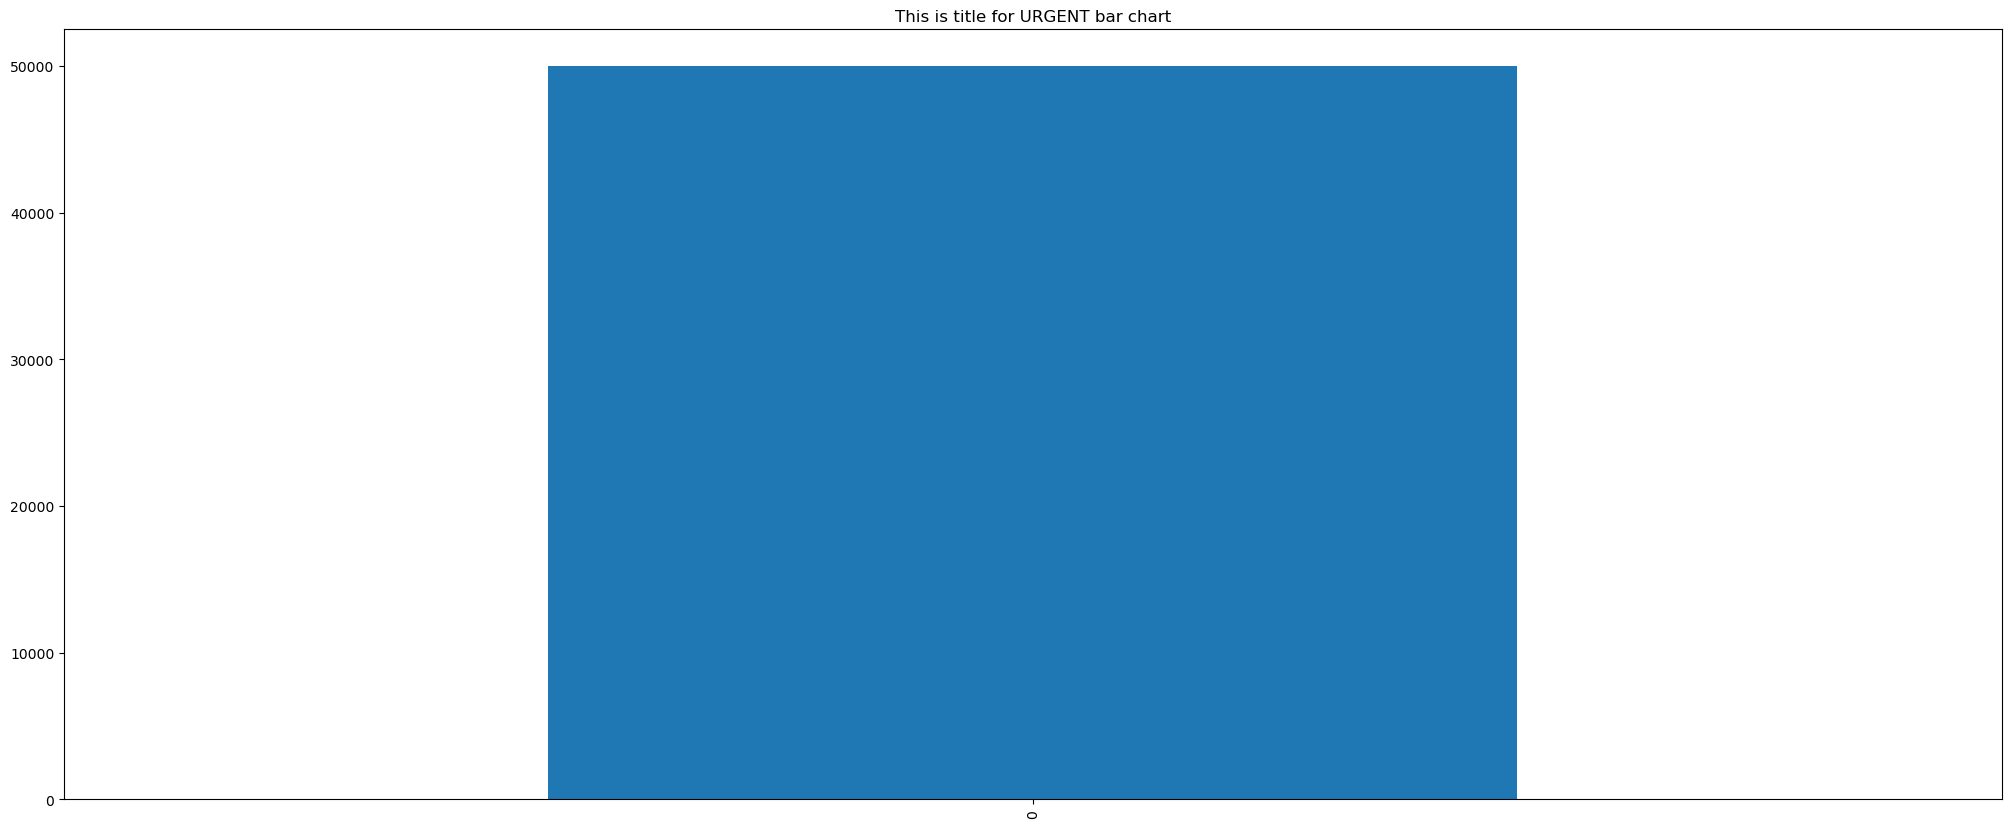

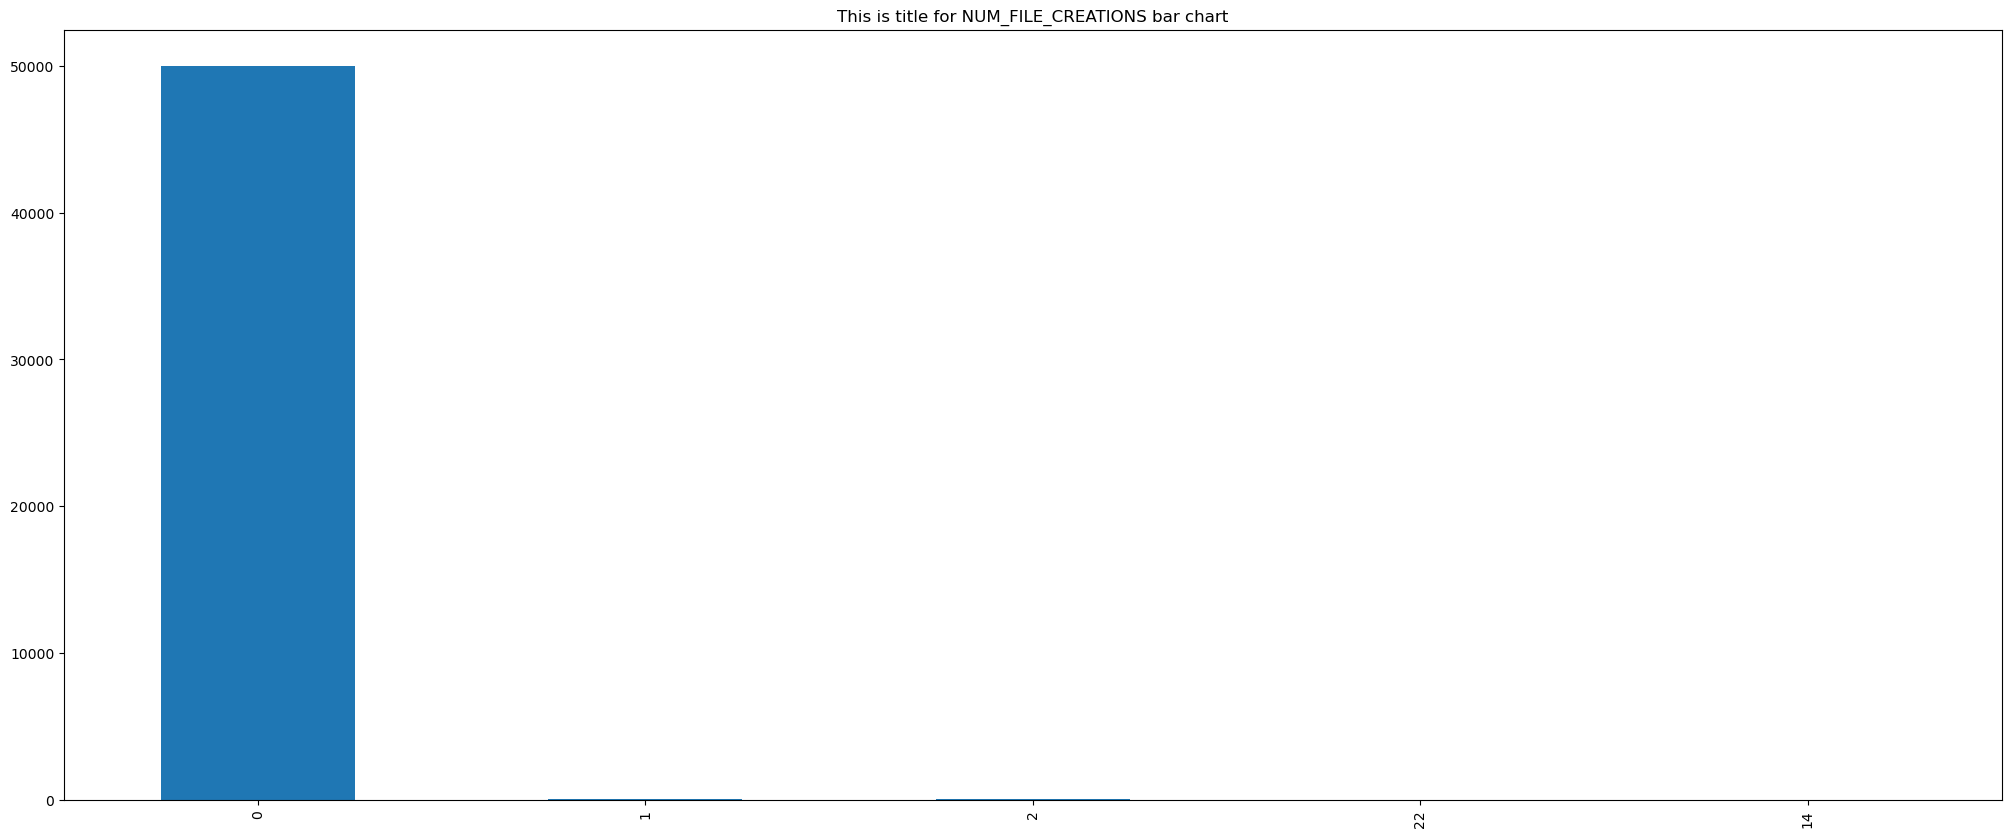

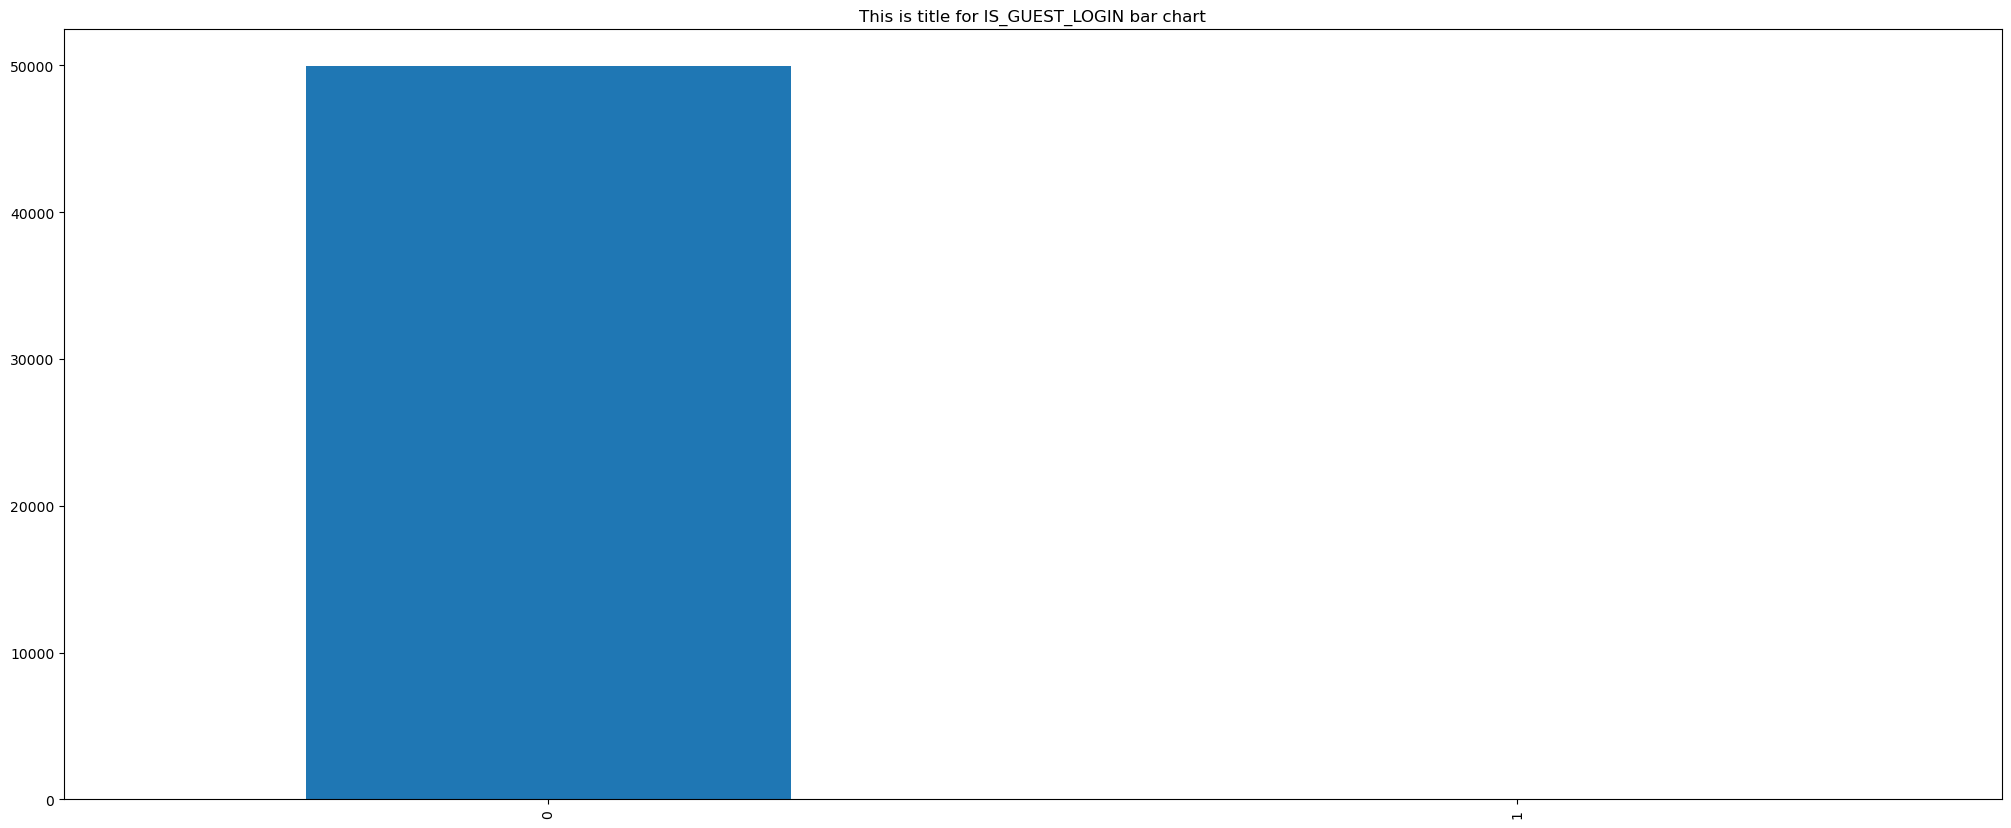

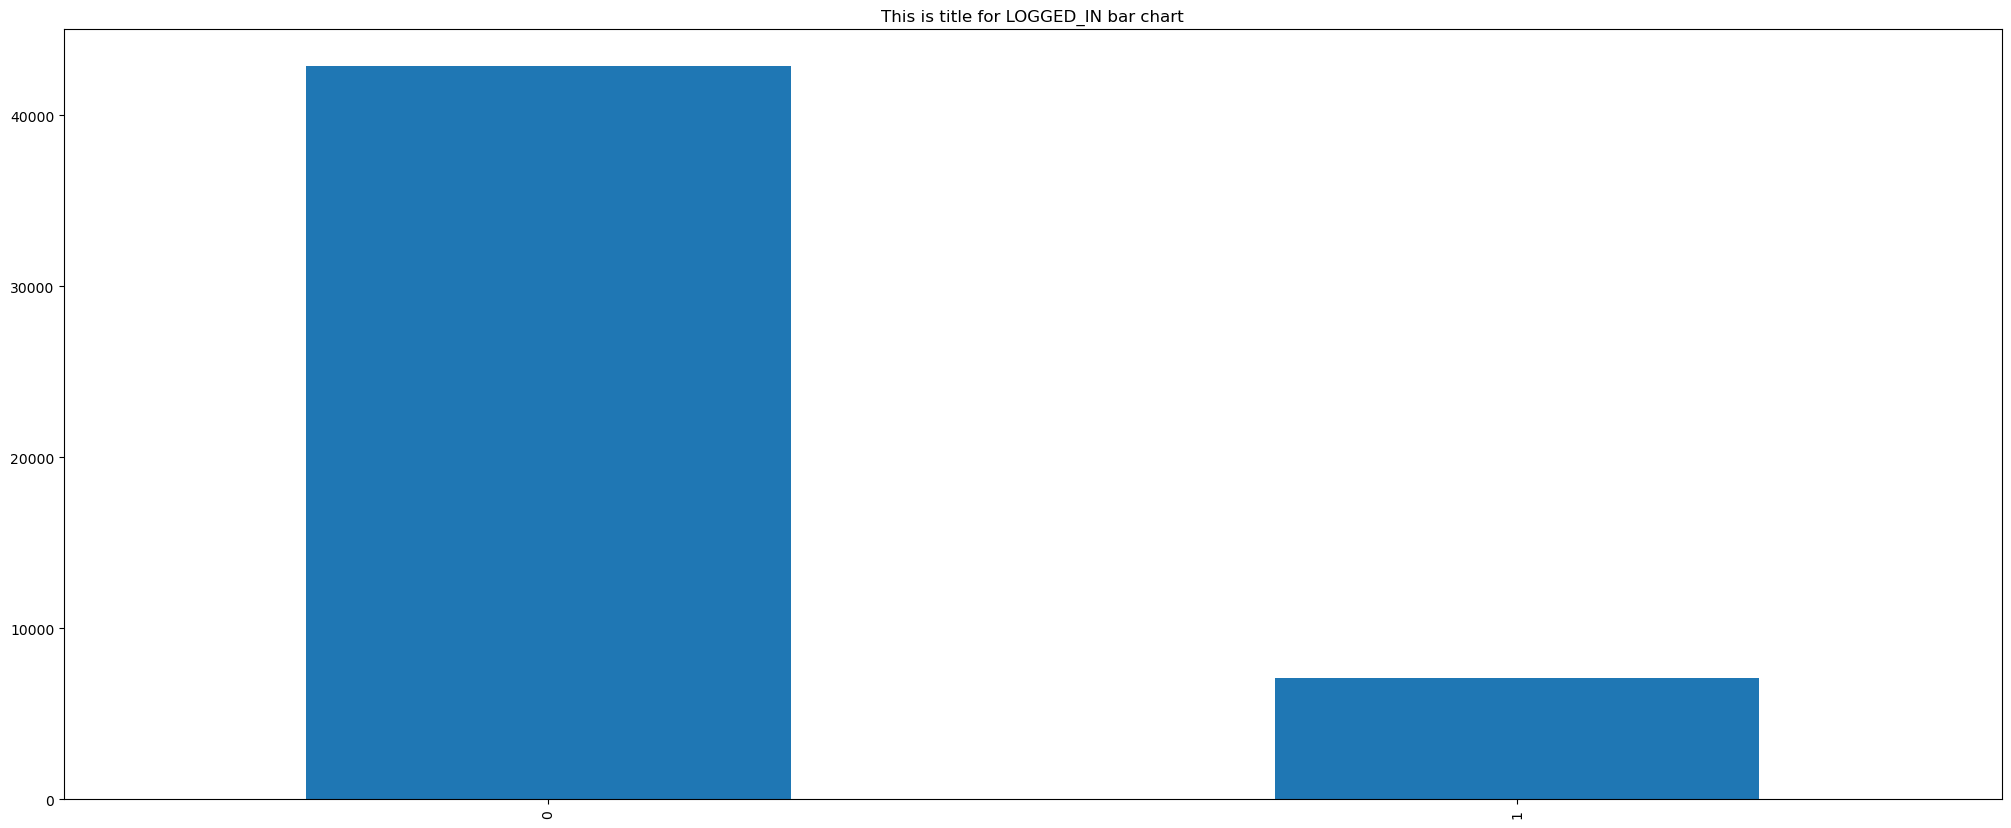

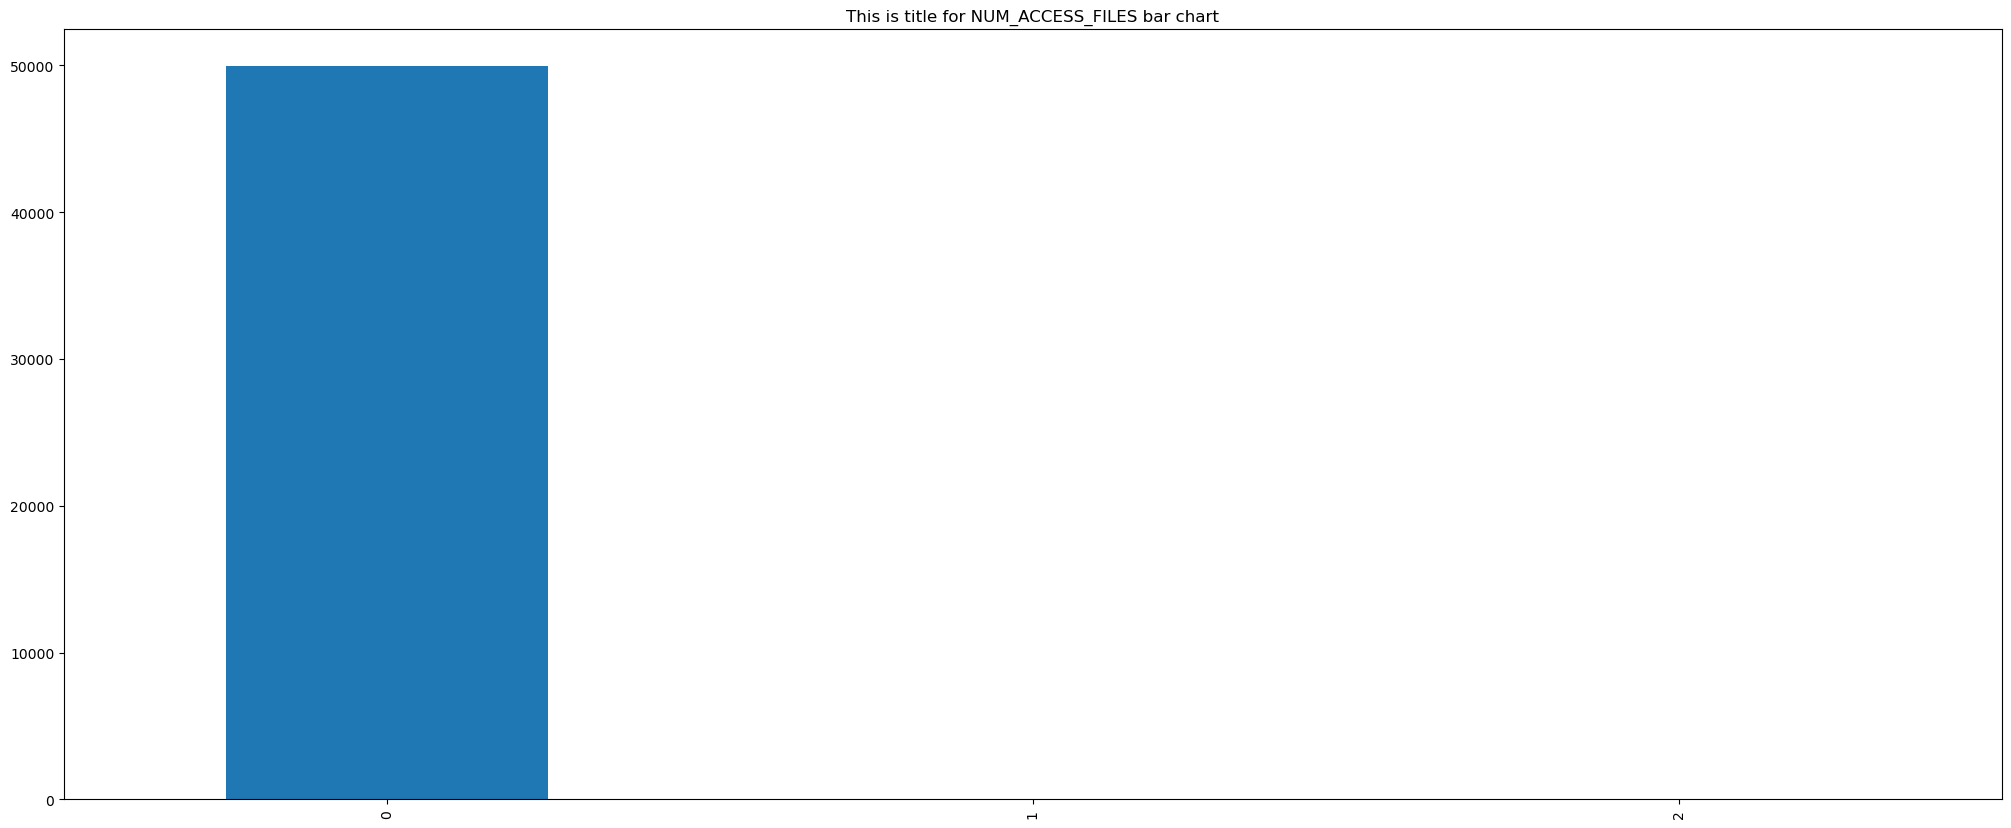

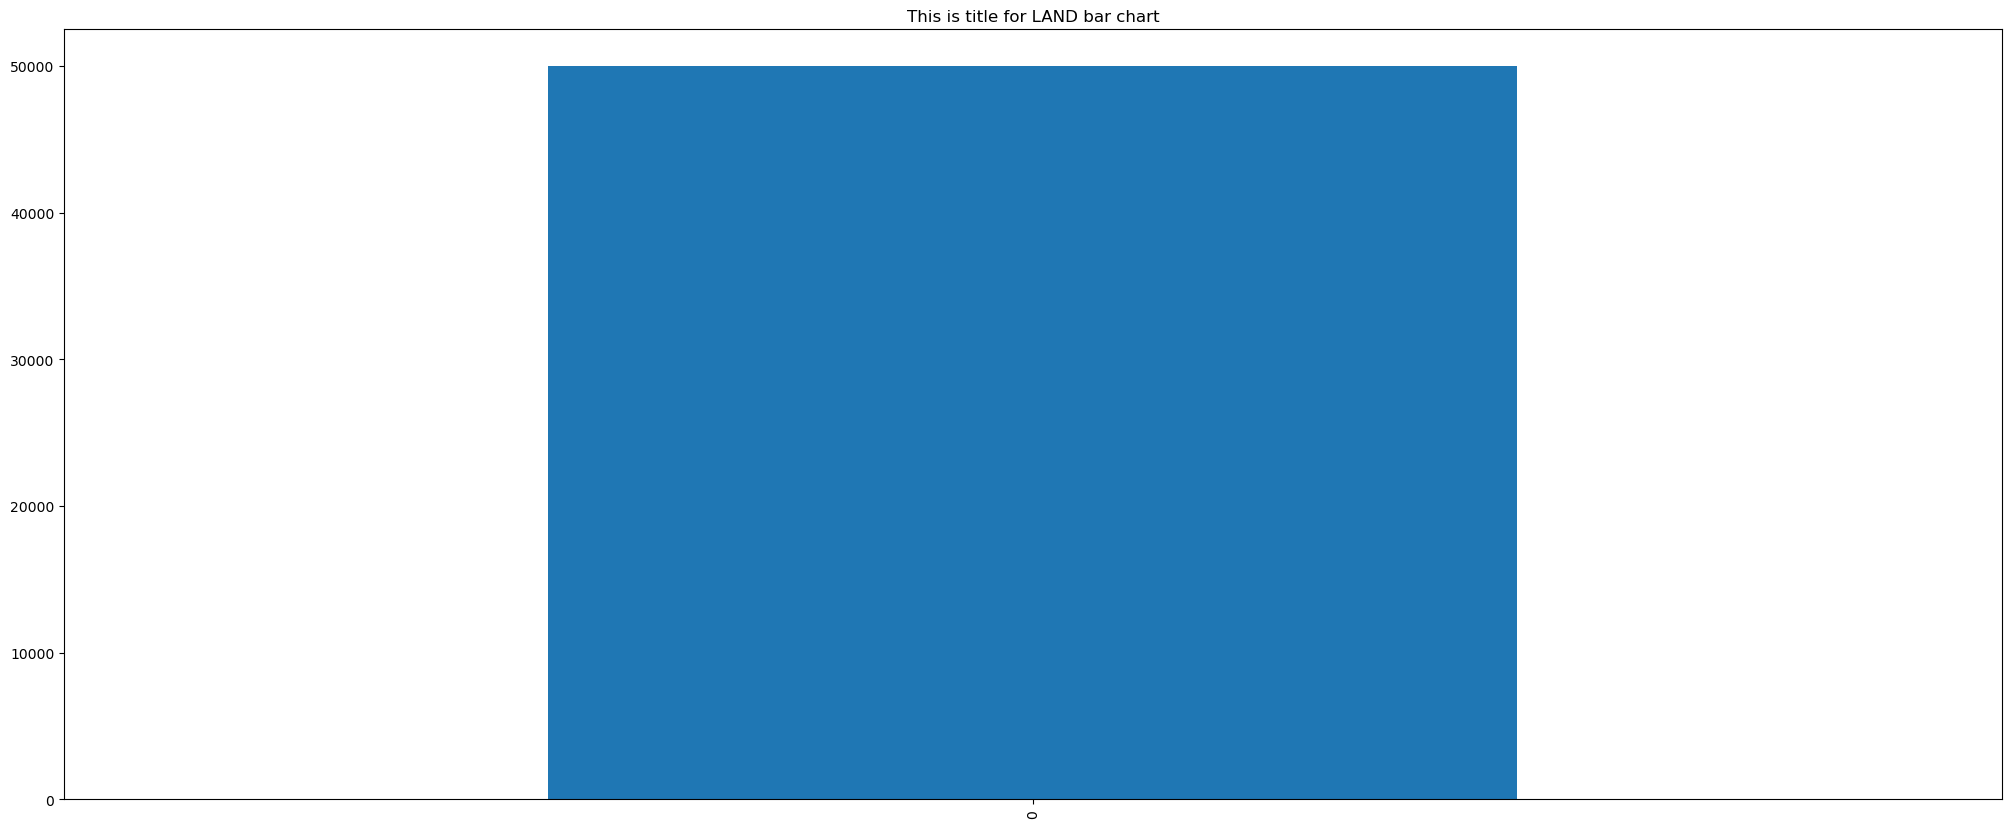

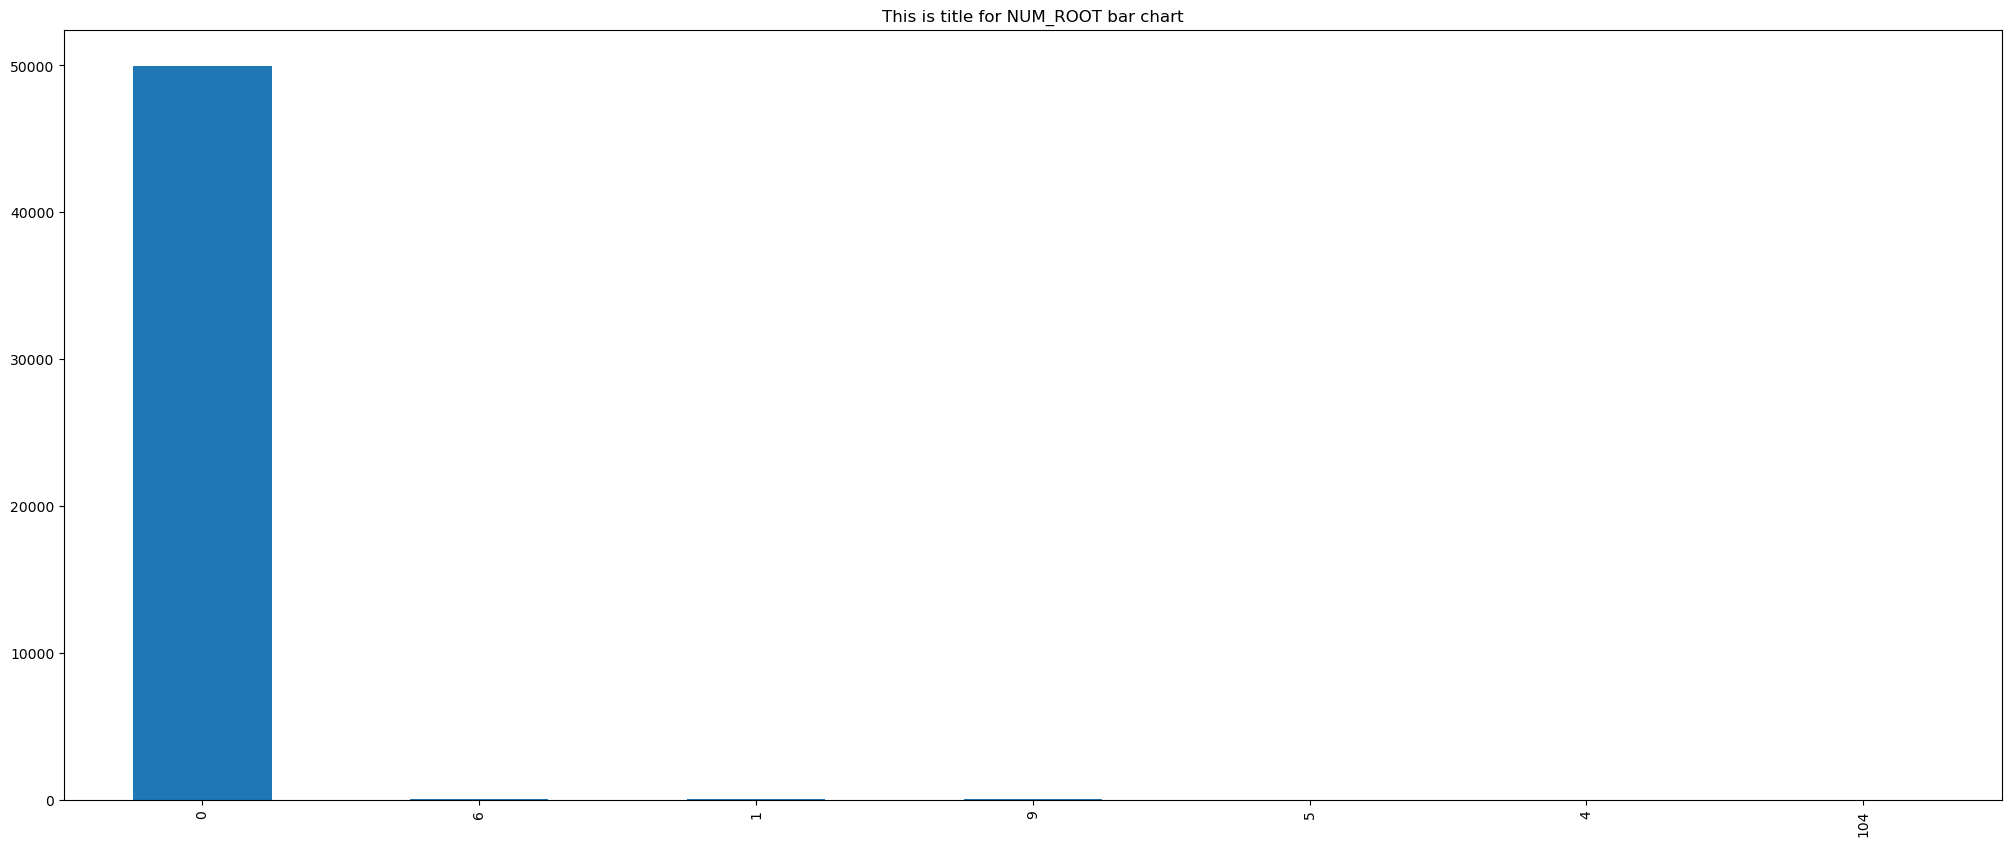

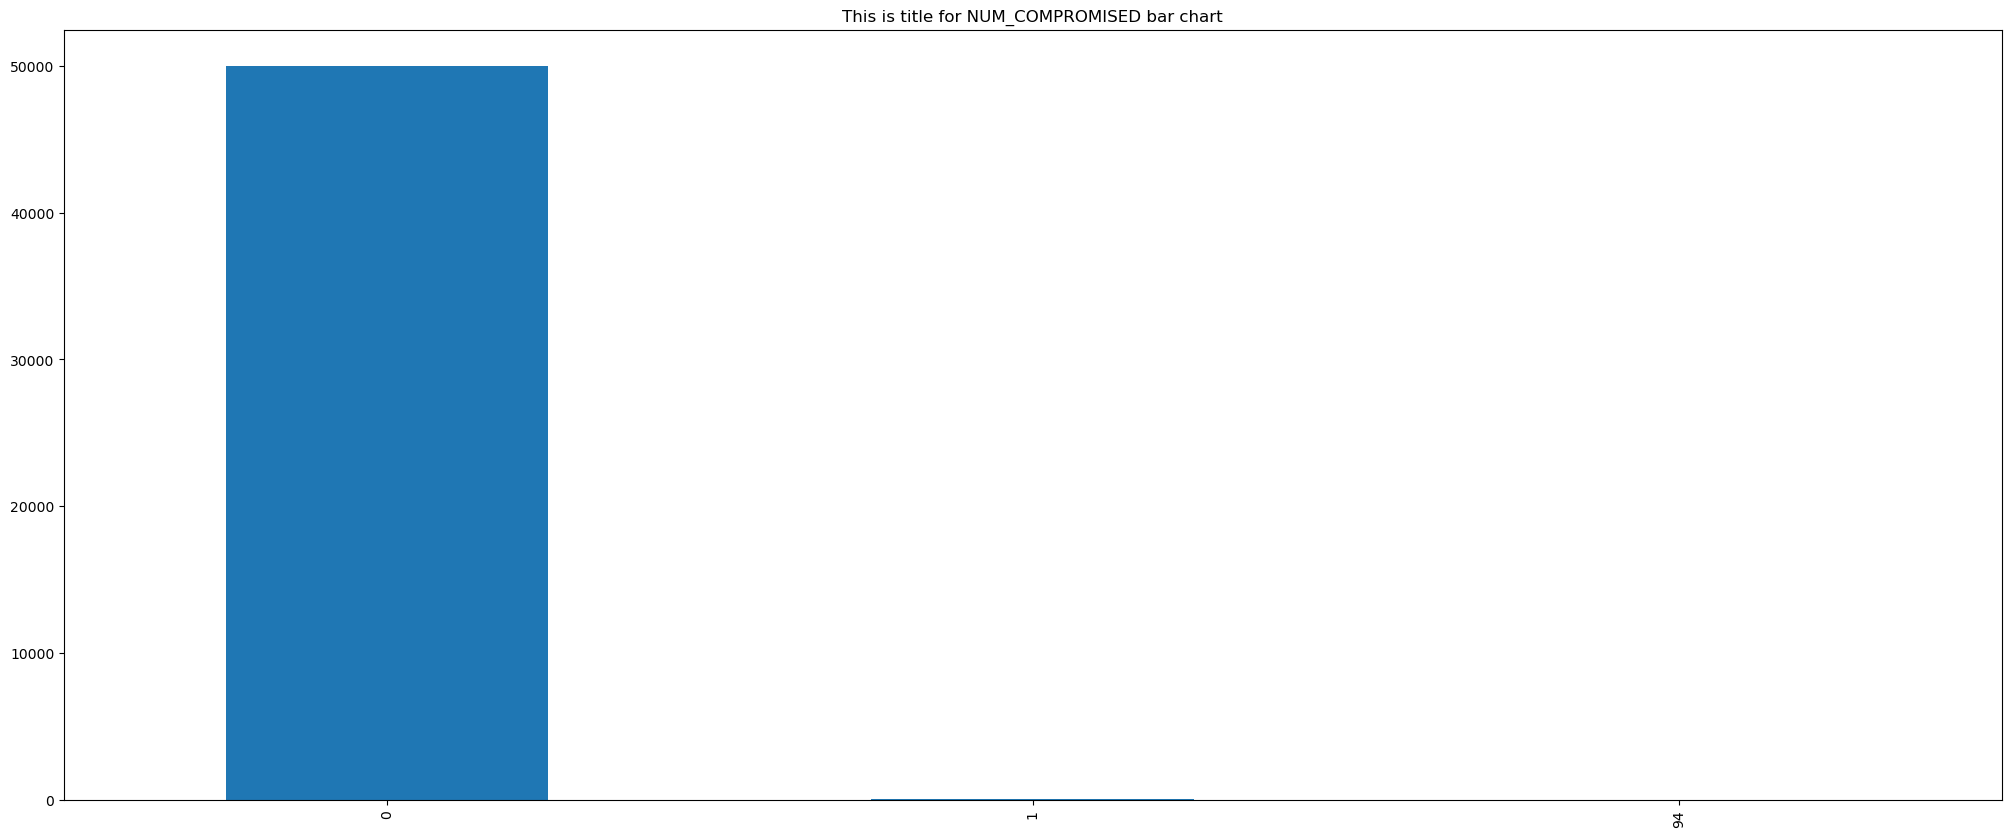

In [39]:
show_bar_plots_for_all_categorical_plots(eda_kdd_cup_df, eda_kdd_cup_99_categorical_features)




Summary for SERVICE feature value counts

-           27386
dns         13317
http         5269
smtp         1351
ftp-data     1040
ftp           964
pop3          309
ssh           301
dhcp           17
ssl            17
snmp           17
irc             9
radius          3
Name: service, dtype: int64



Summary for STATE feature value counts

FIN    22827
INT    22468
CON     3934
REQ      748
RST       19
ACC        3
ECO        1
Name: state, dtype: int64



Summary for PROTO feature value counts

tcp            23950
udp            18021
unas            2936
arp              730
ospf             623
sctp             300
any               82
ipv6              66
gre               61
sep               59
swipe             55
sun-nd            50
rsvp              46
idrp              41
mobile            39
pim               37
encap             35
ipv6-opts         35
tcf               34
mhrp              34
sps               34
ipv6-route        34
ax.25             34
igp    

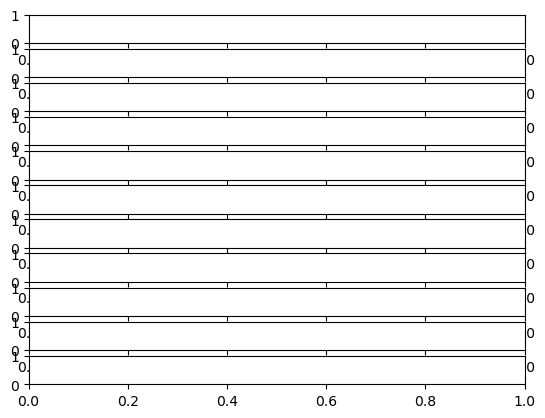

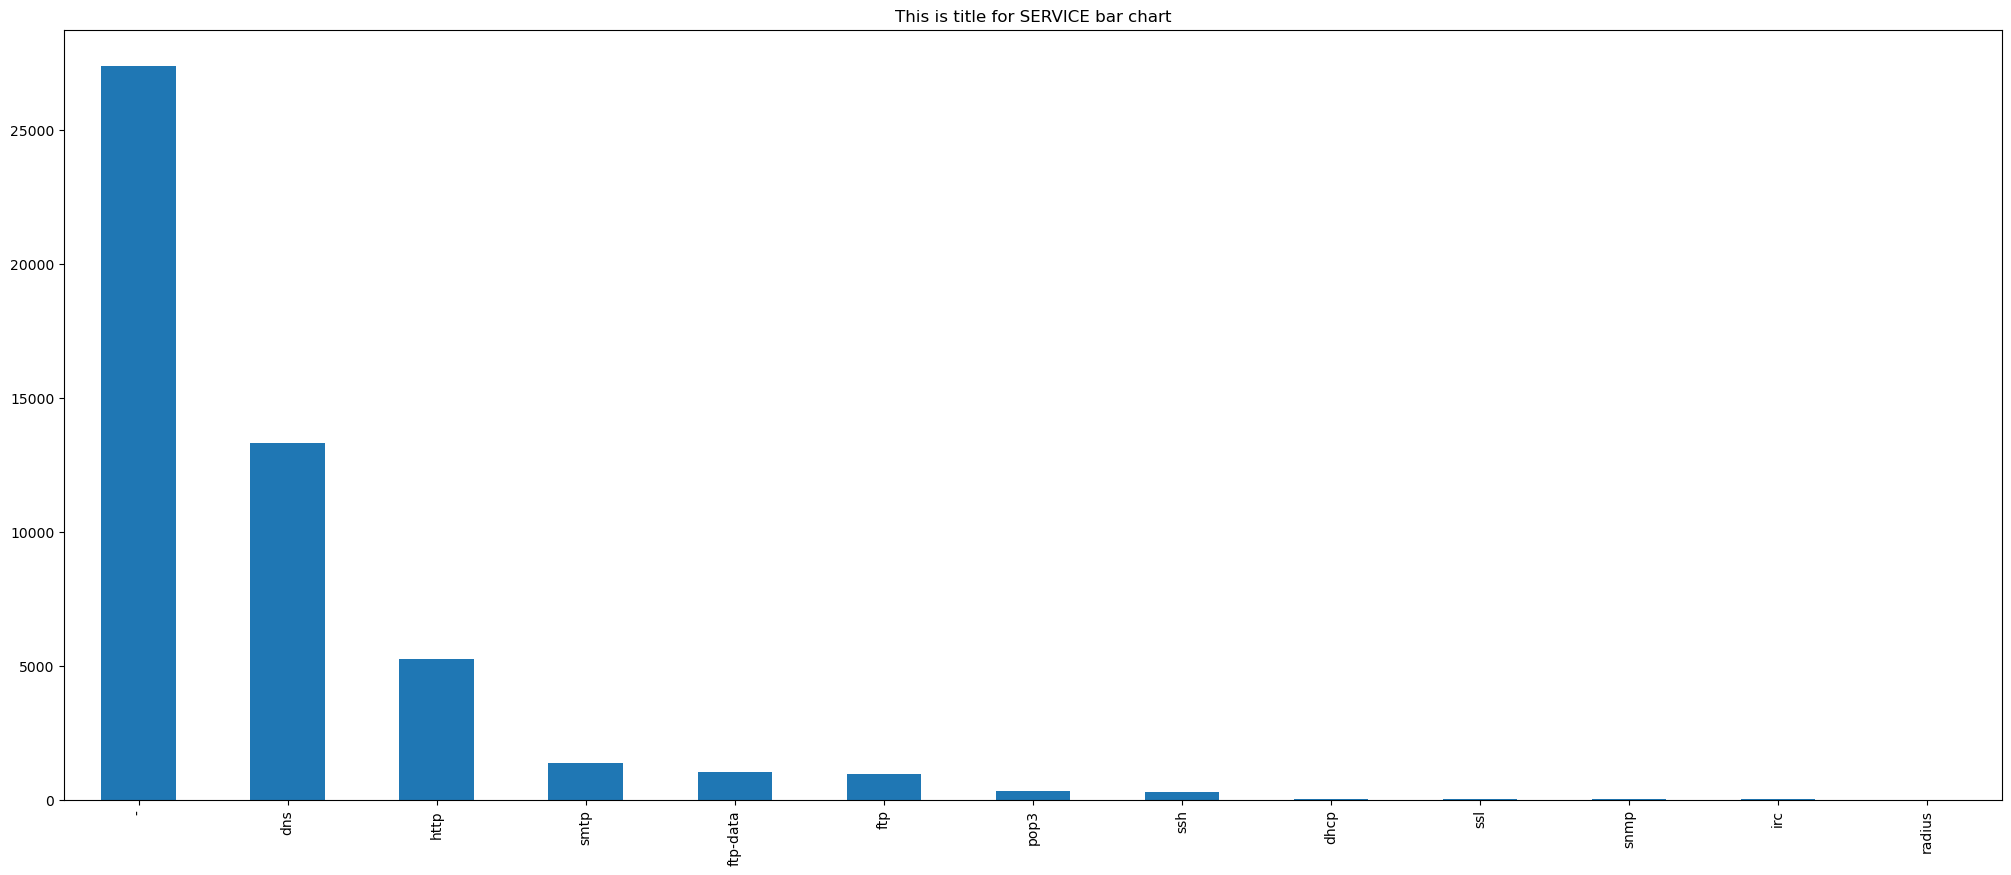

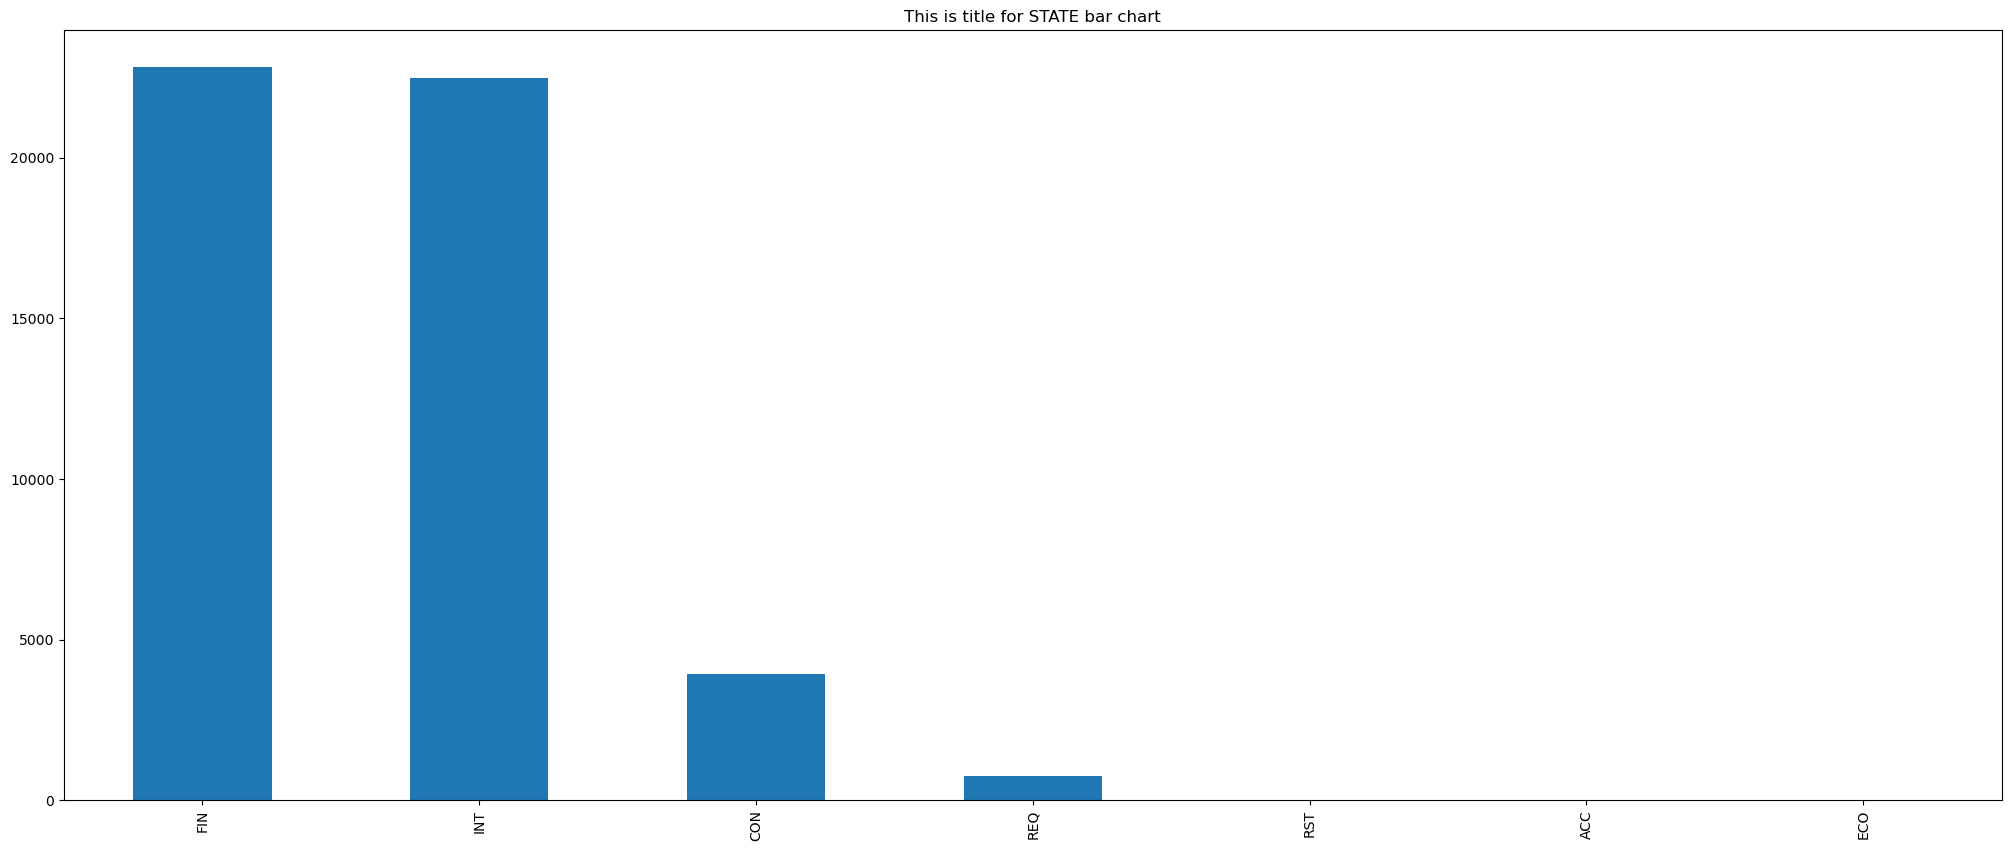

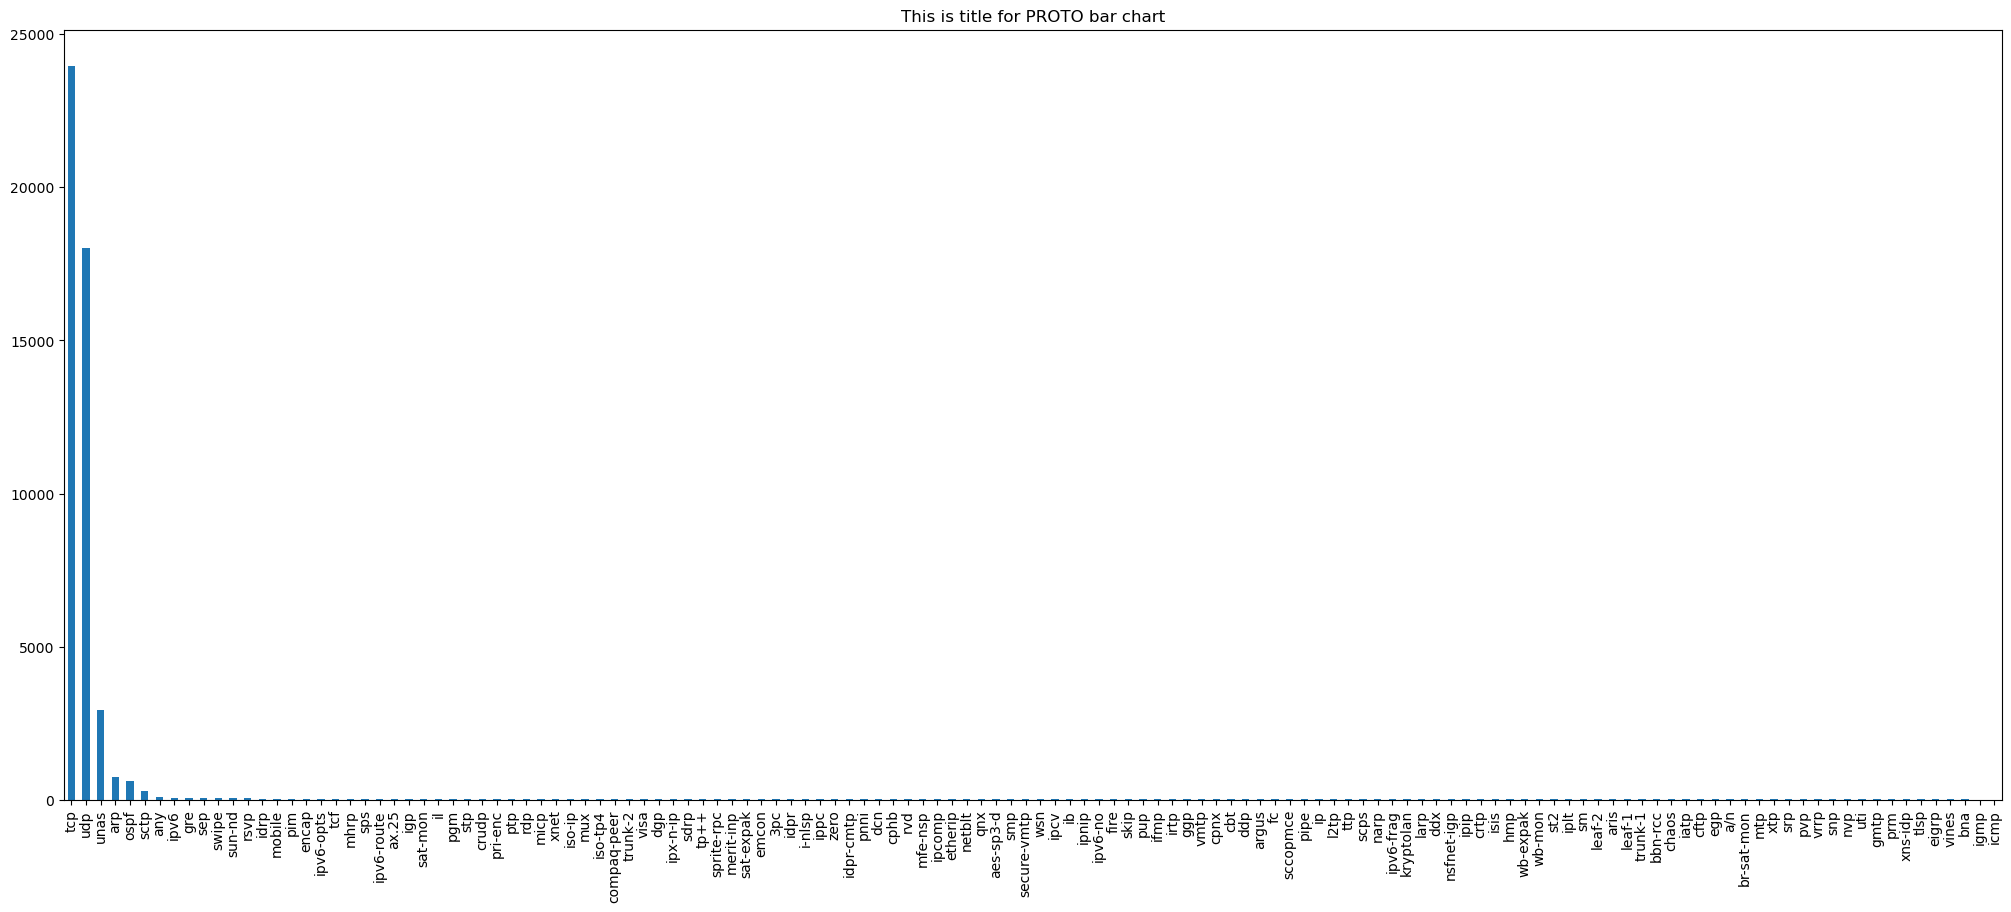

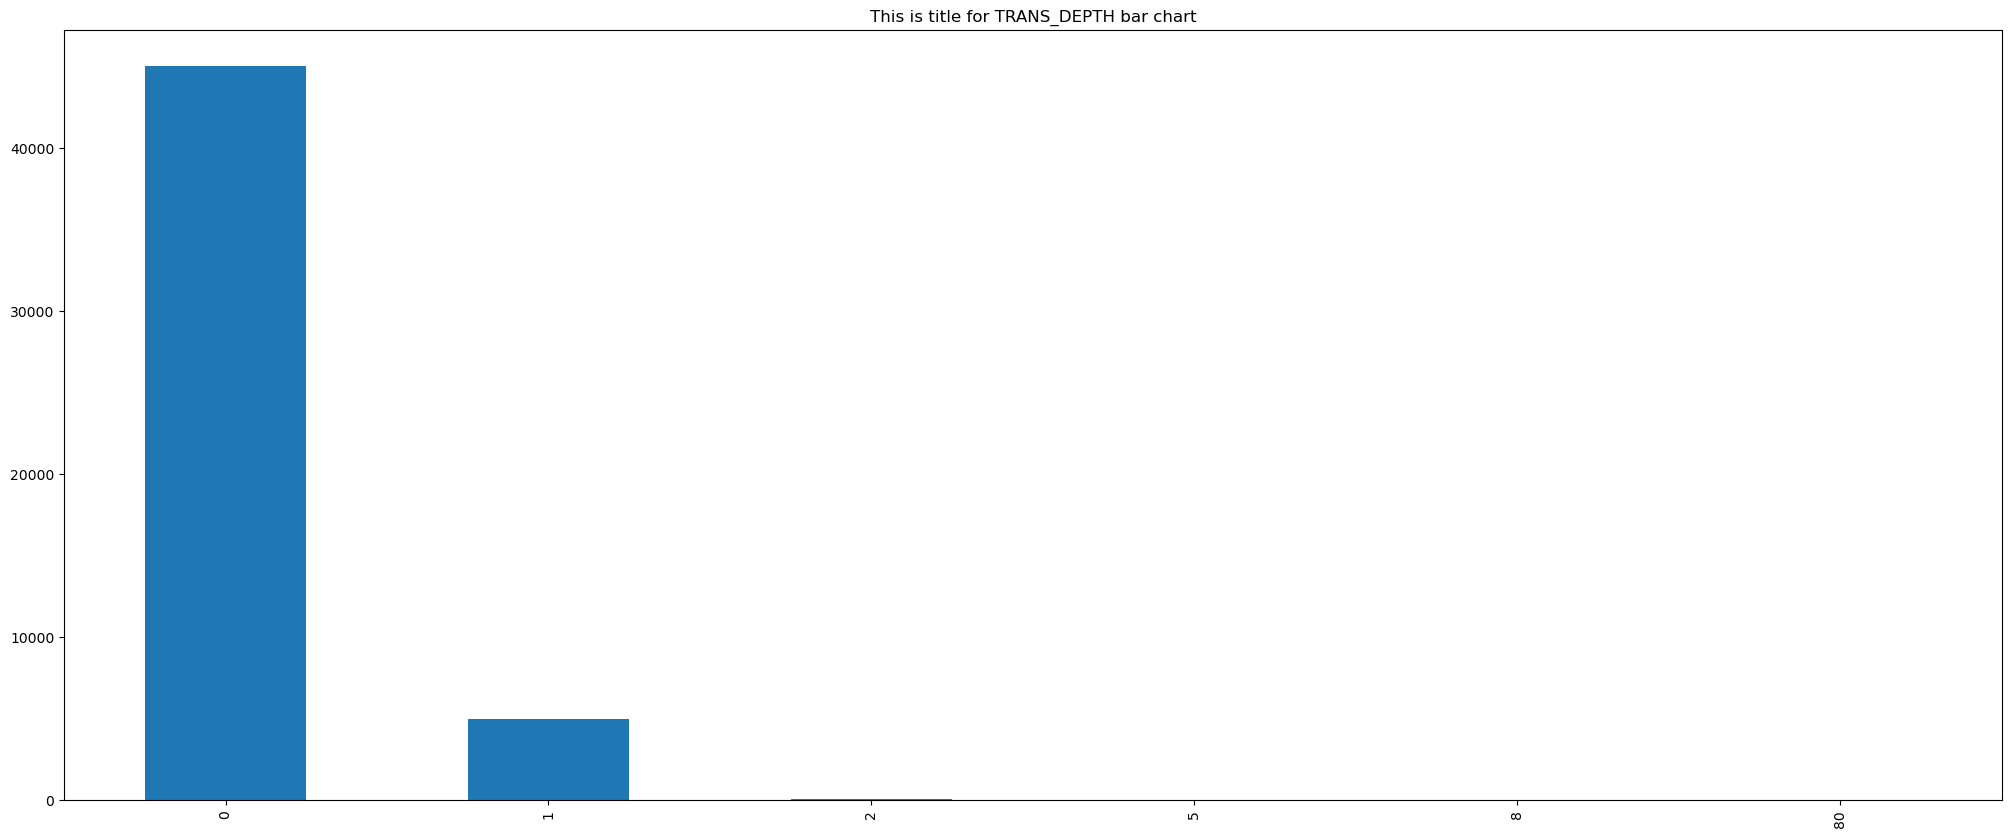

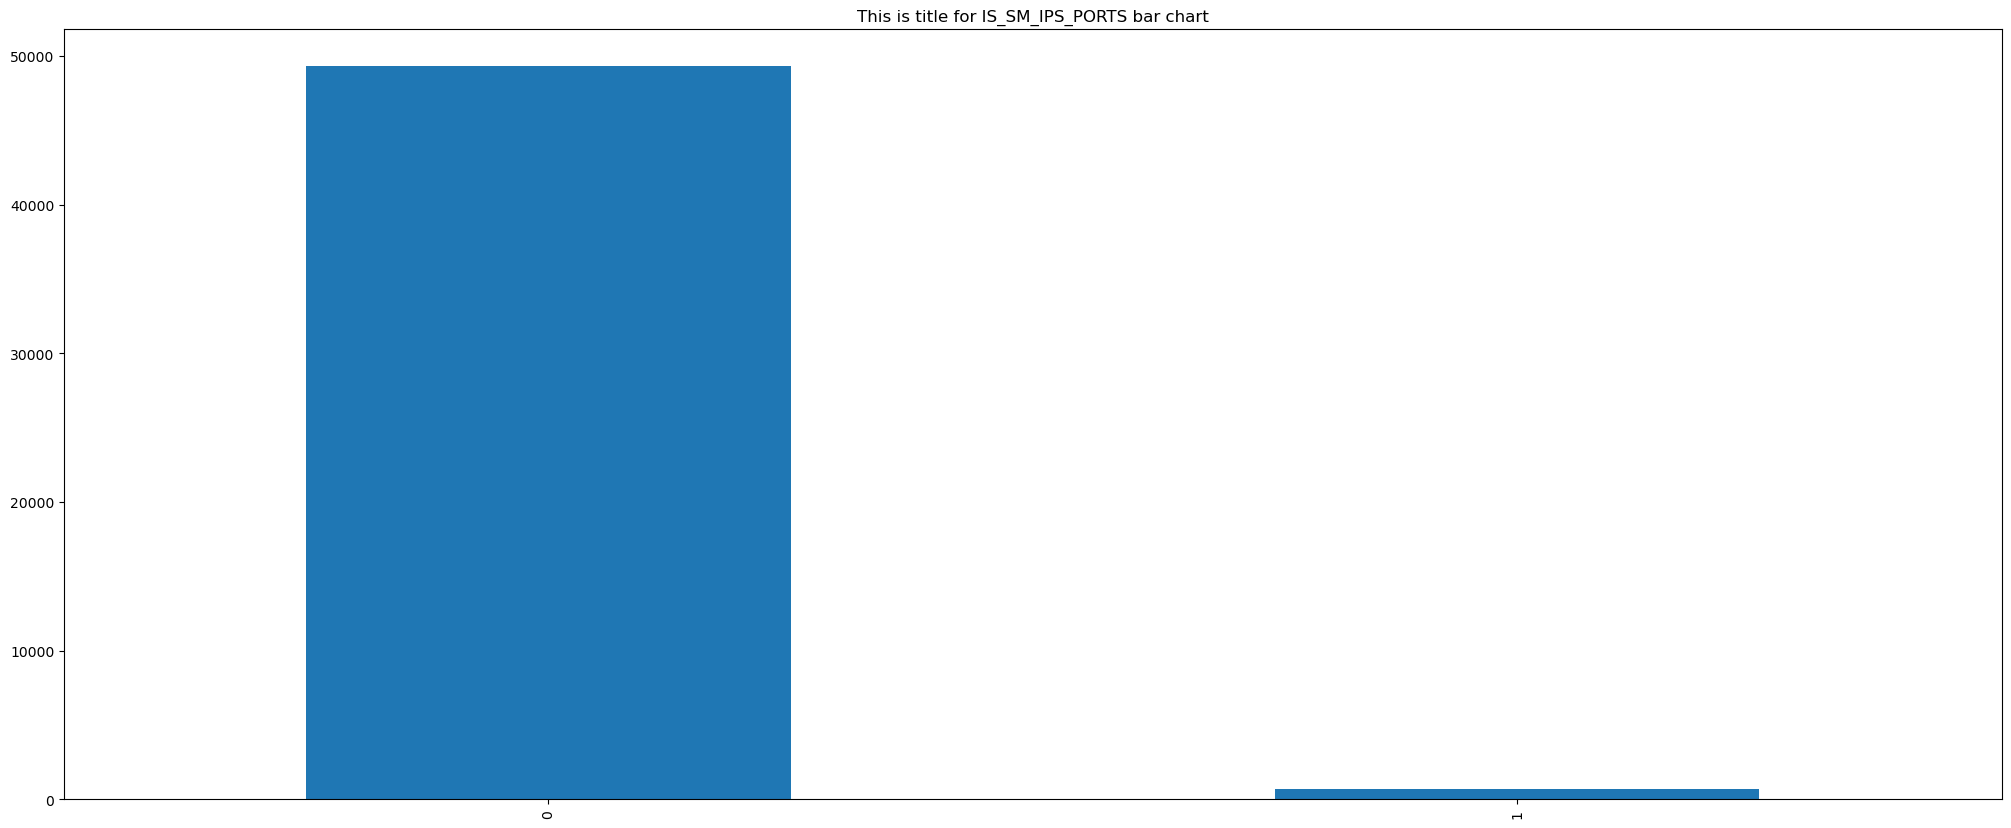

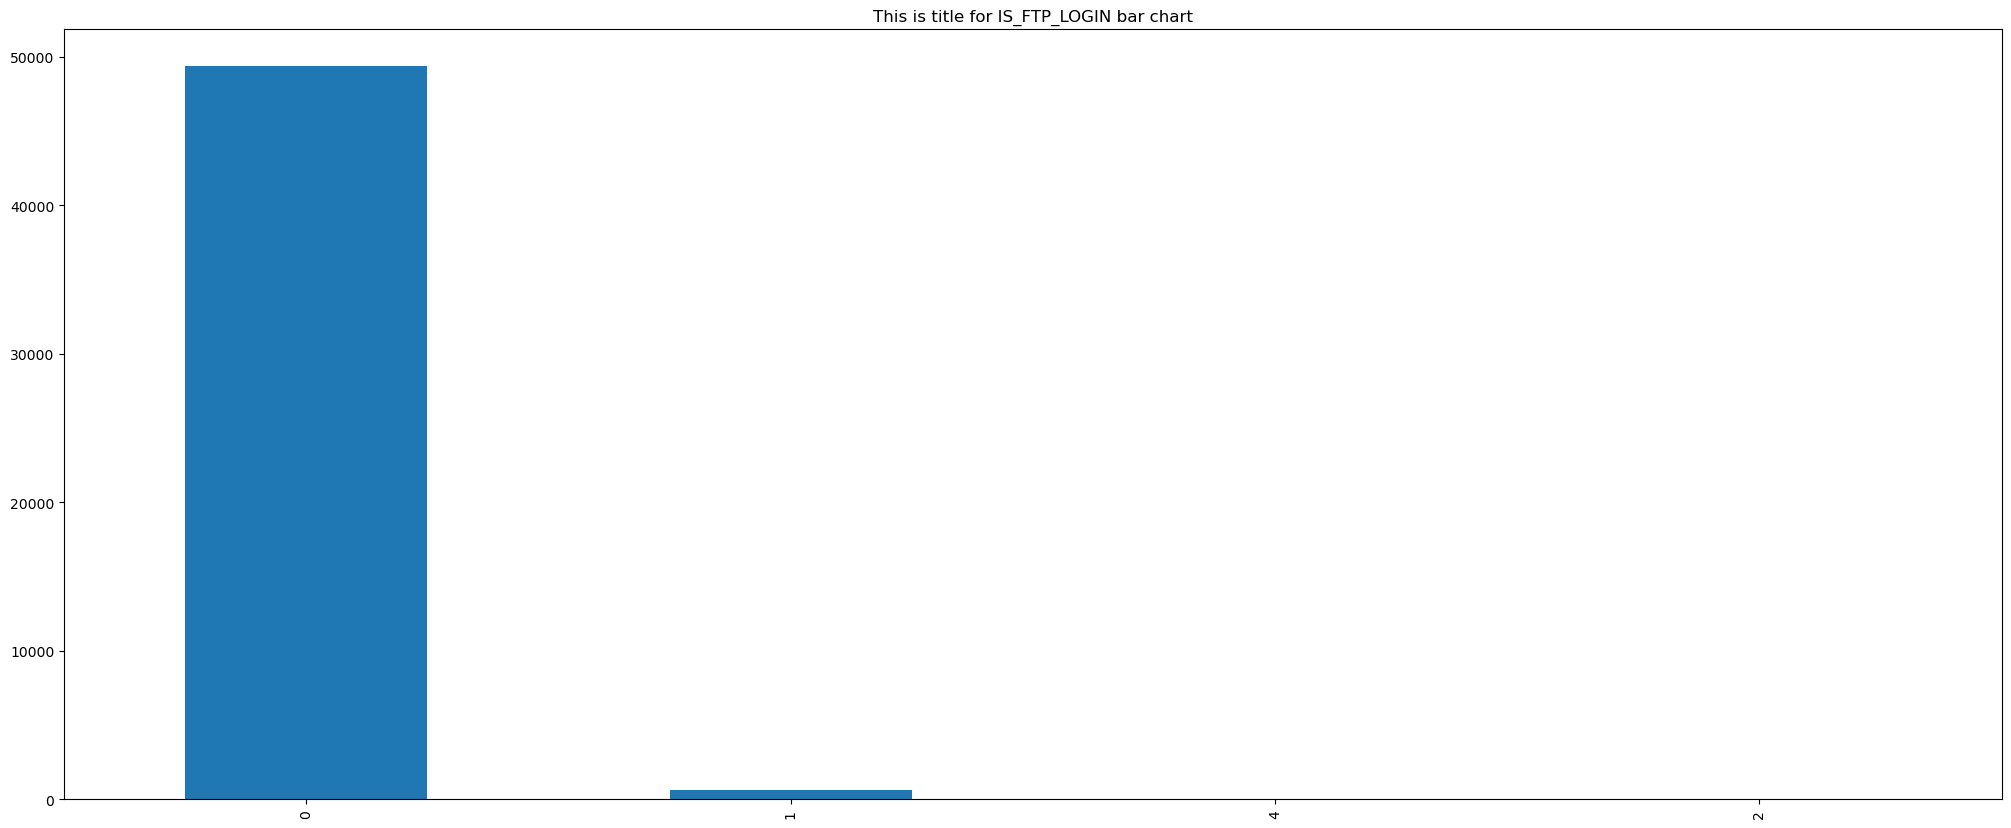

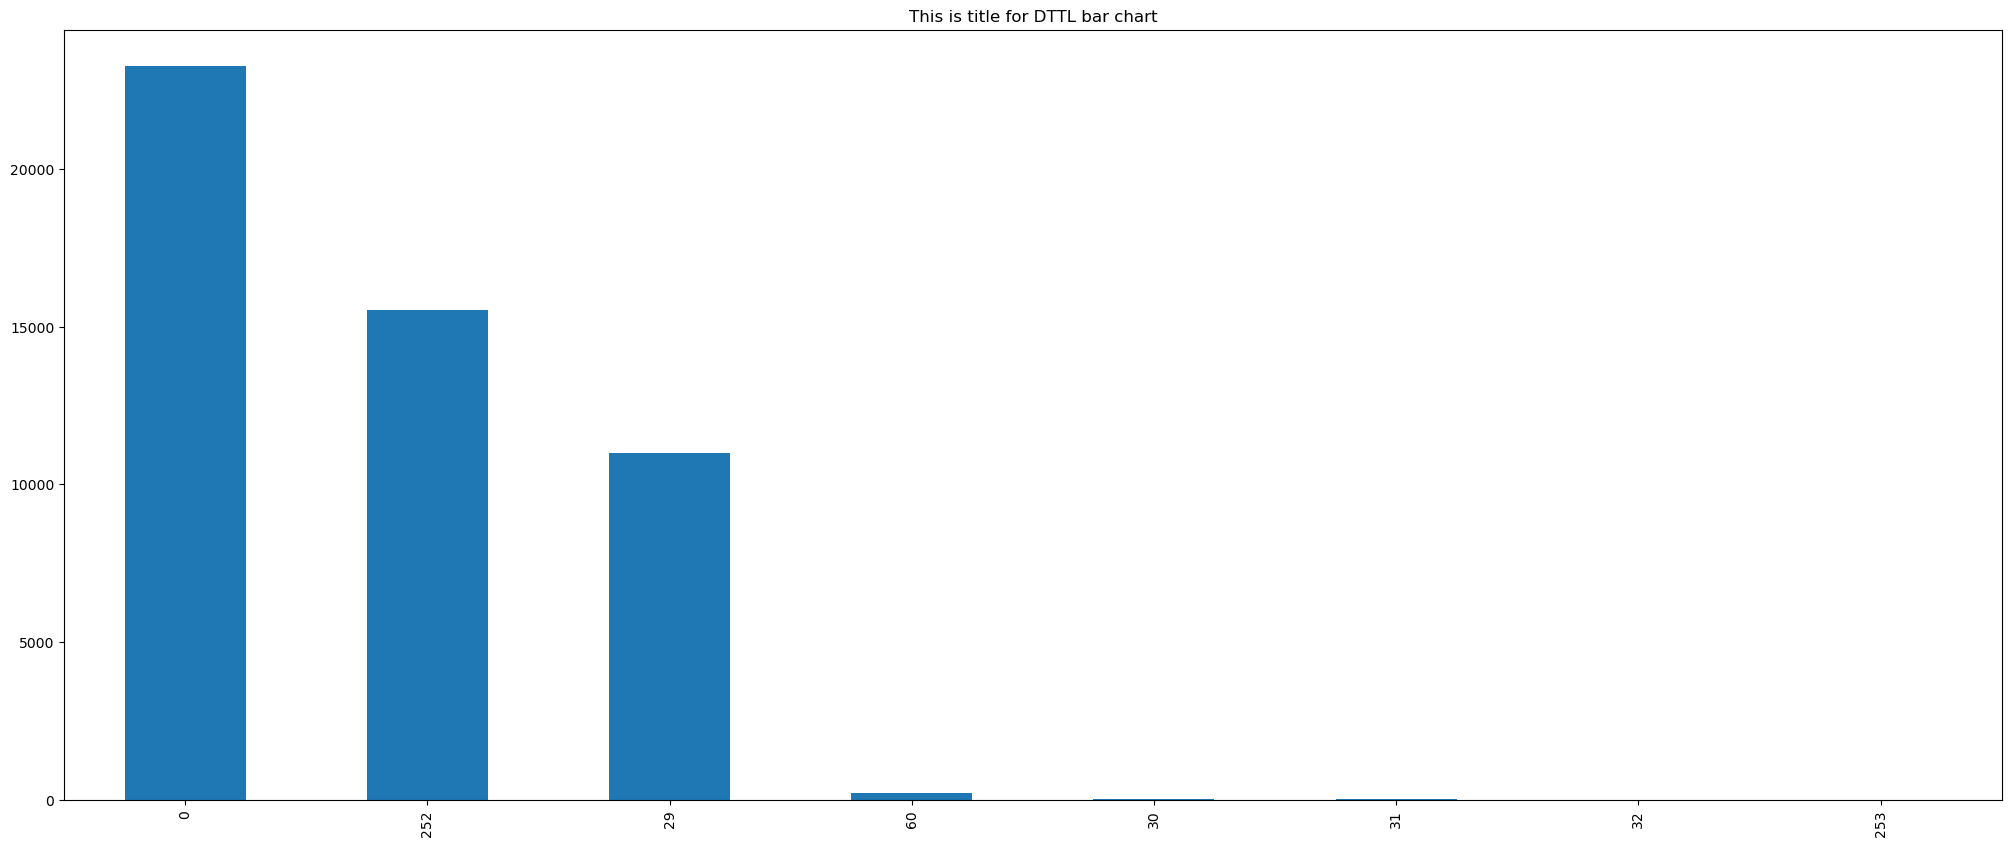

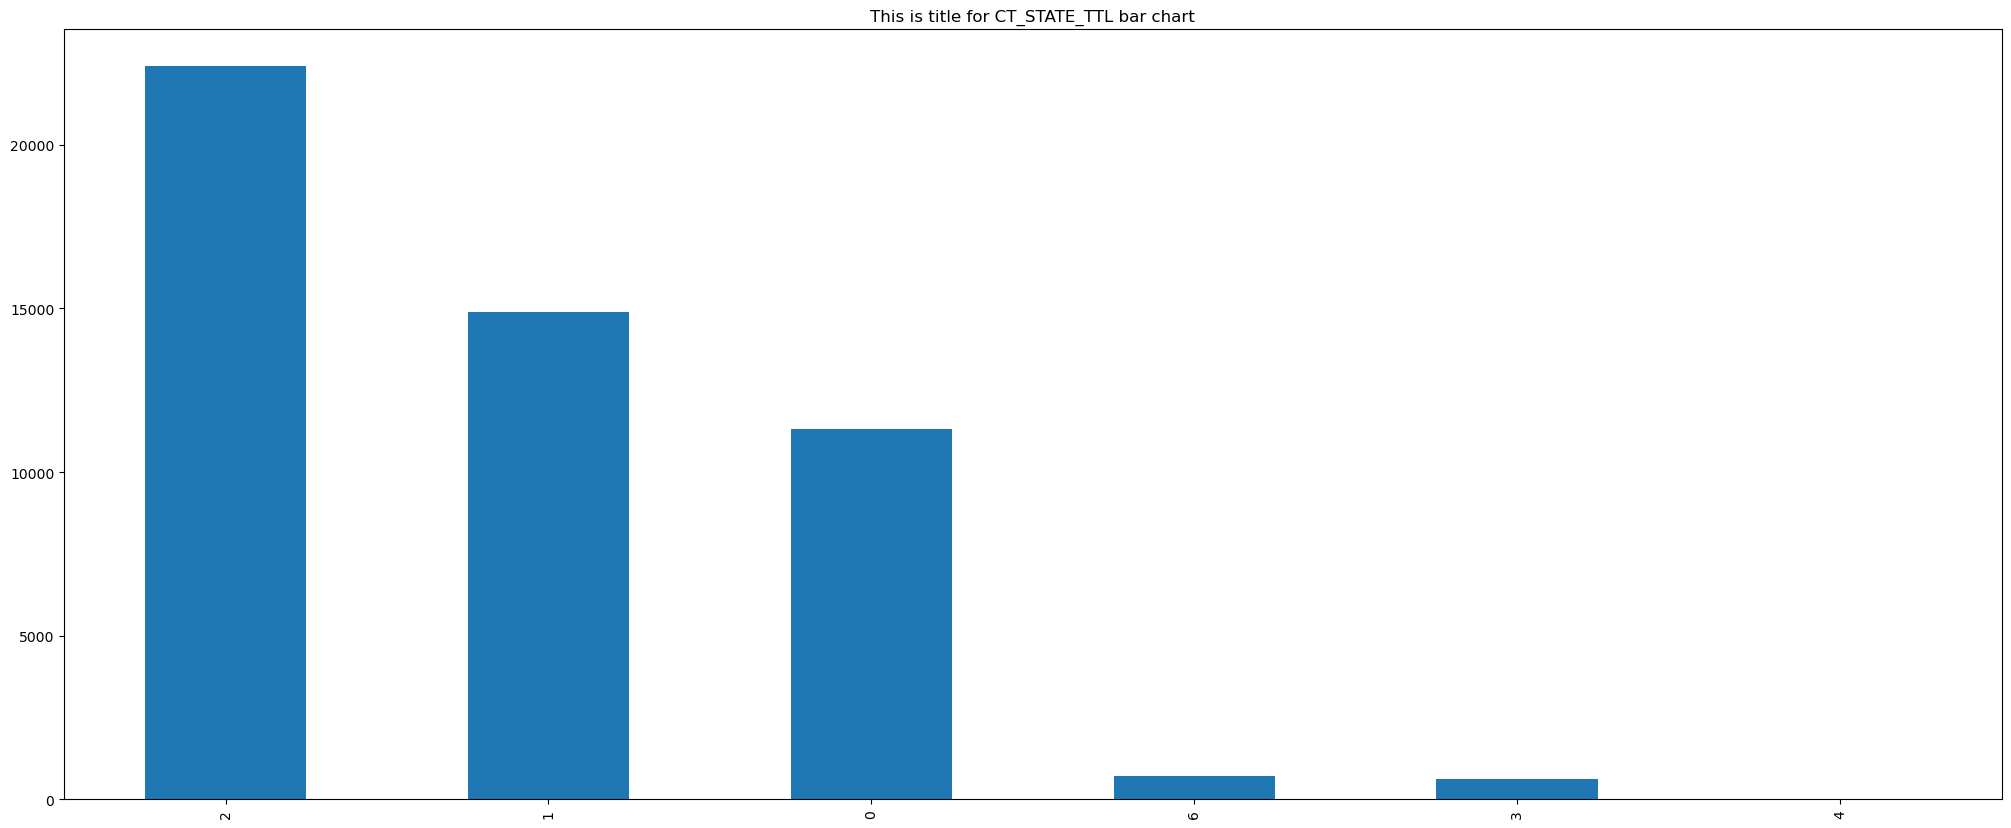

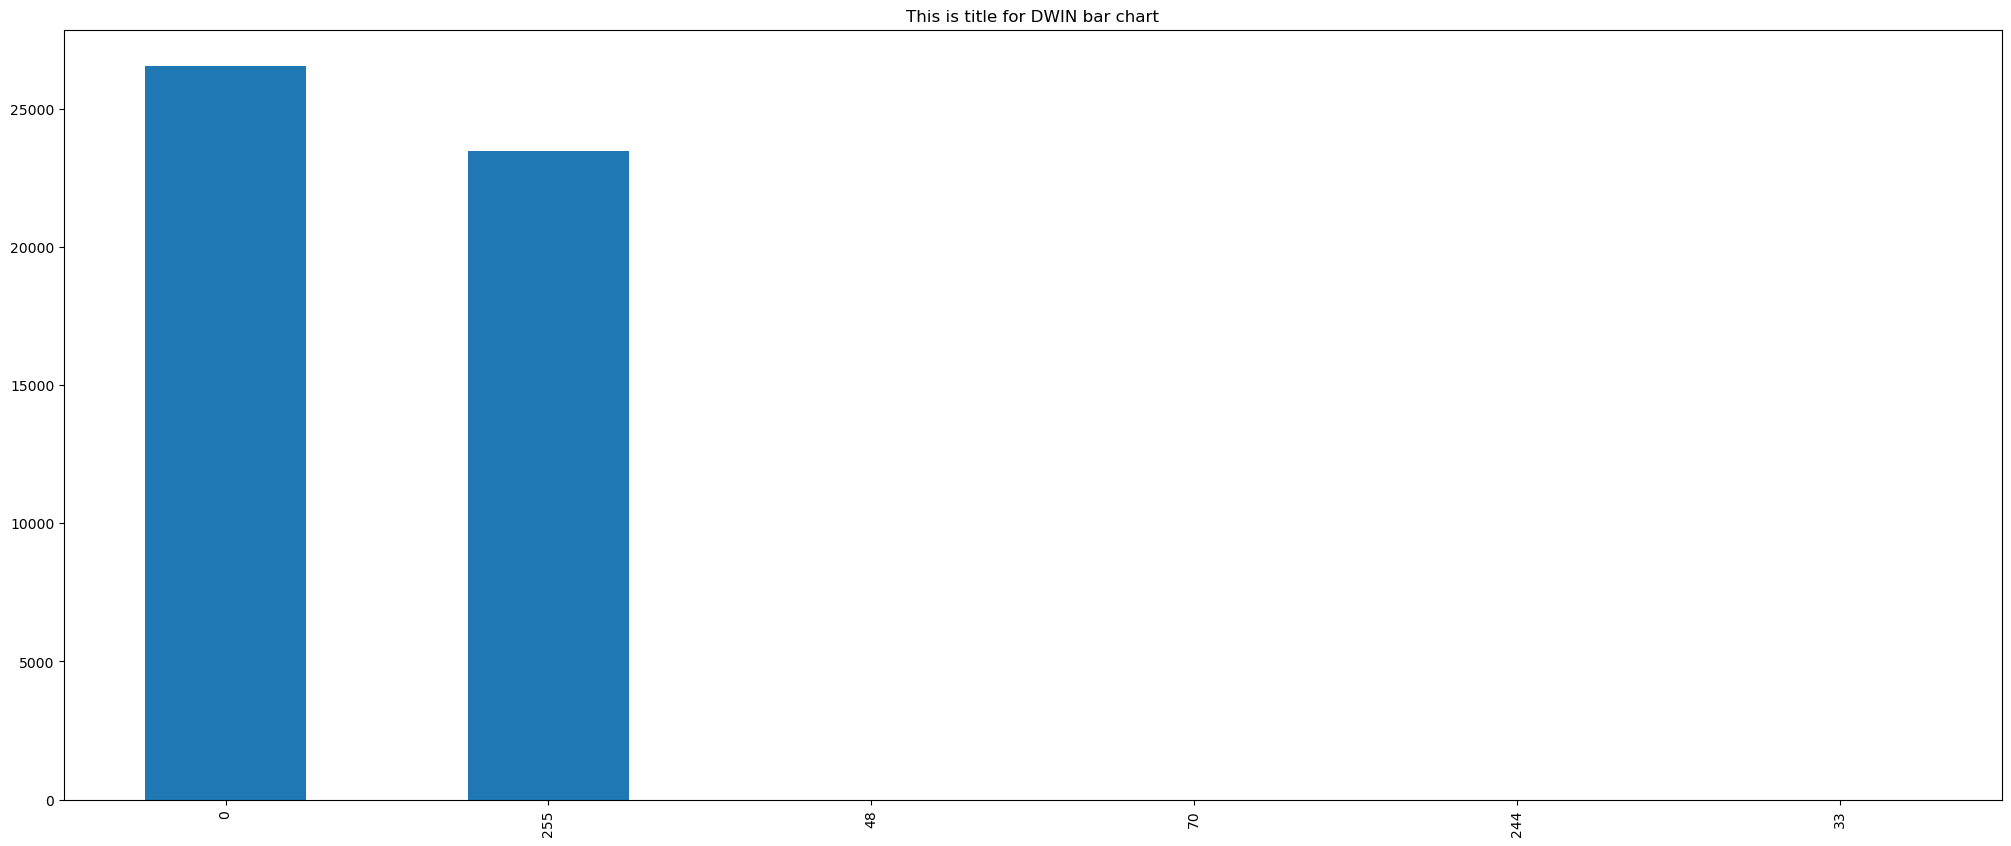

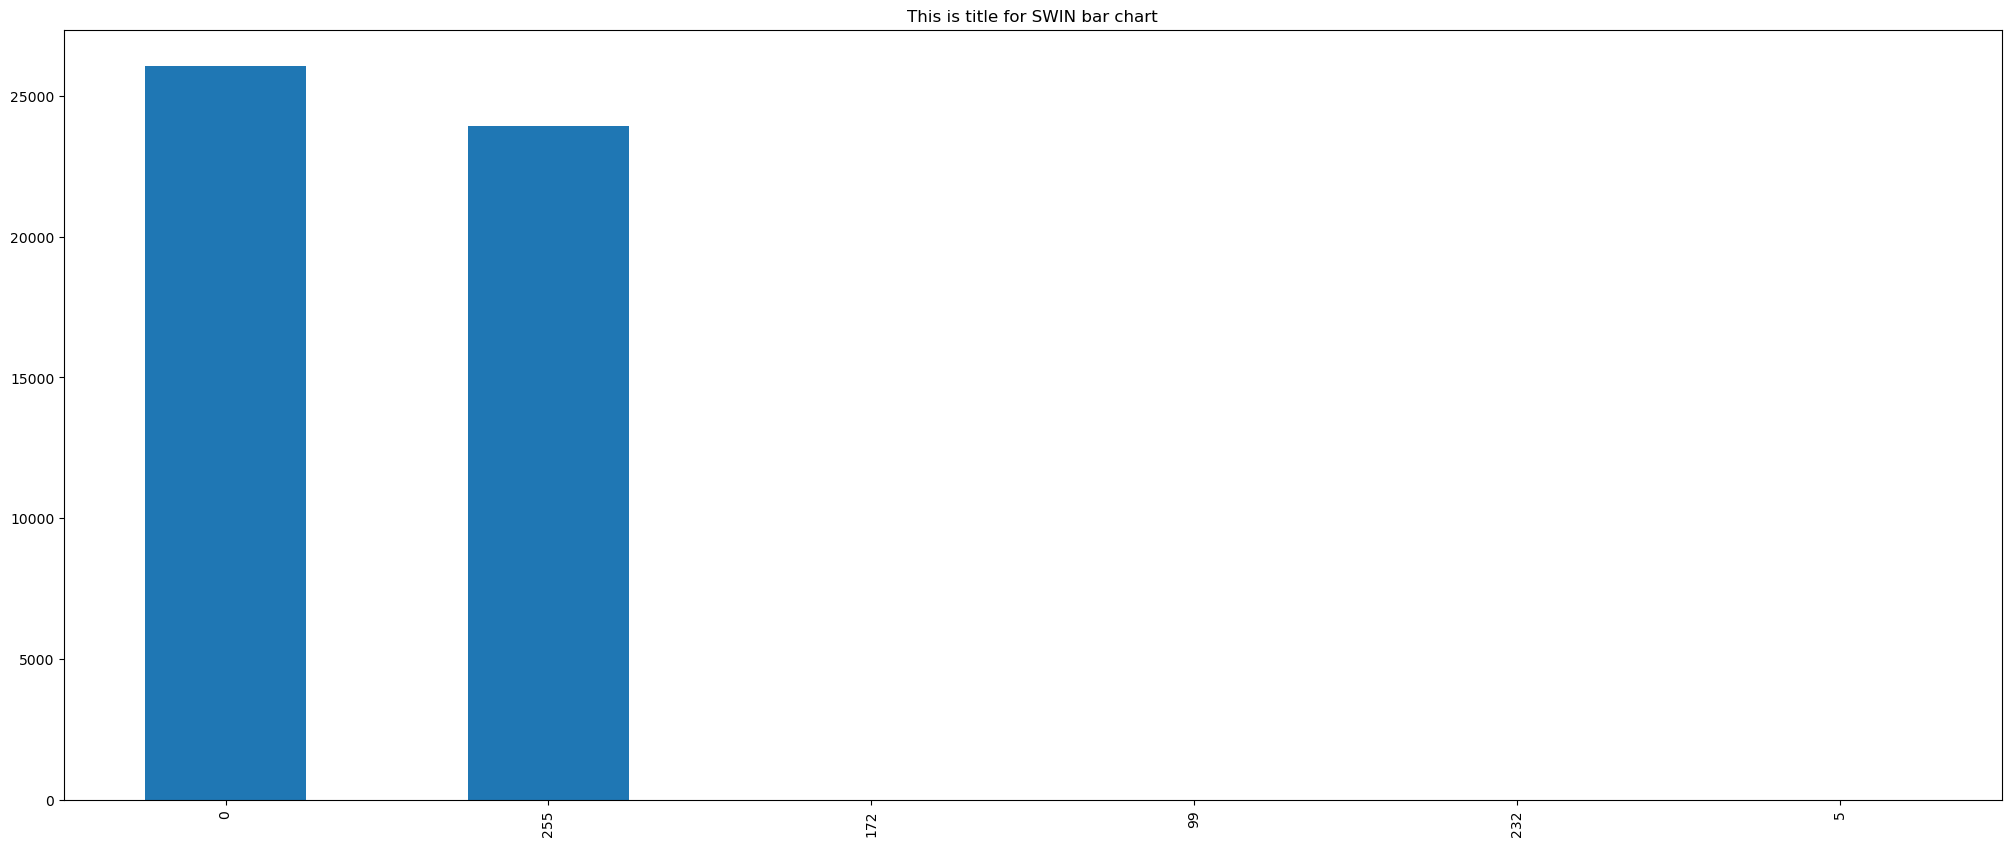

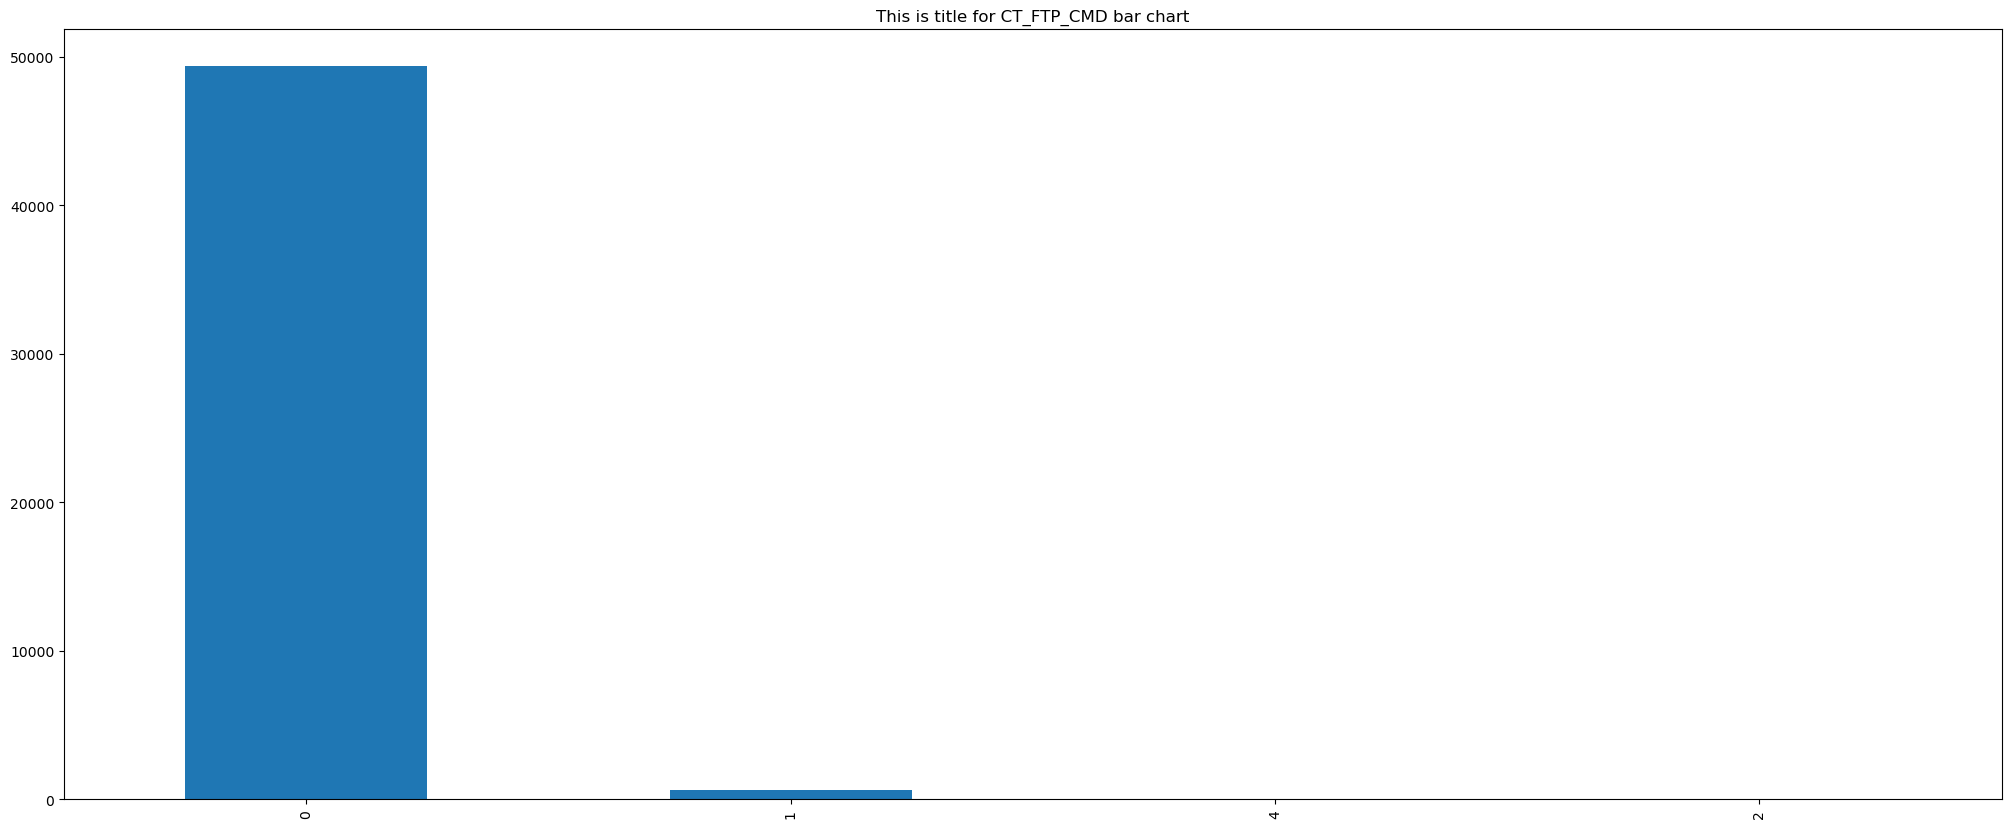

In [40]:
show_bar_plots_for_all_categorical_plots(eda_unsw_nb15_df, eda_unsw_nb15_categorical_features)

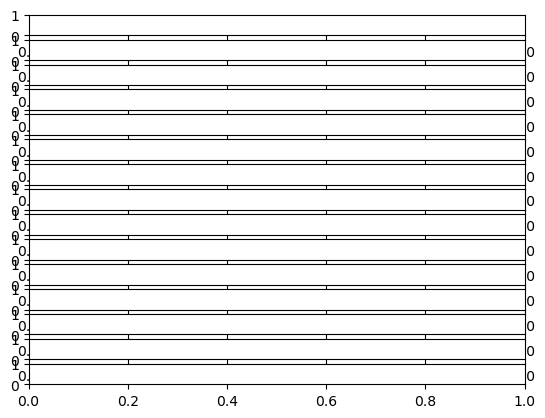

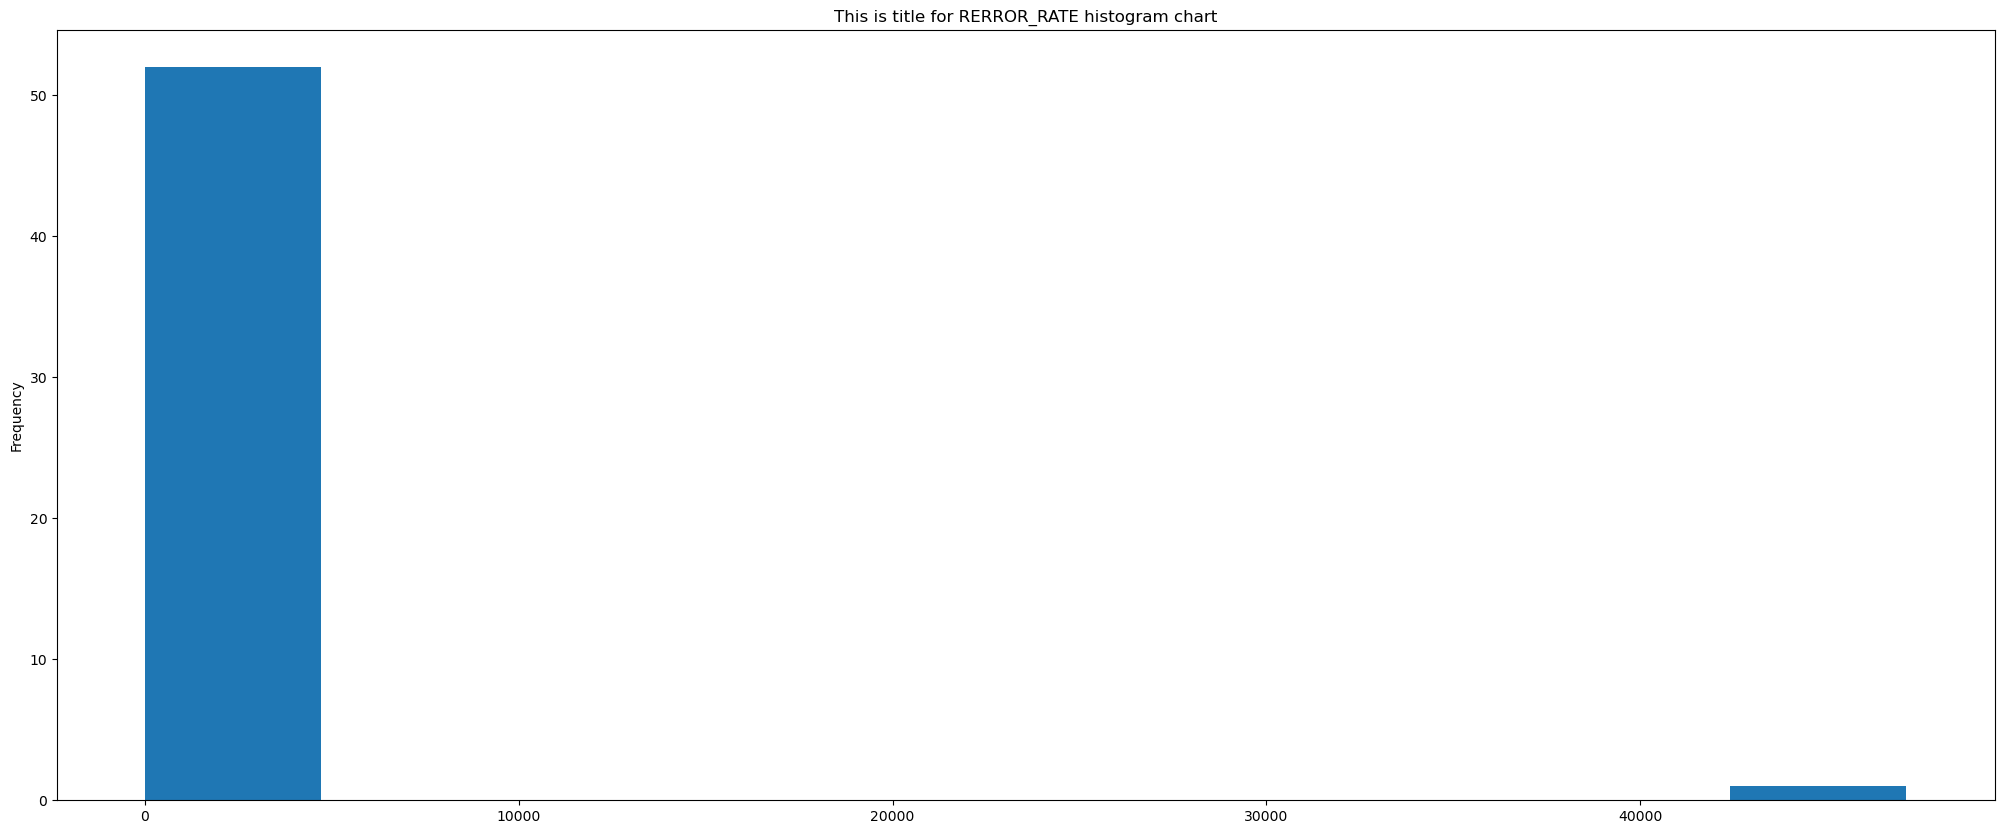

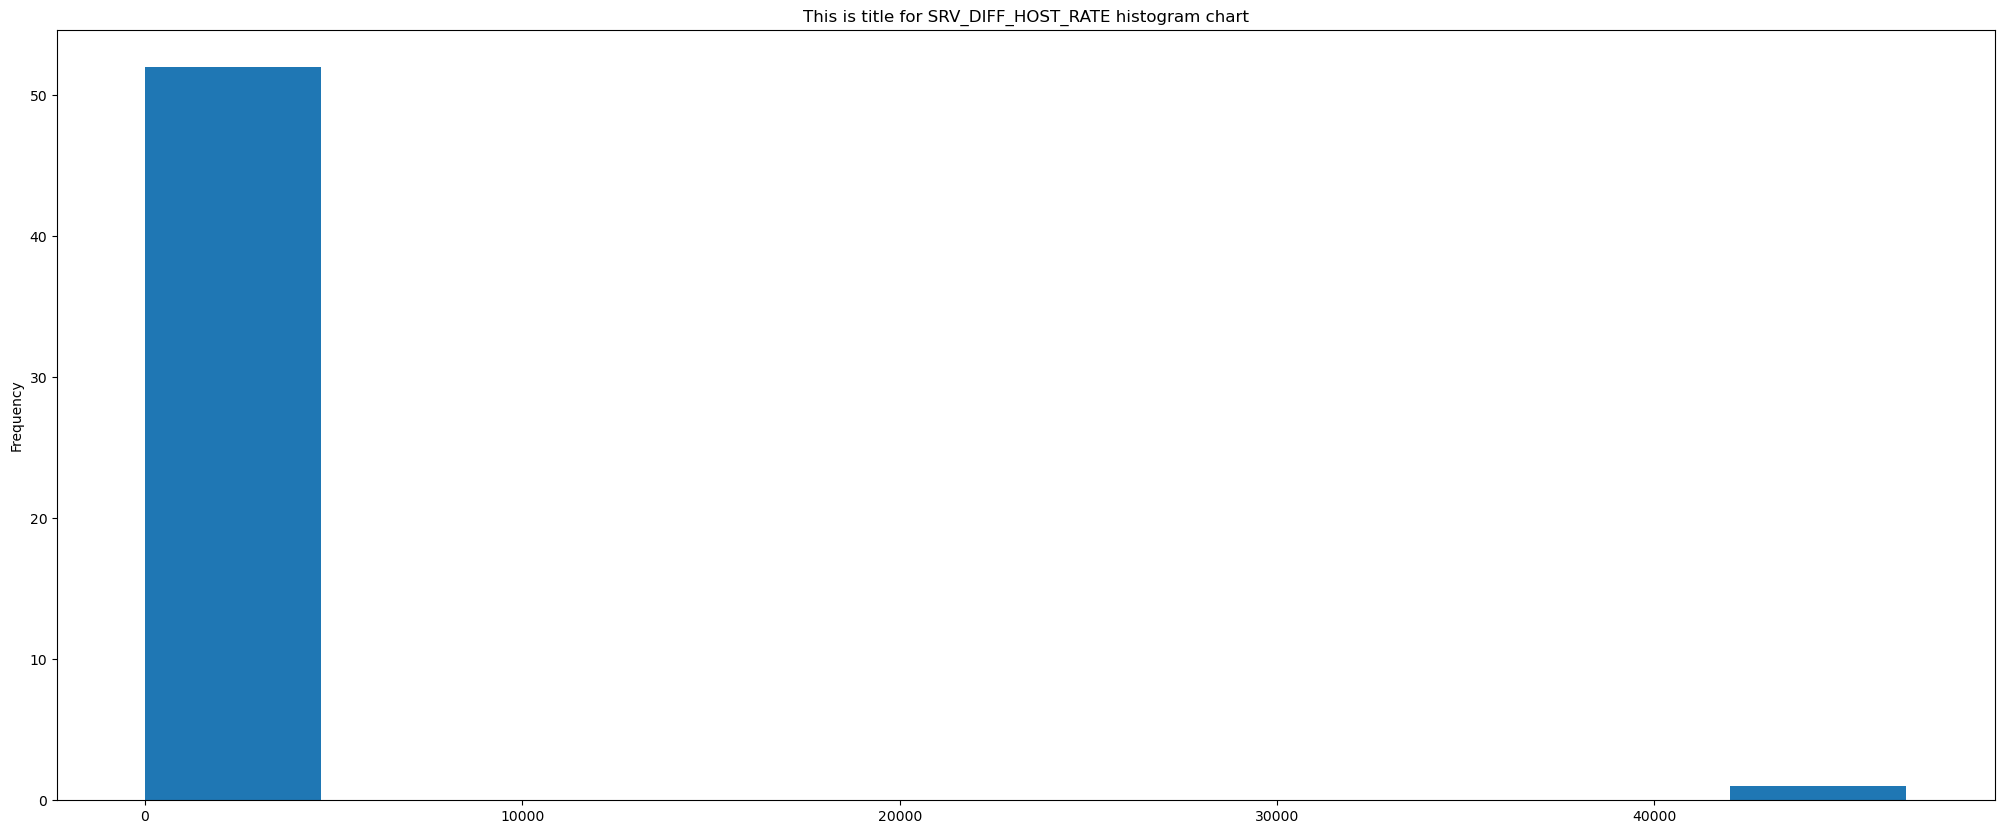

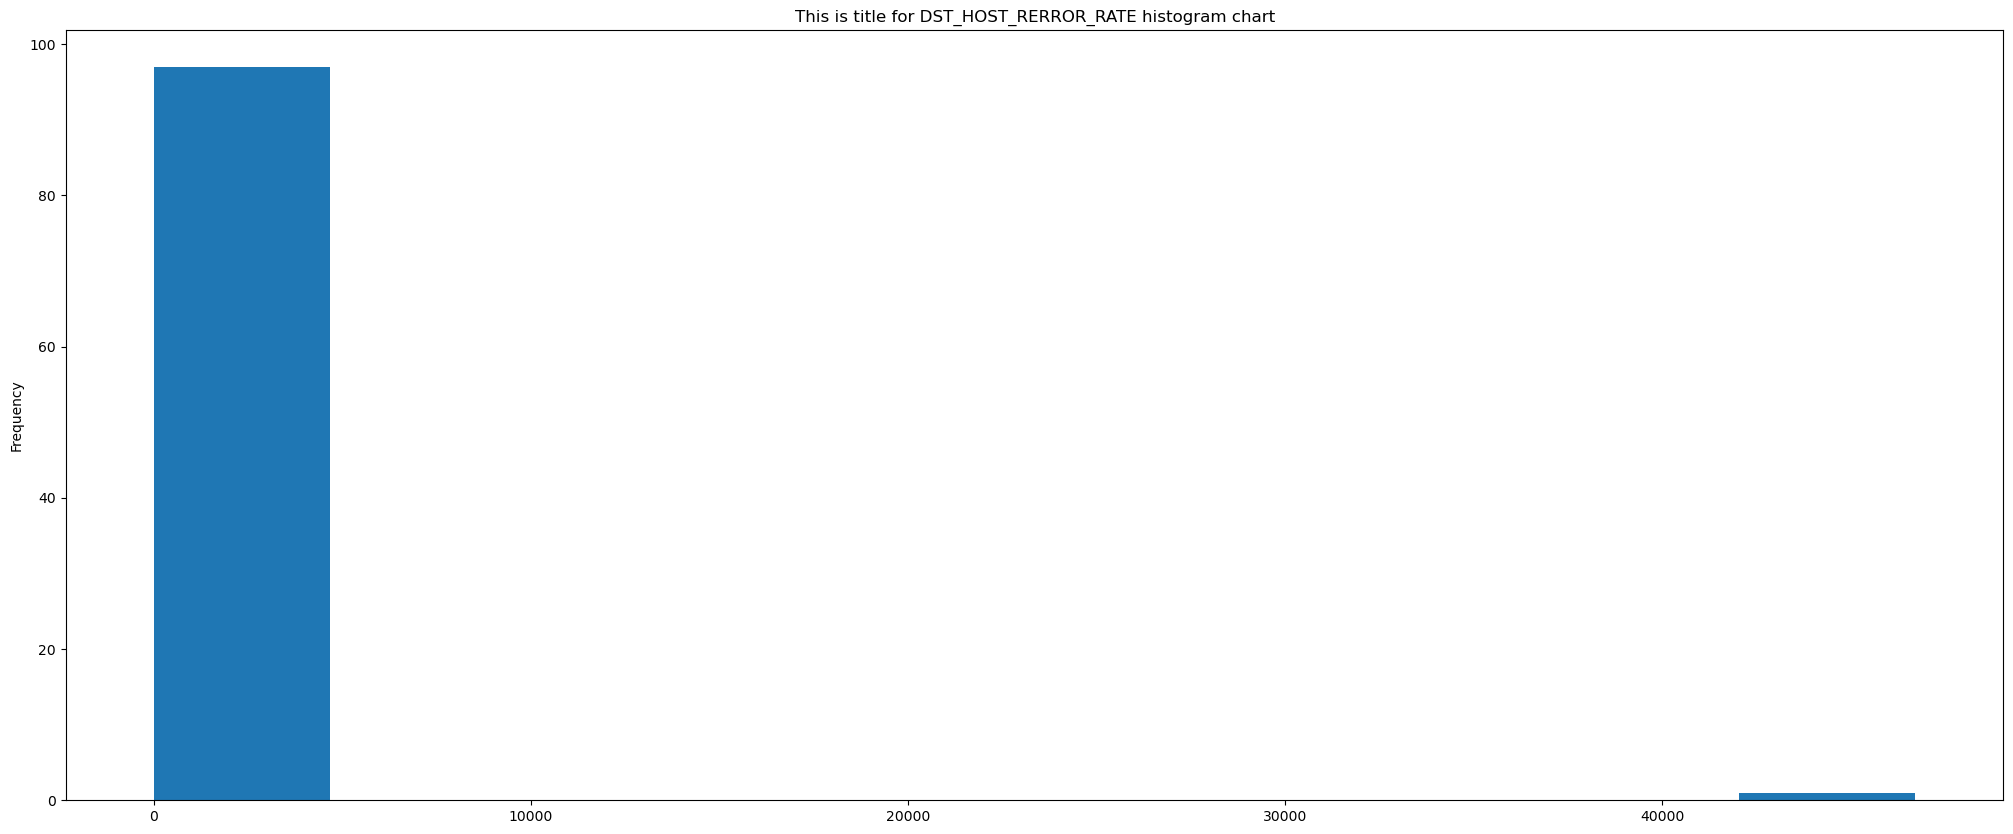

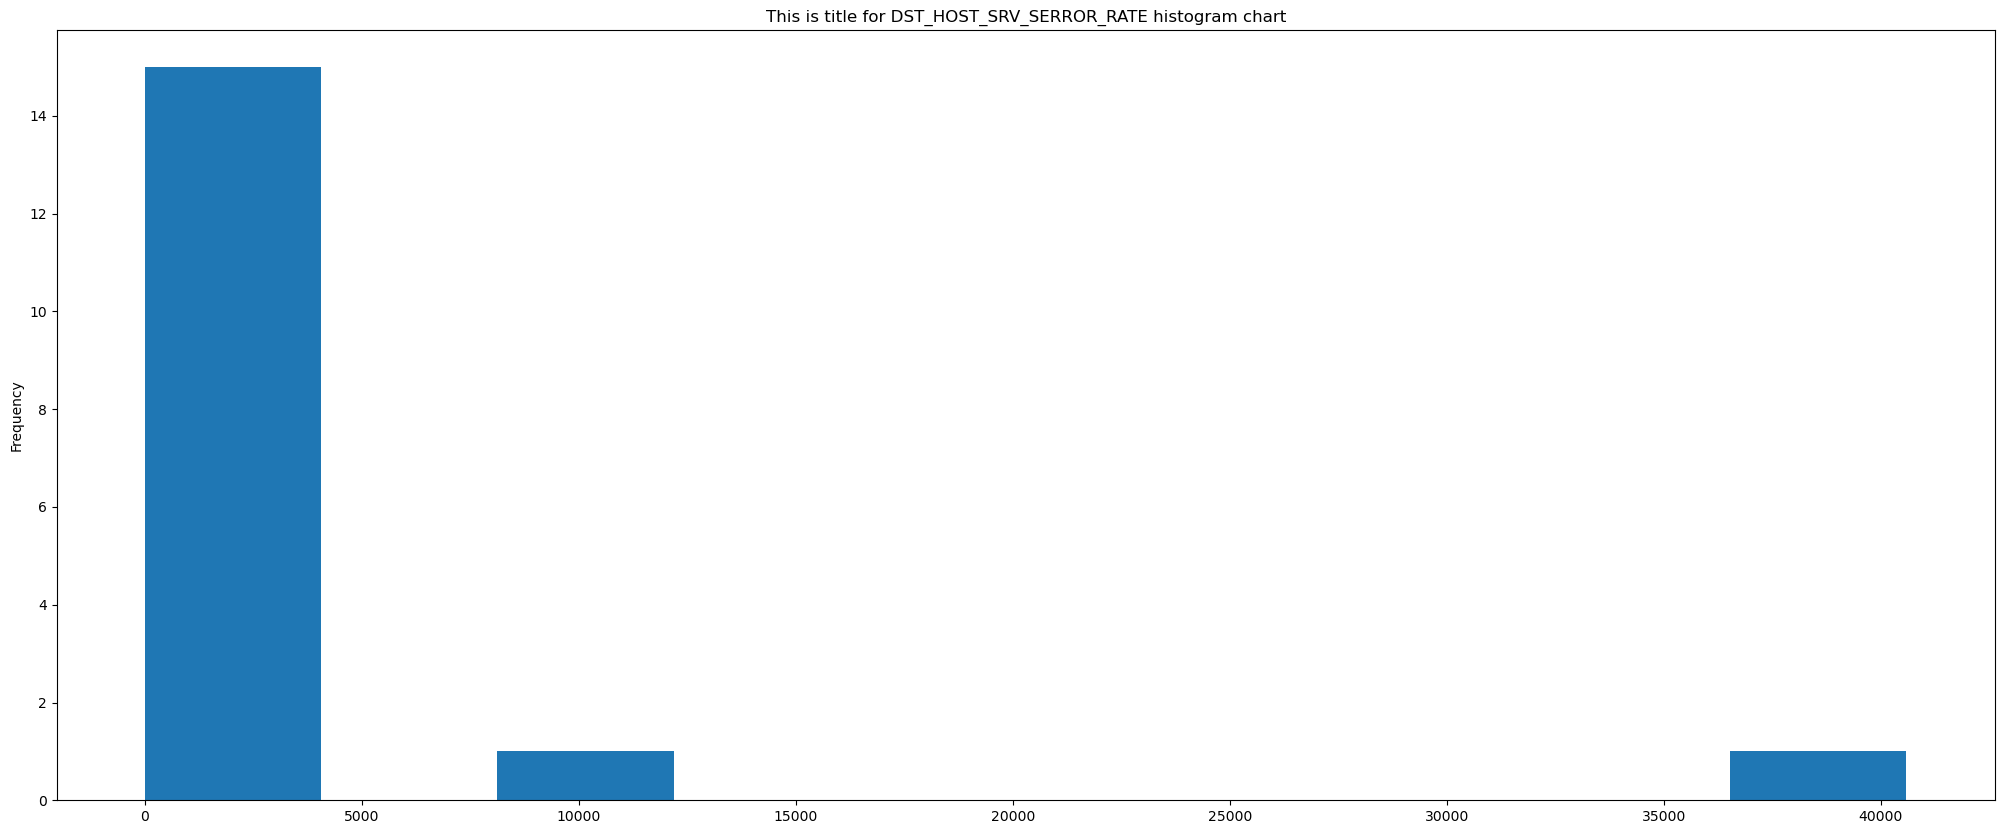

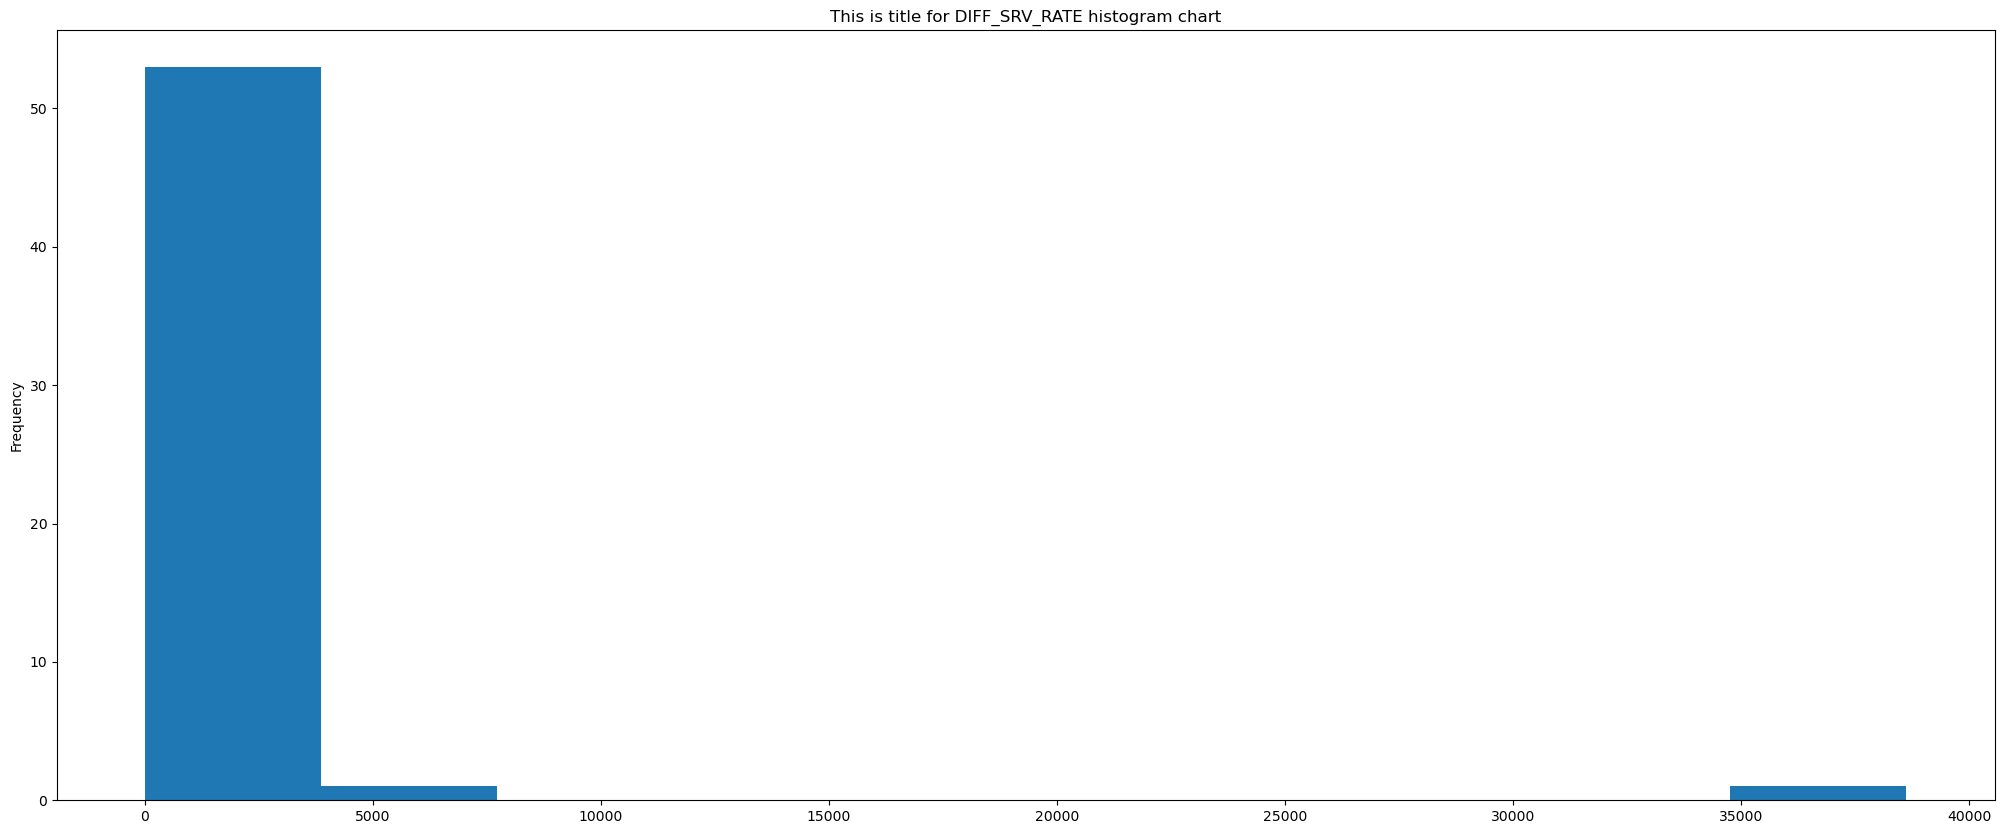

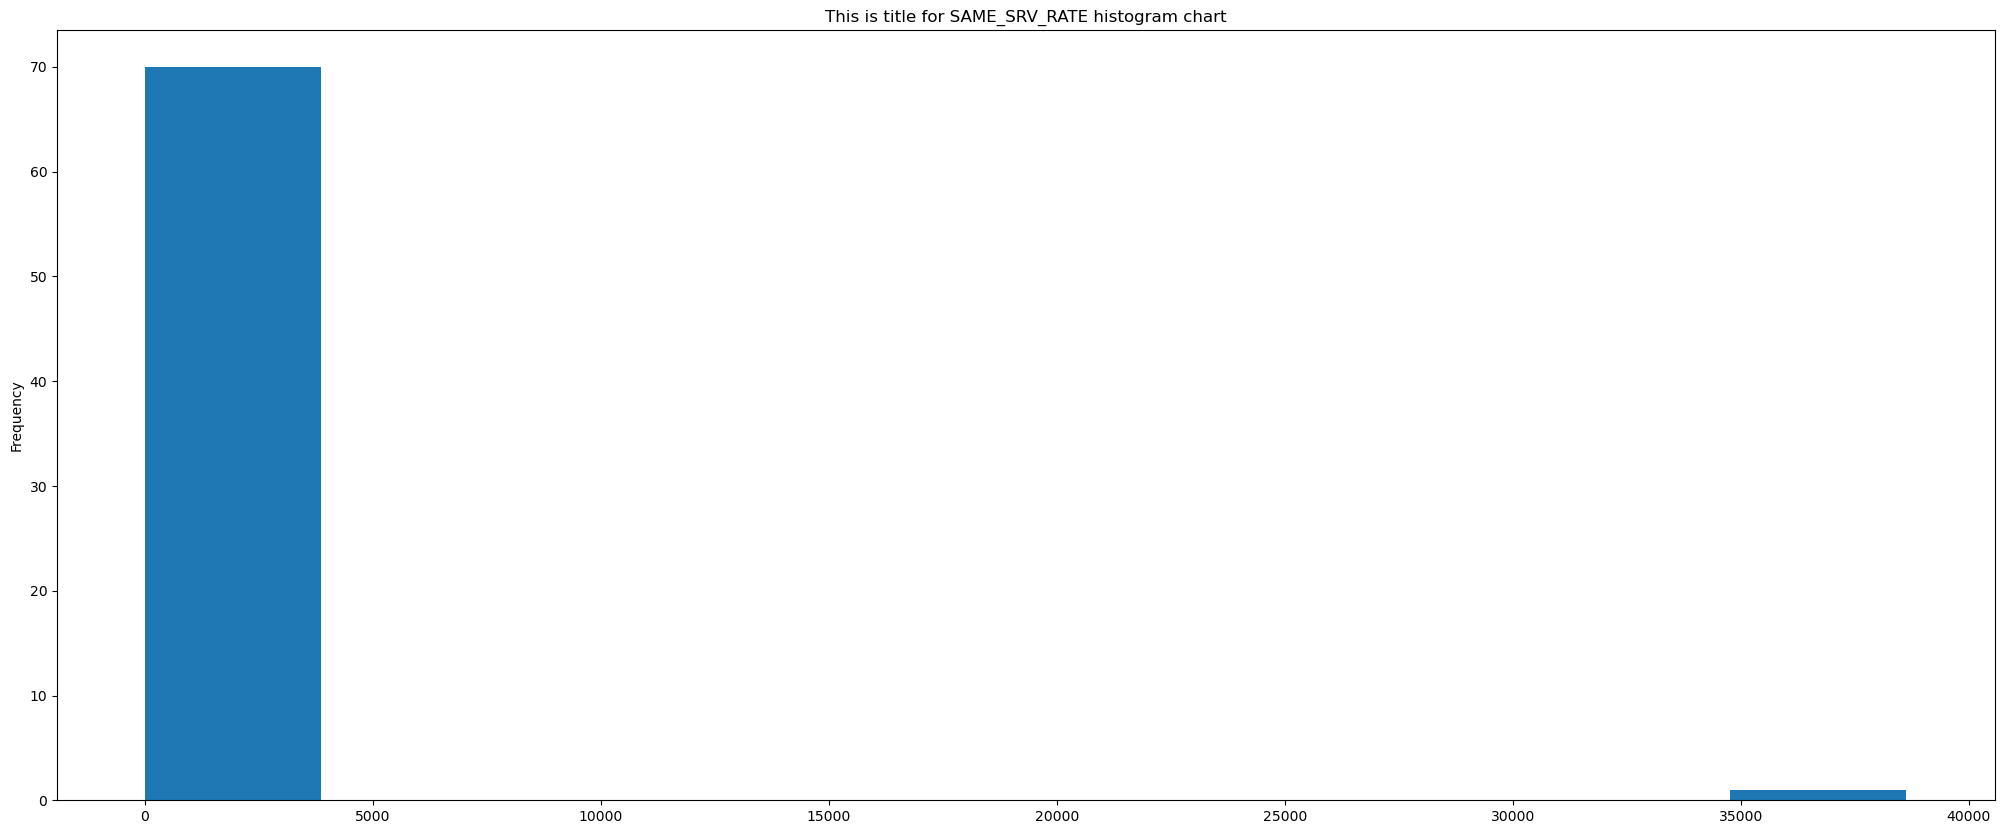

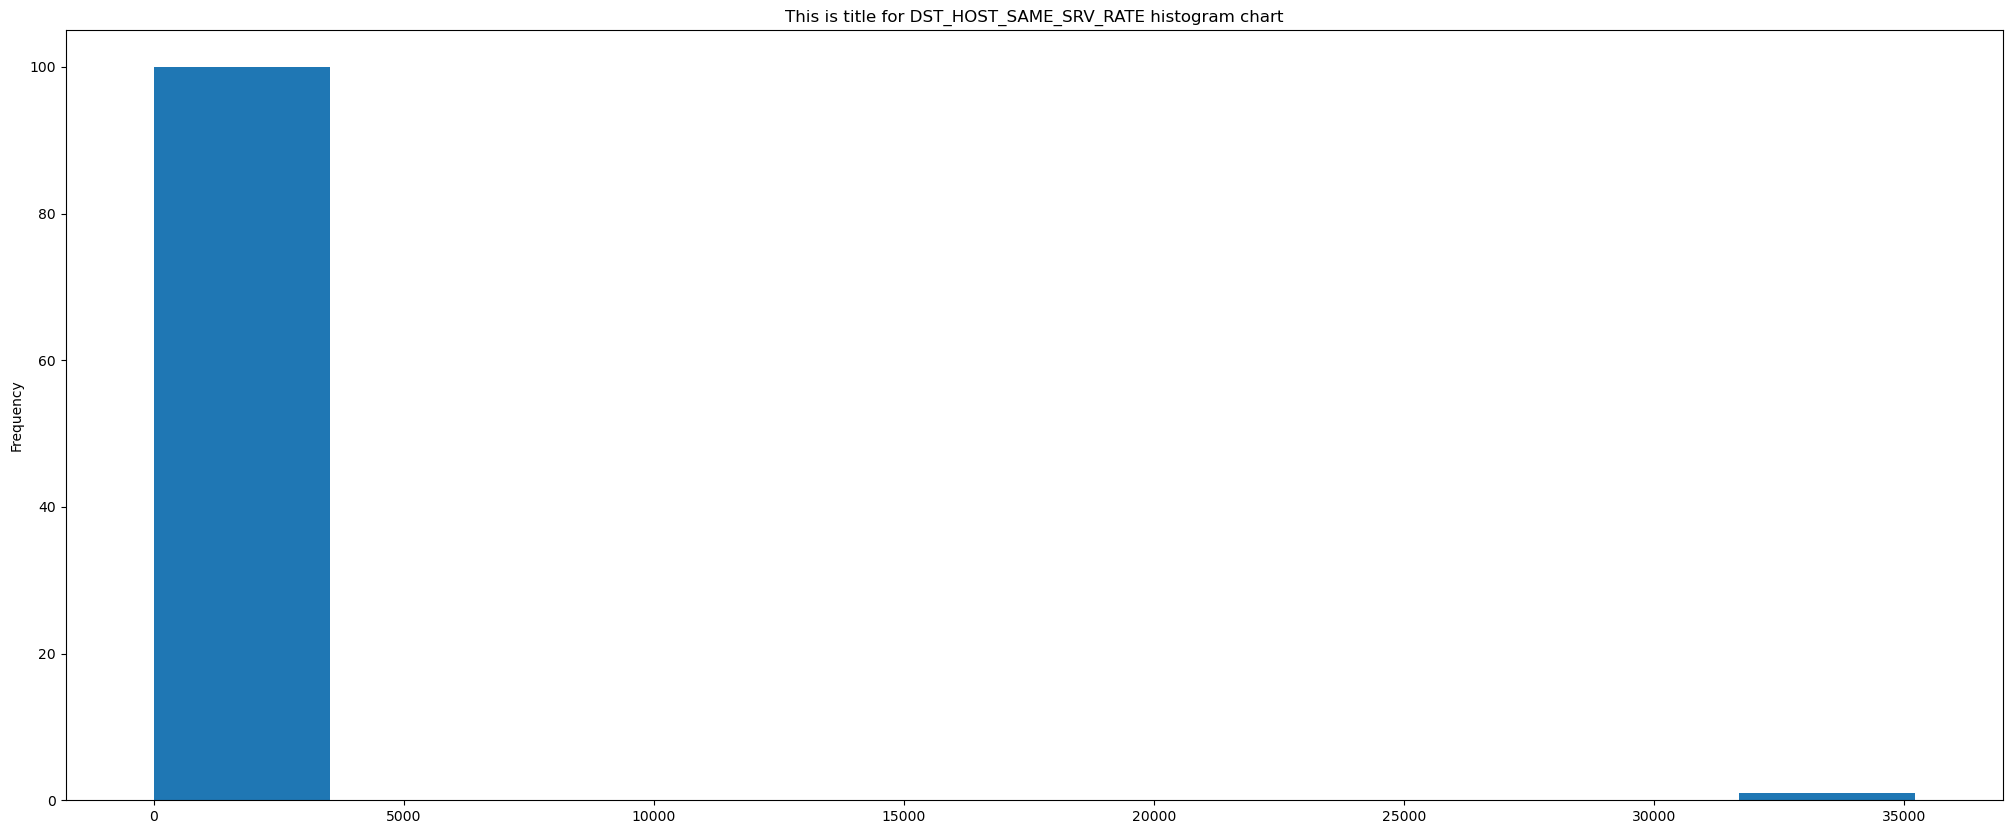

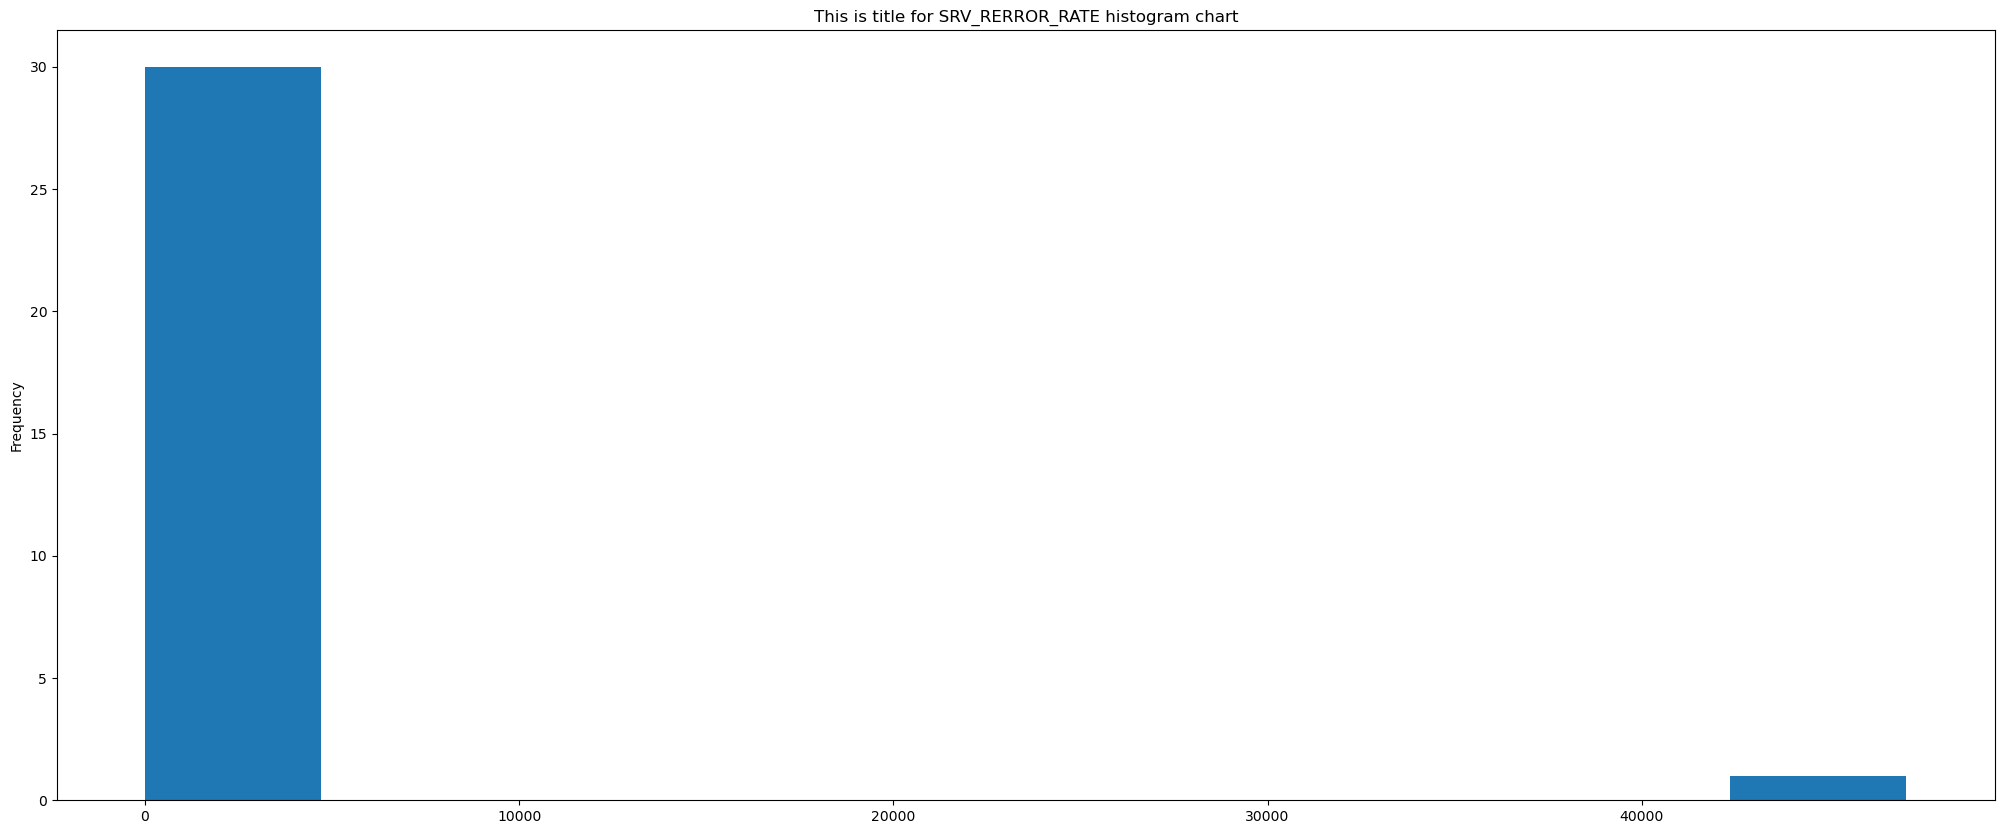

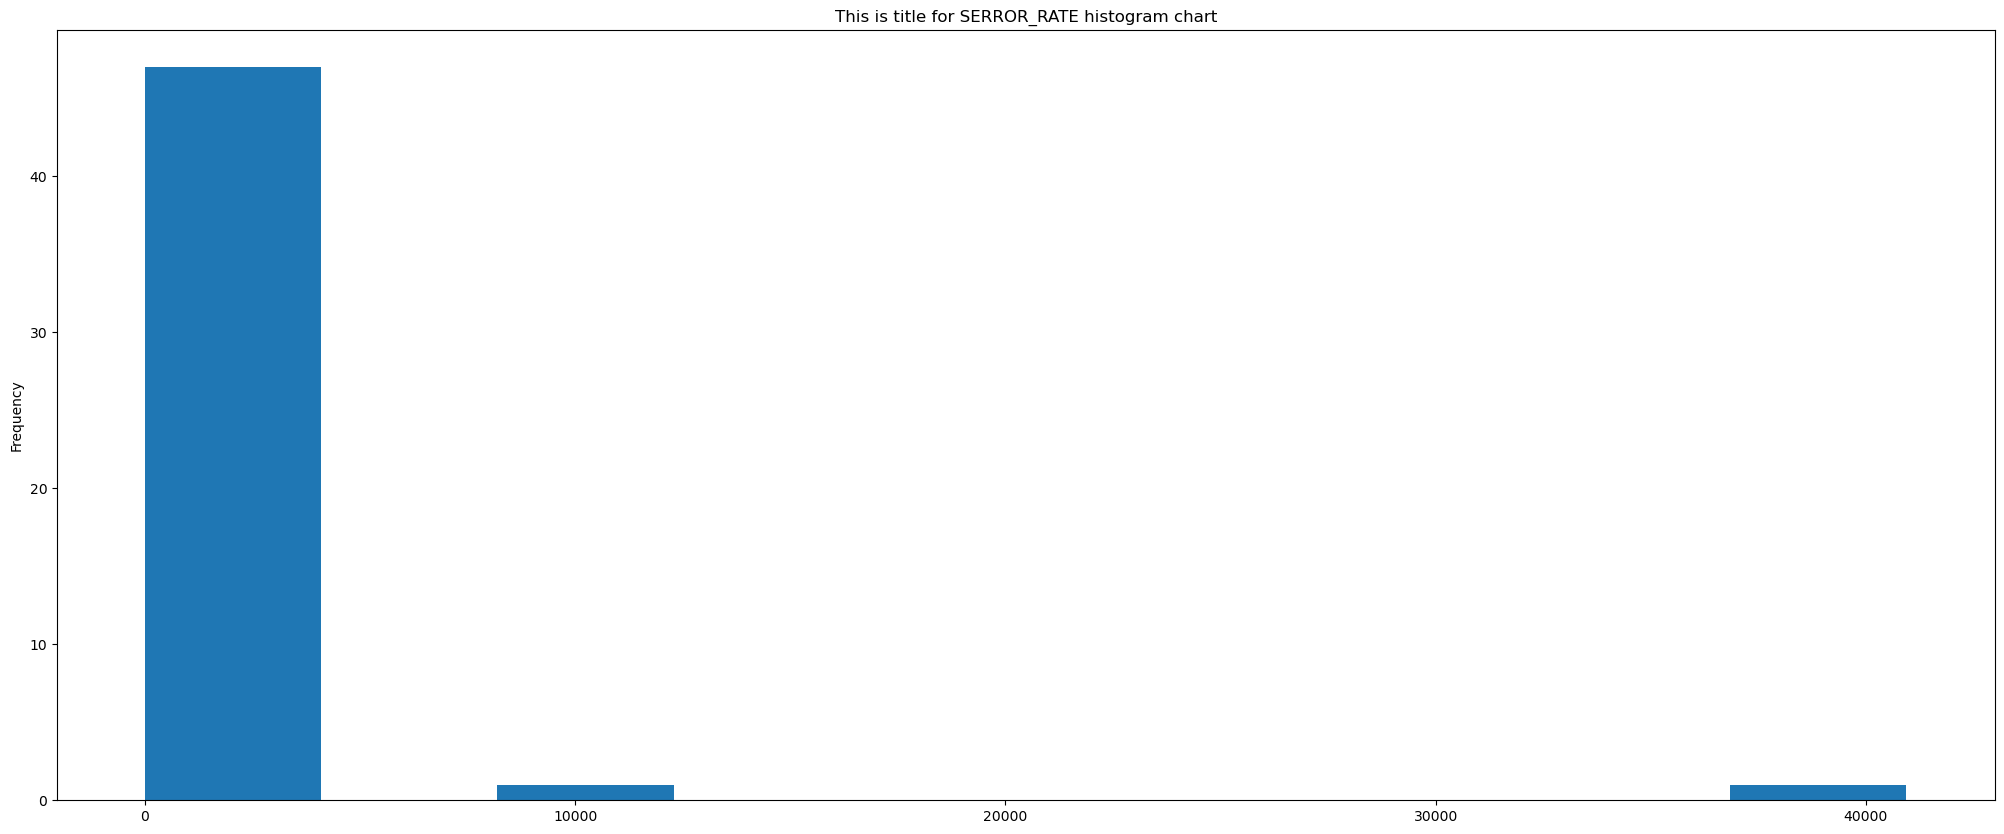

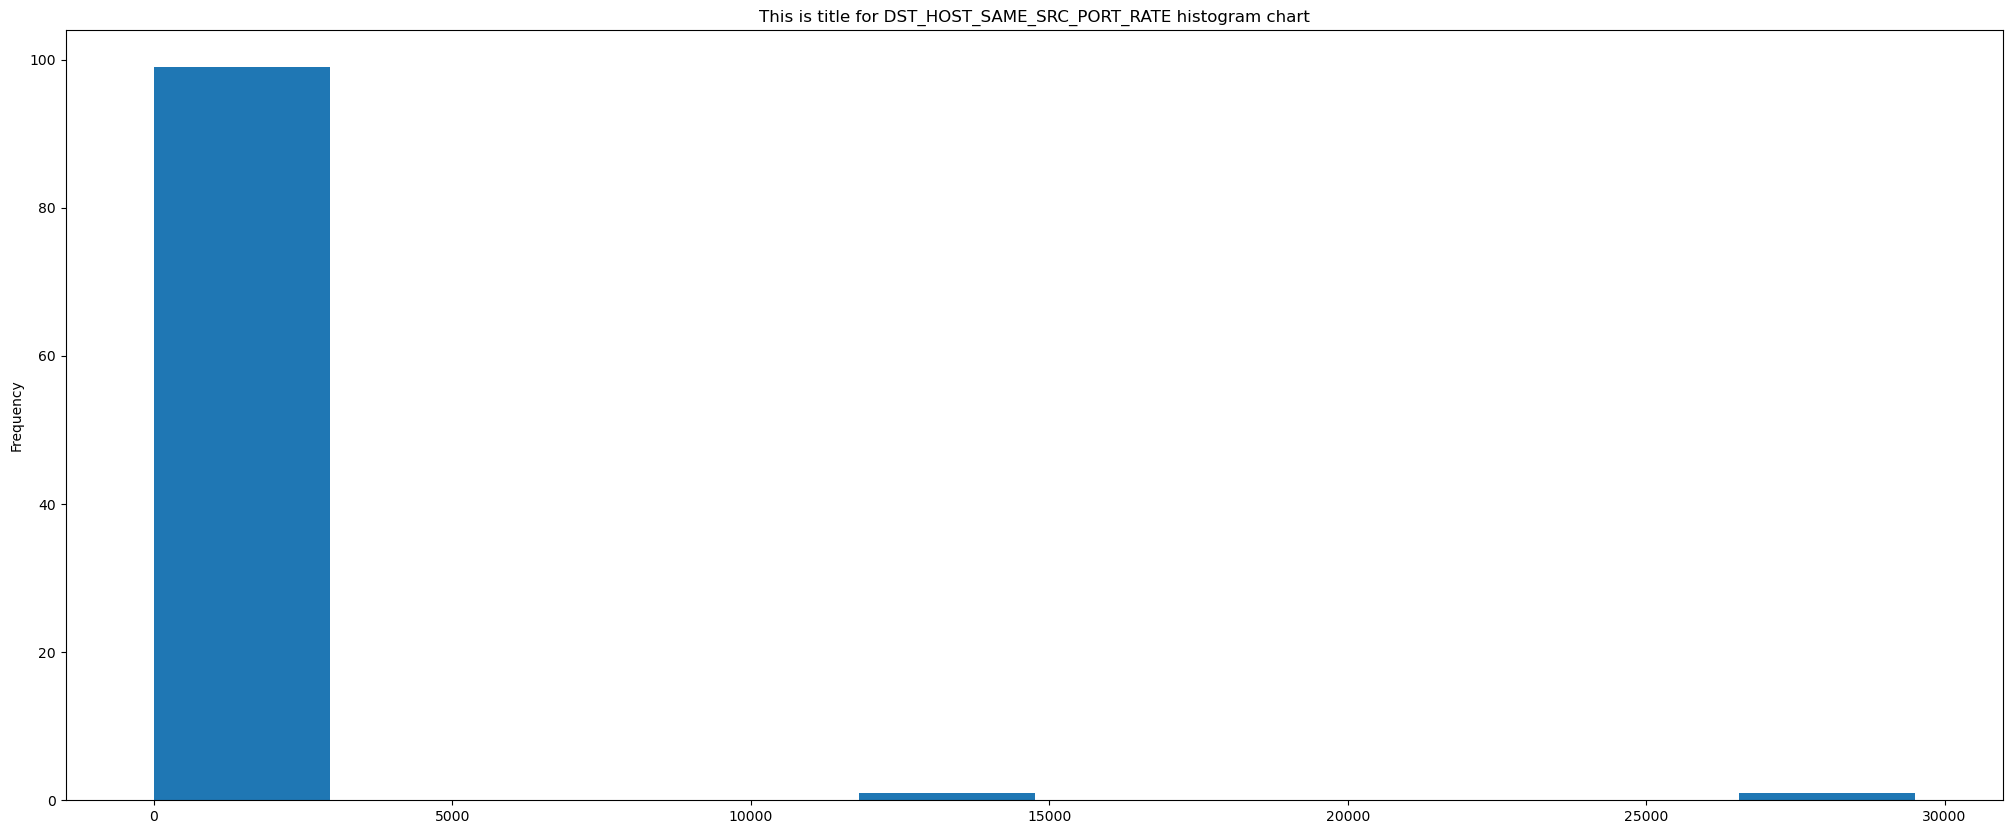

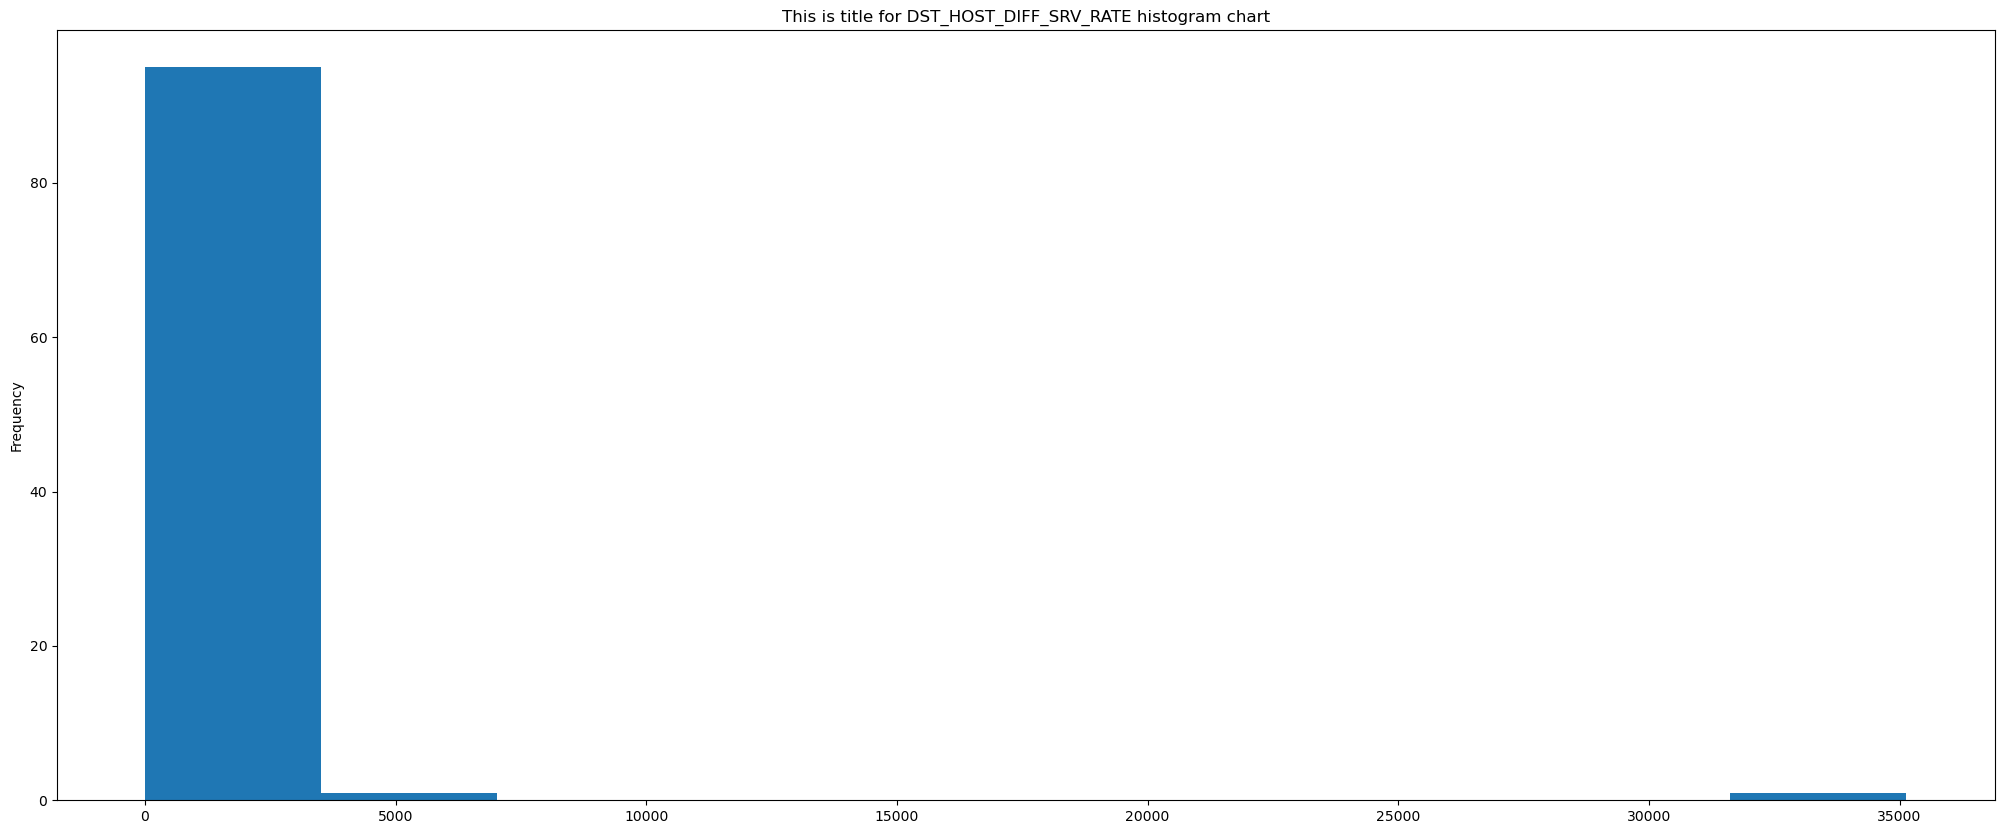

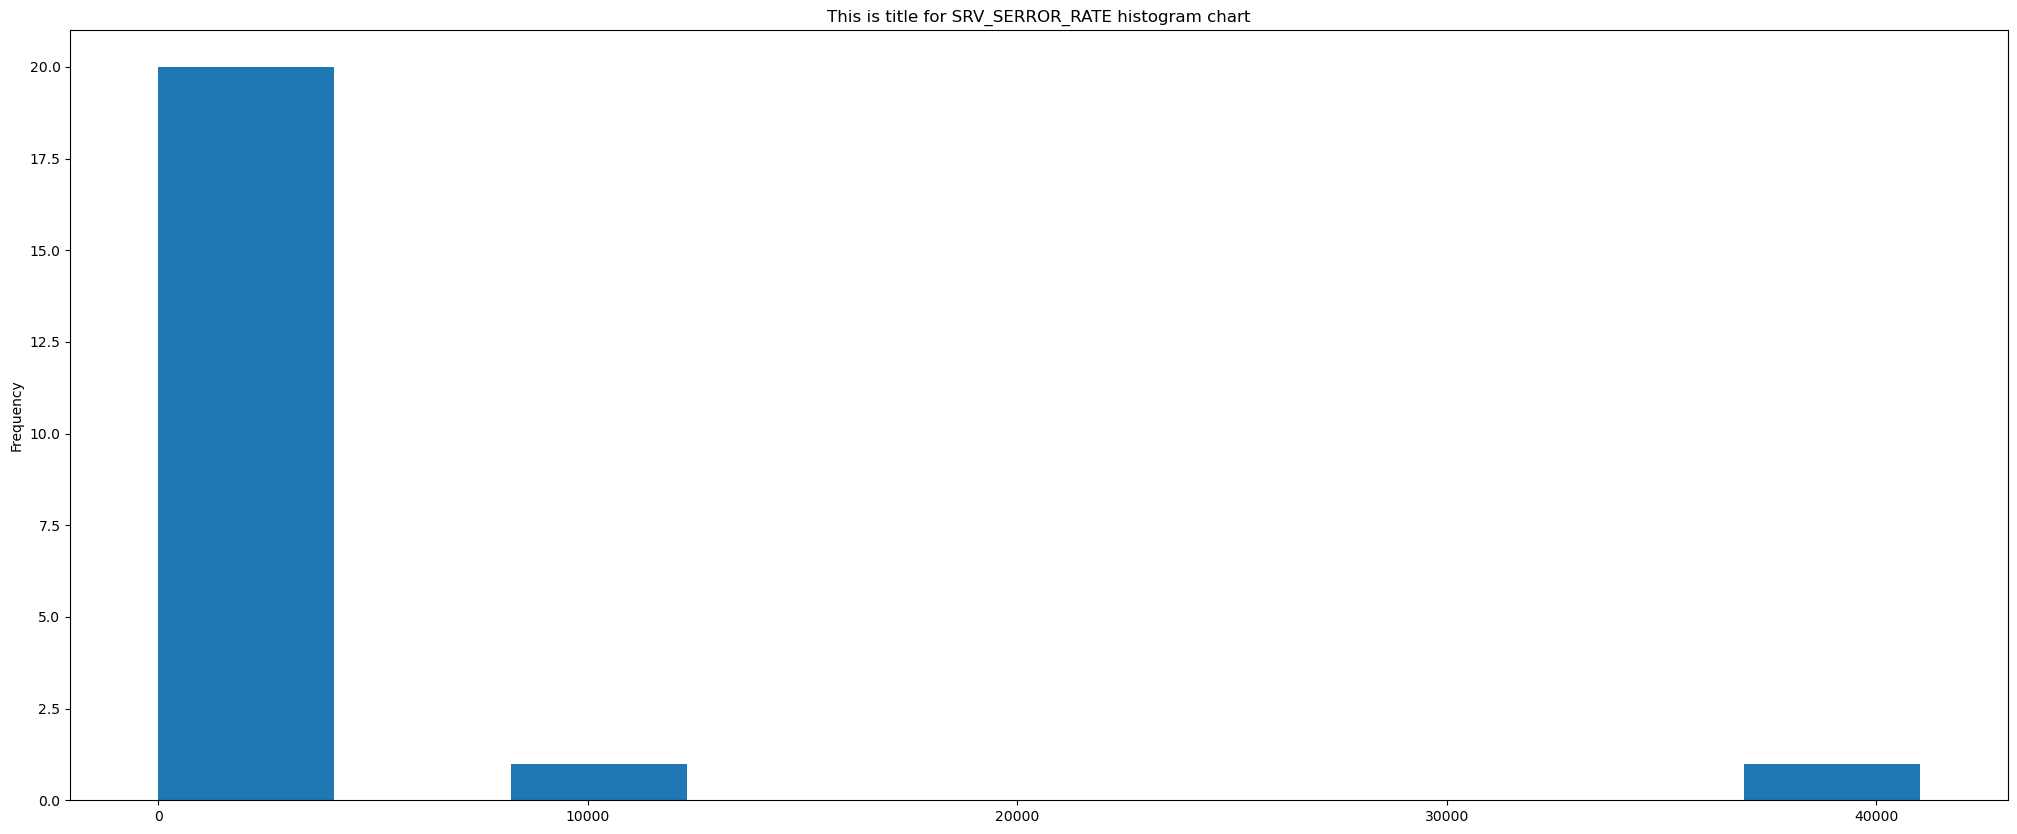

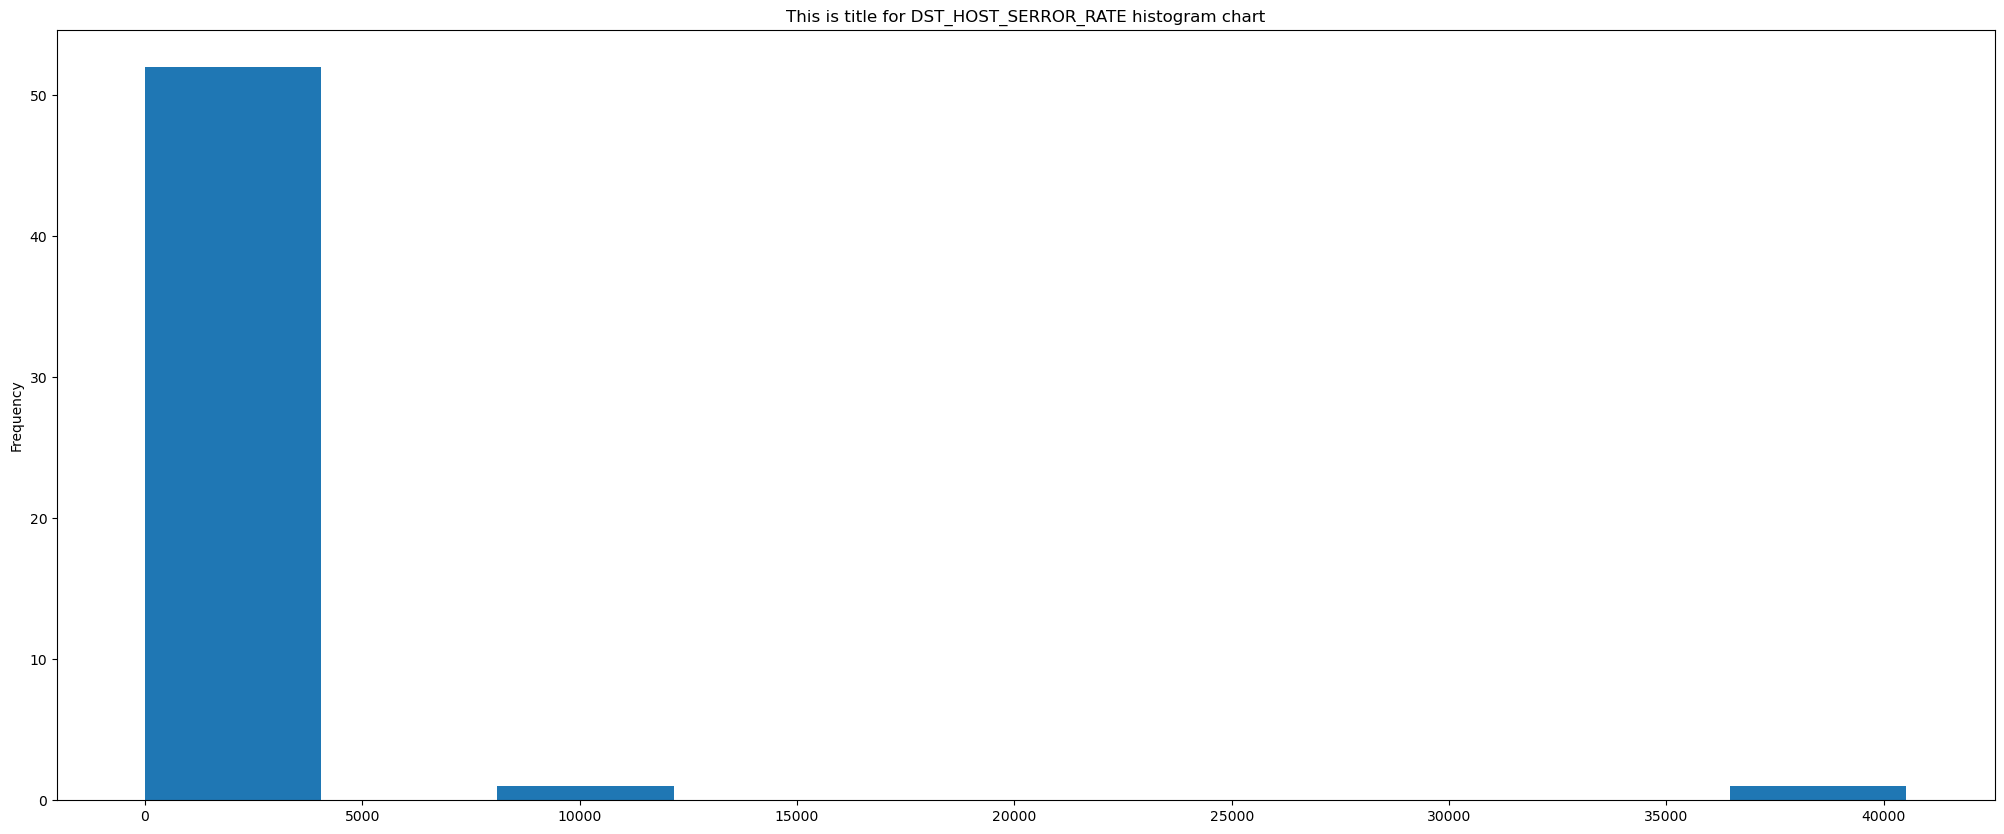

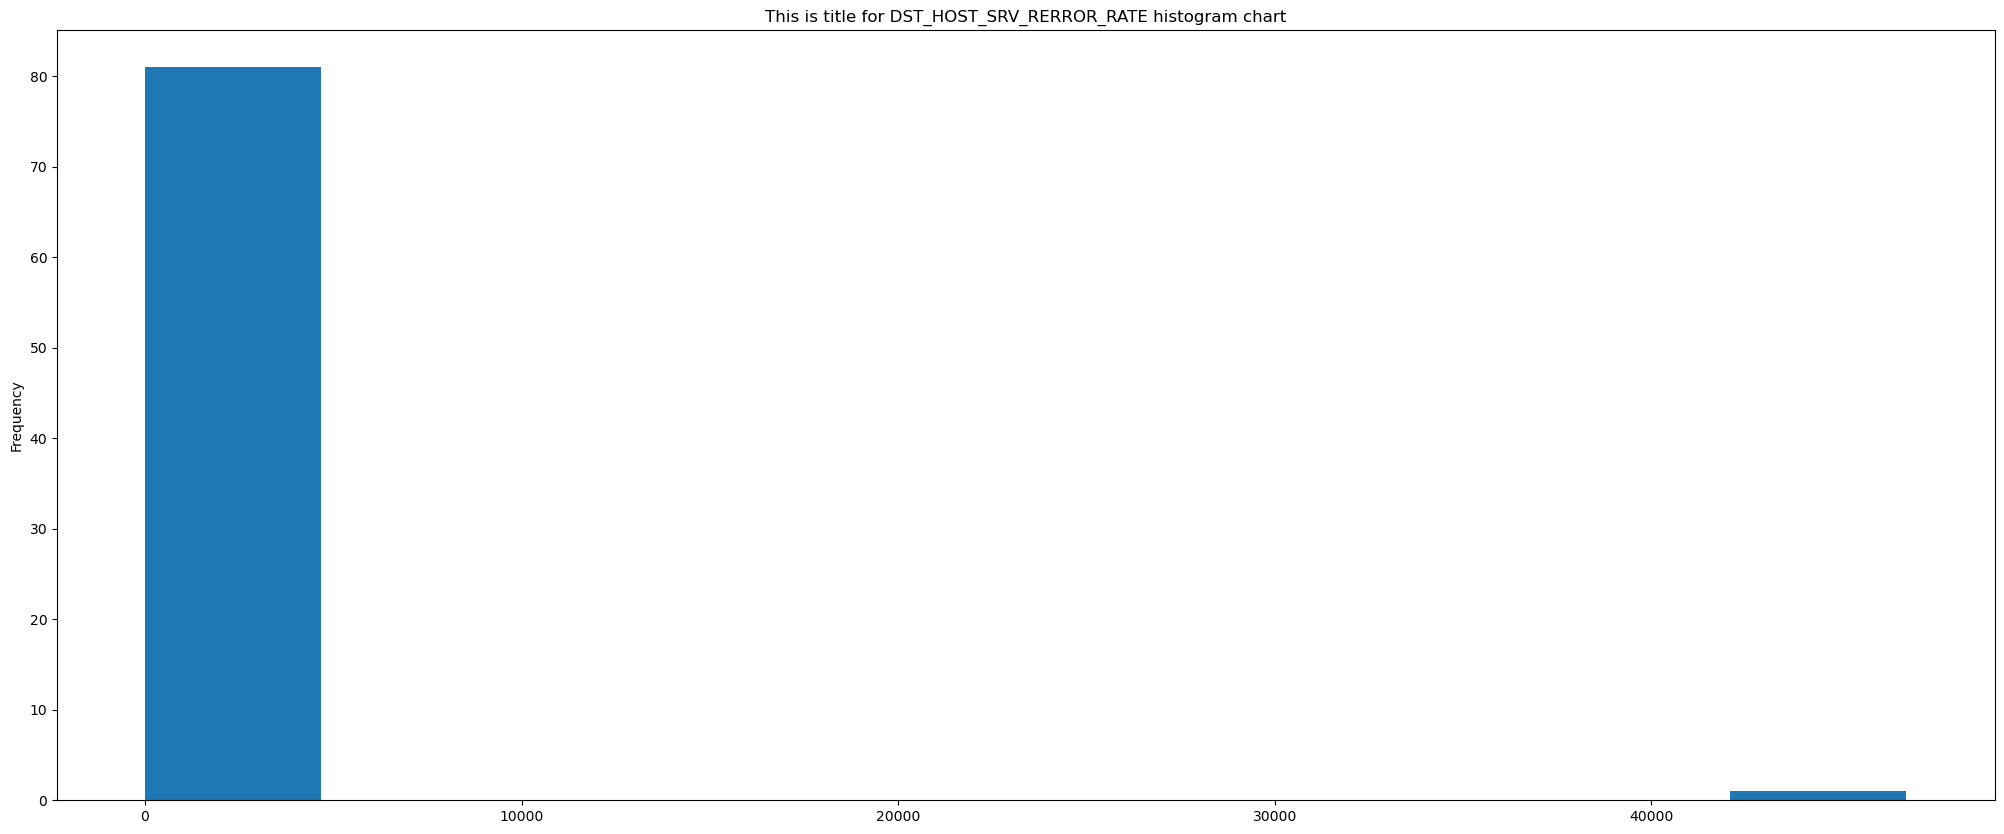

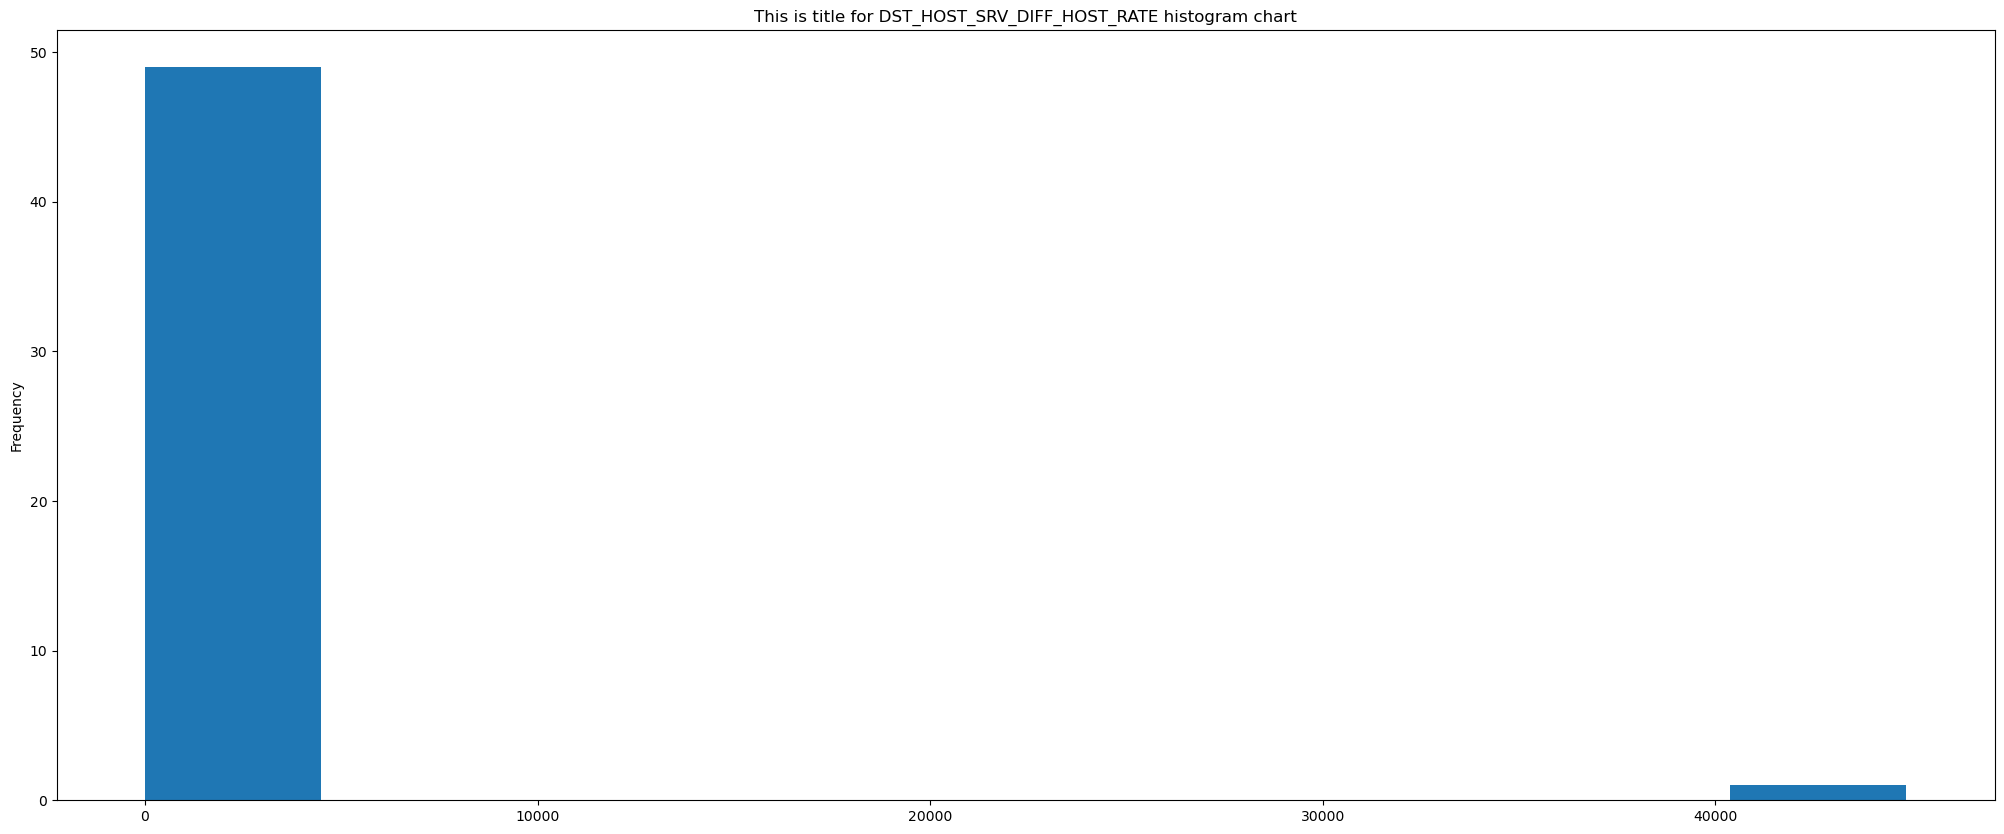

In [41]:
show_histogram_plots_for_all_continuous_plots(eda_kdd_cup_df, eda_kdd_cup_99_continuous_features)

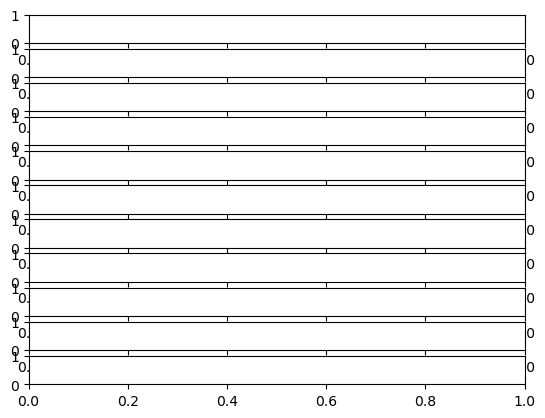

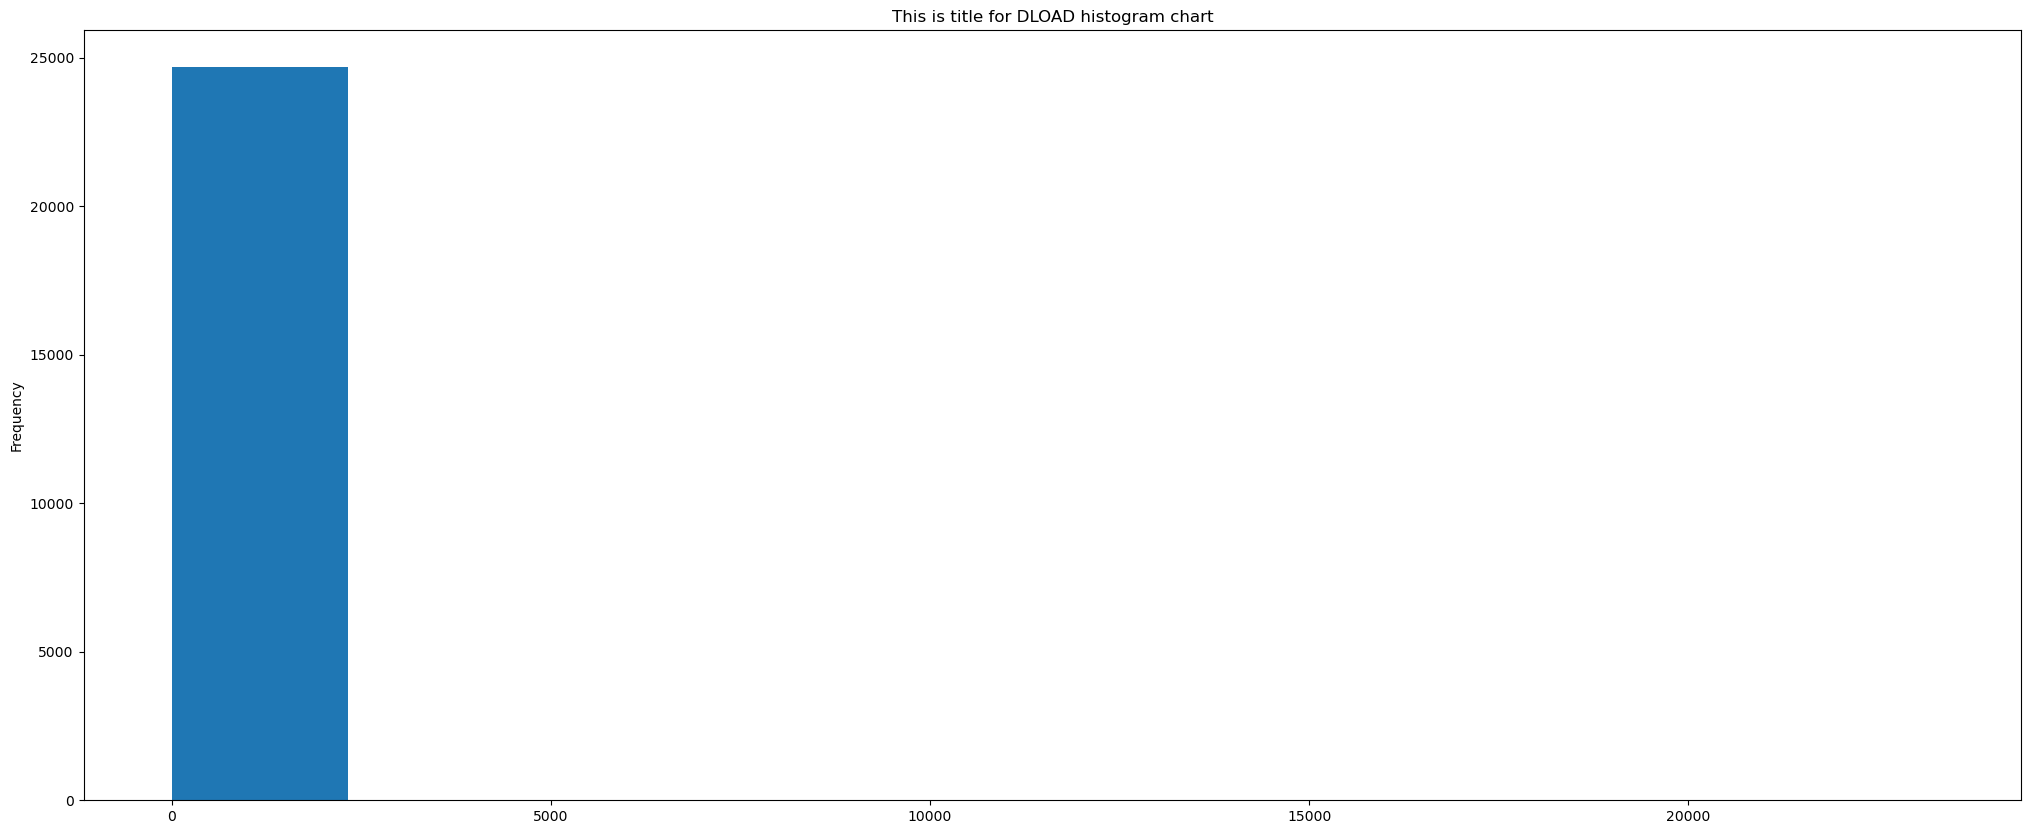

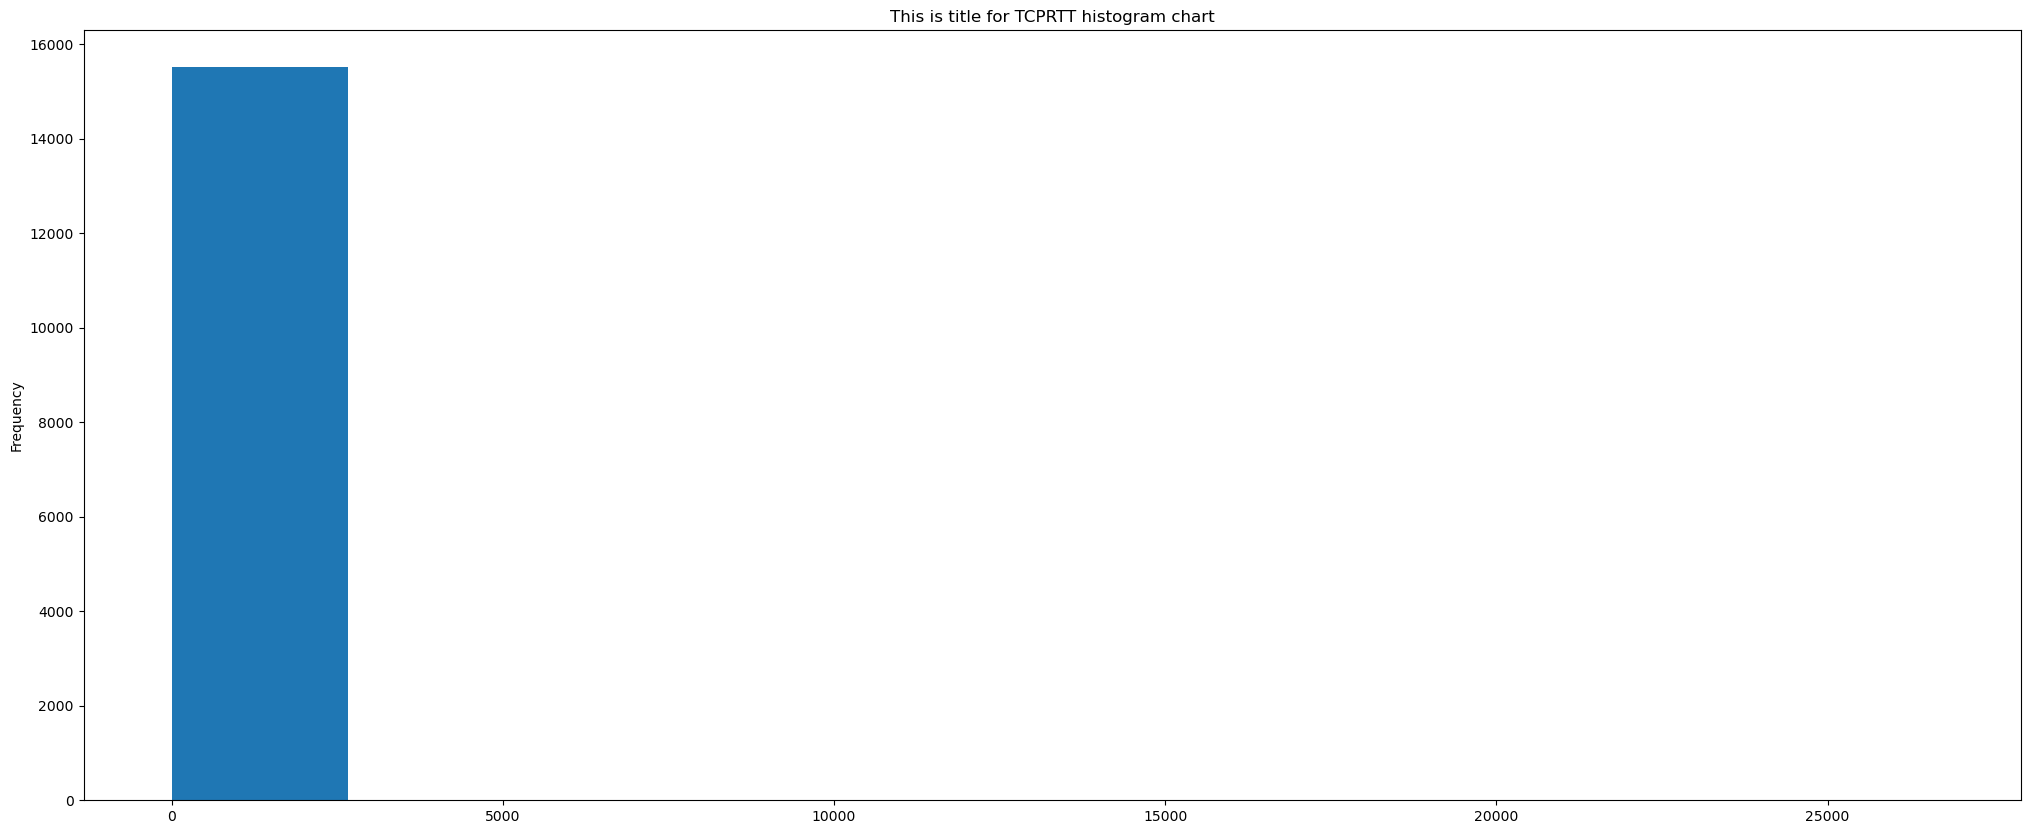

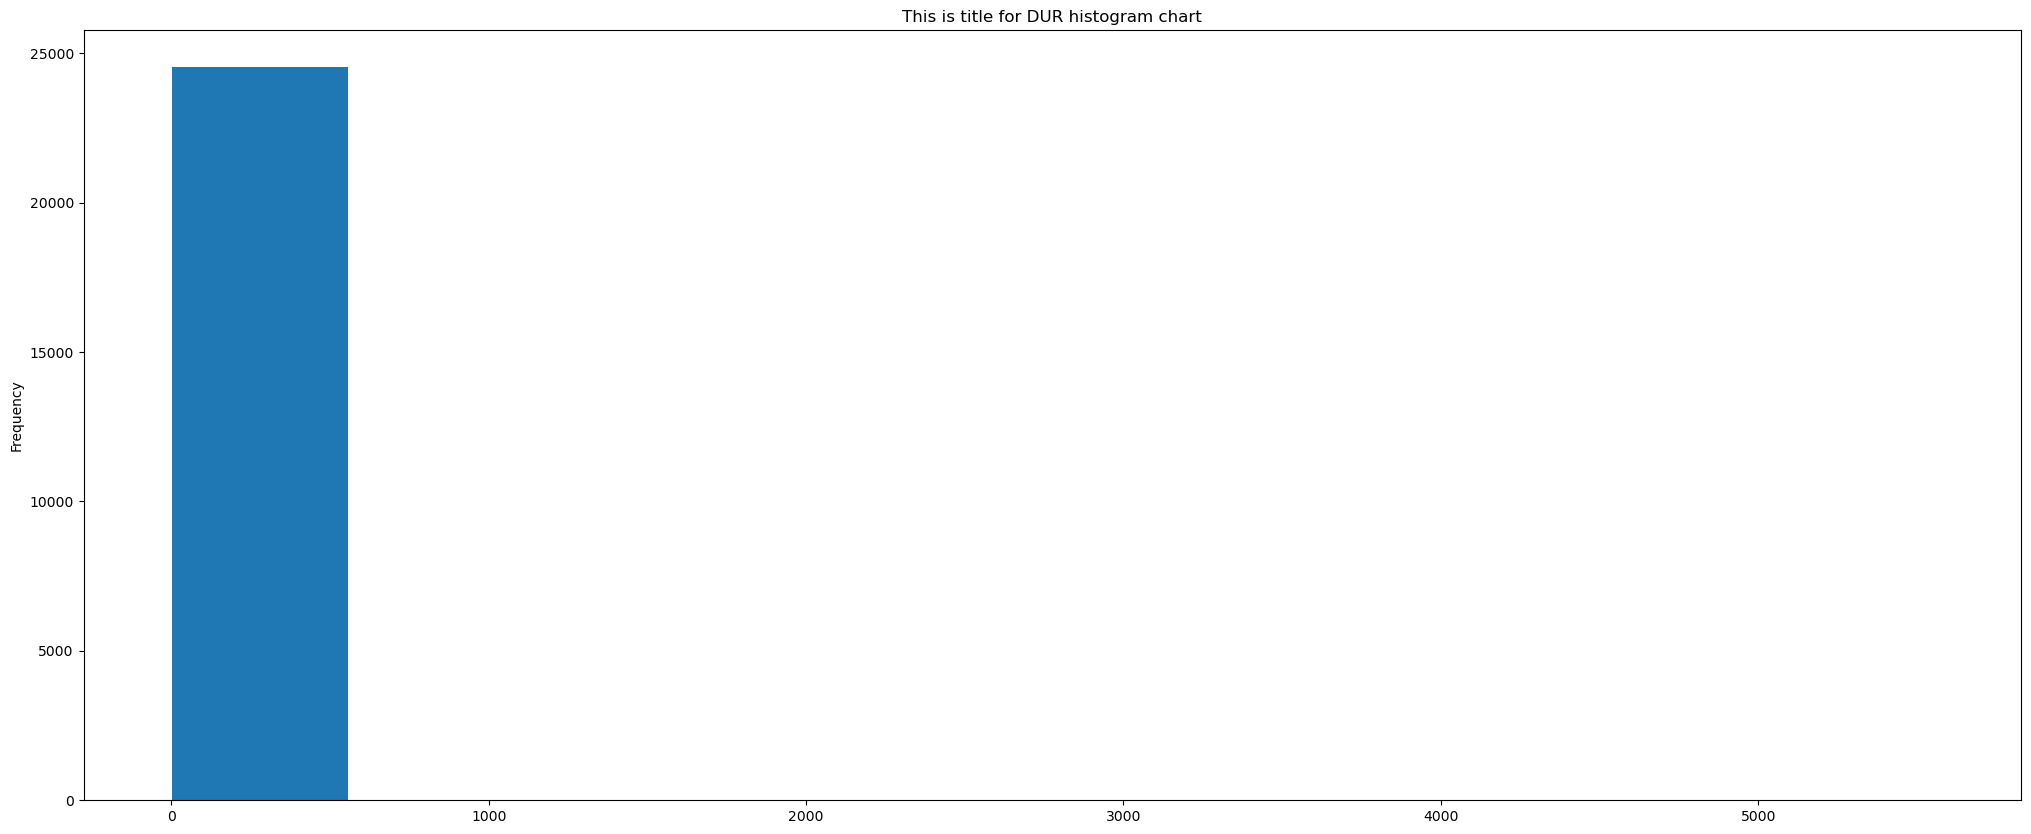

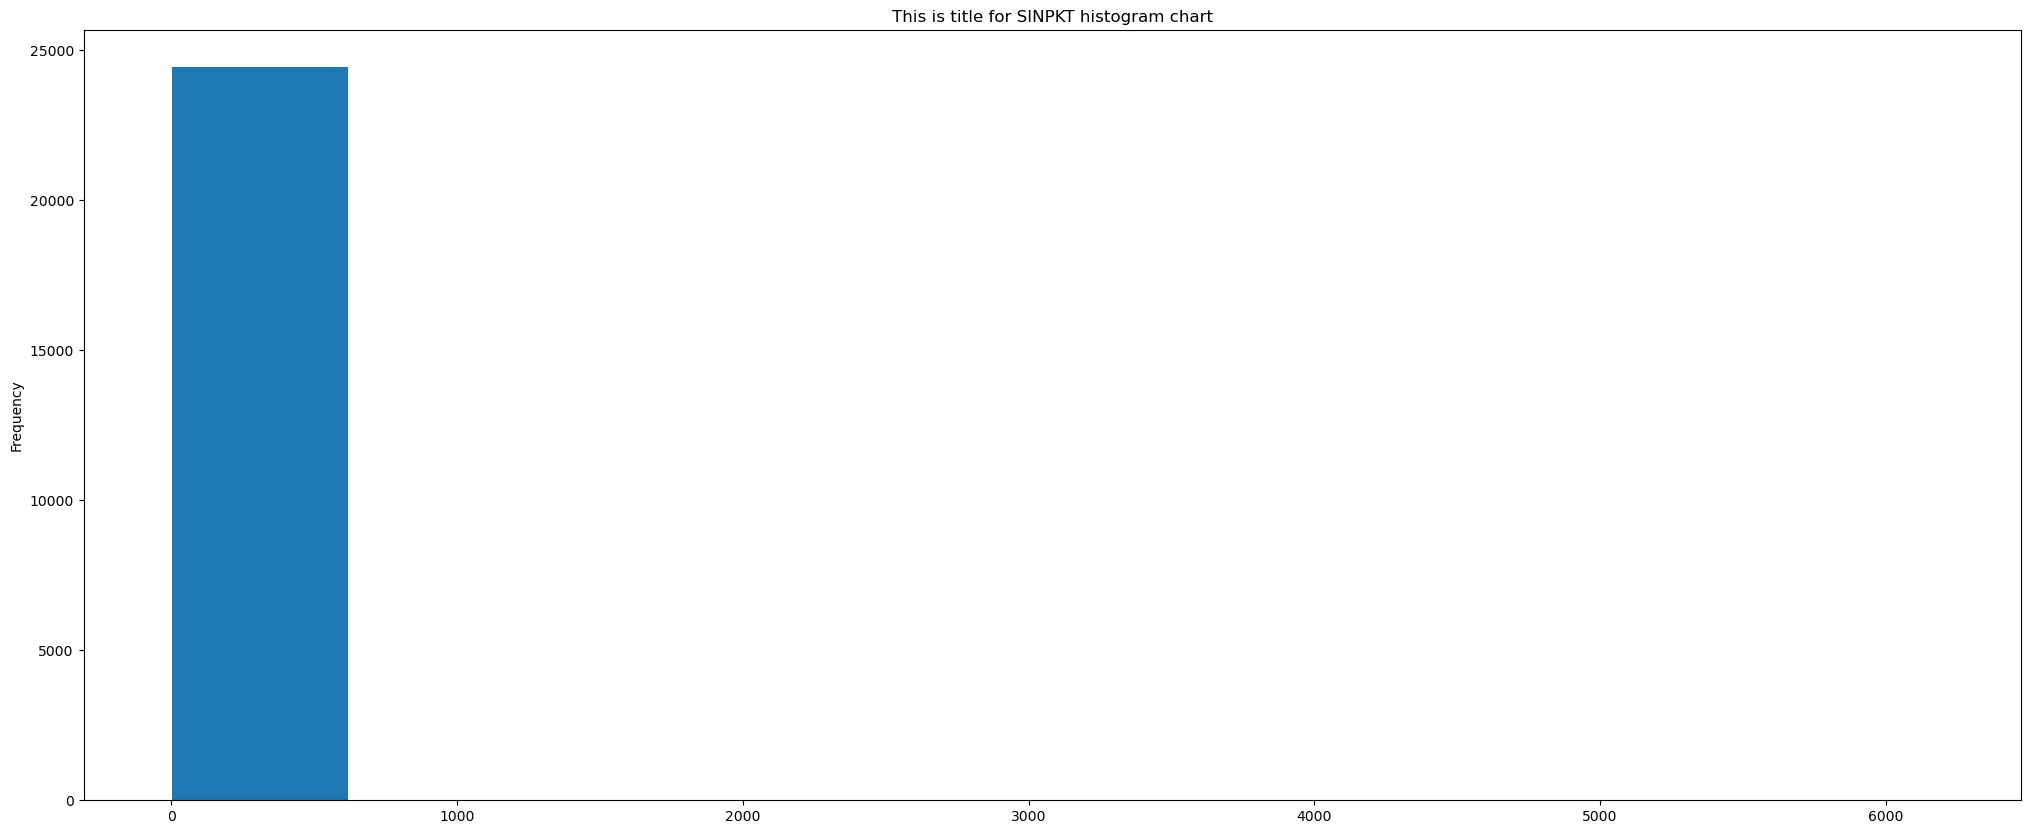

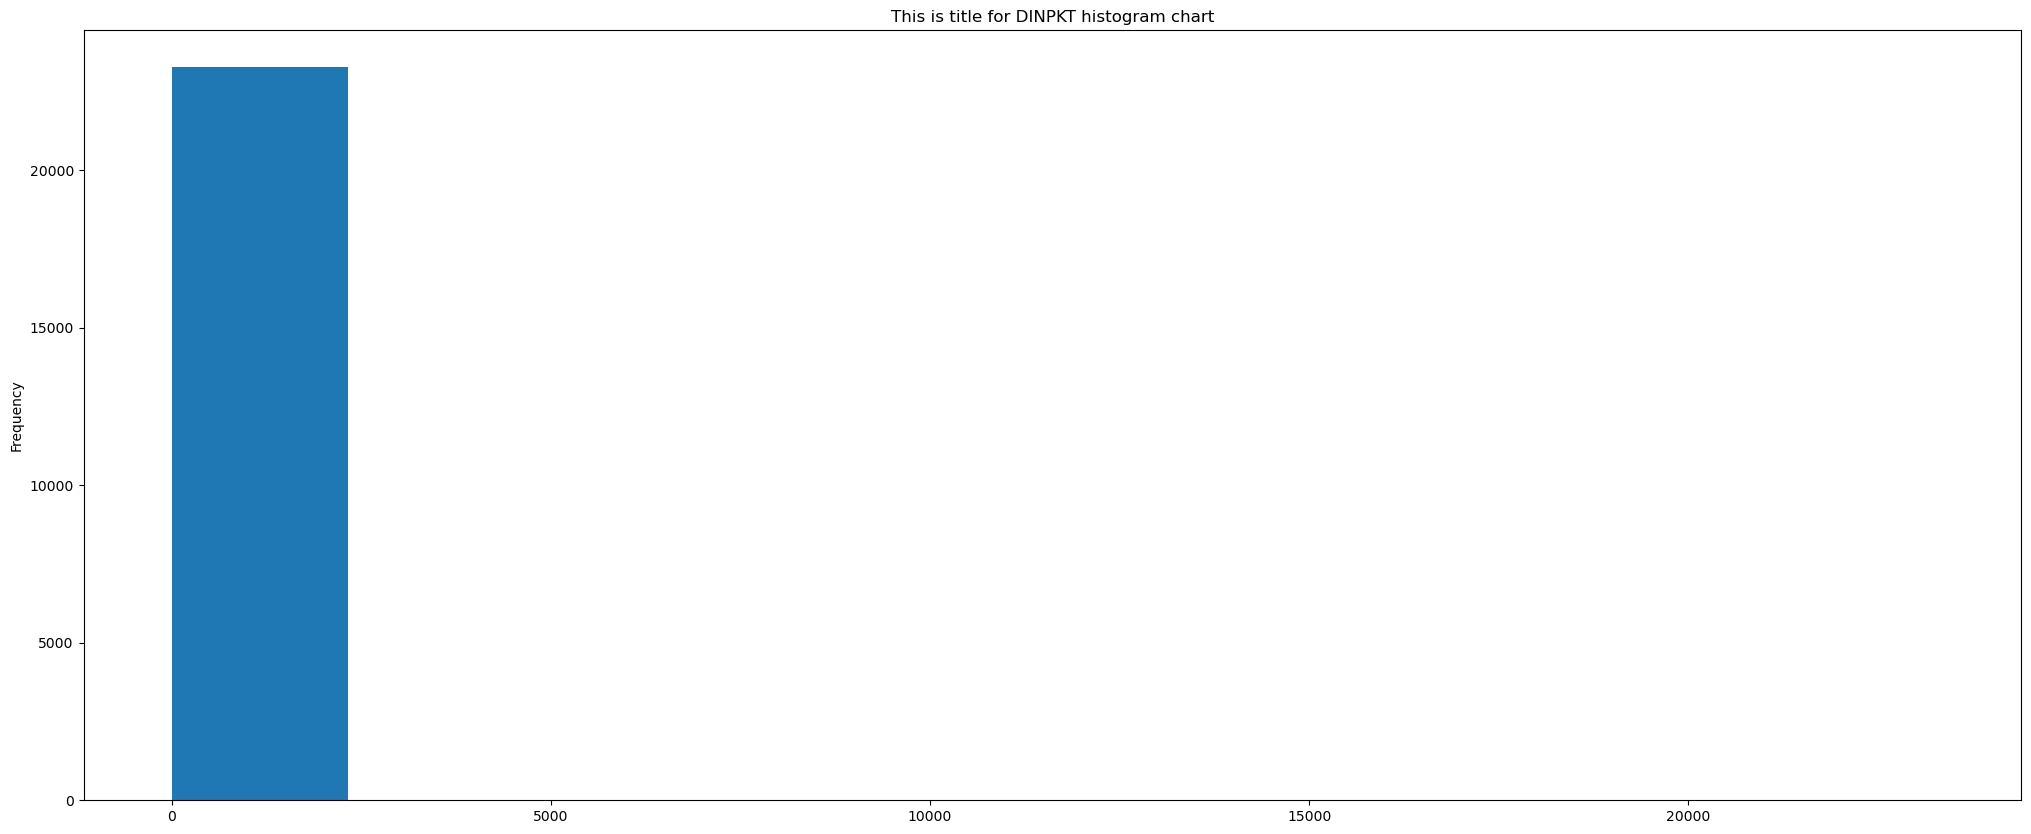

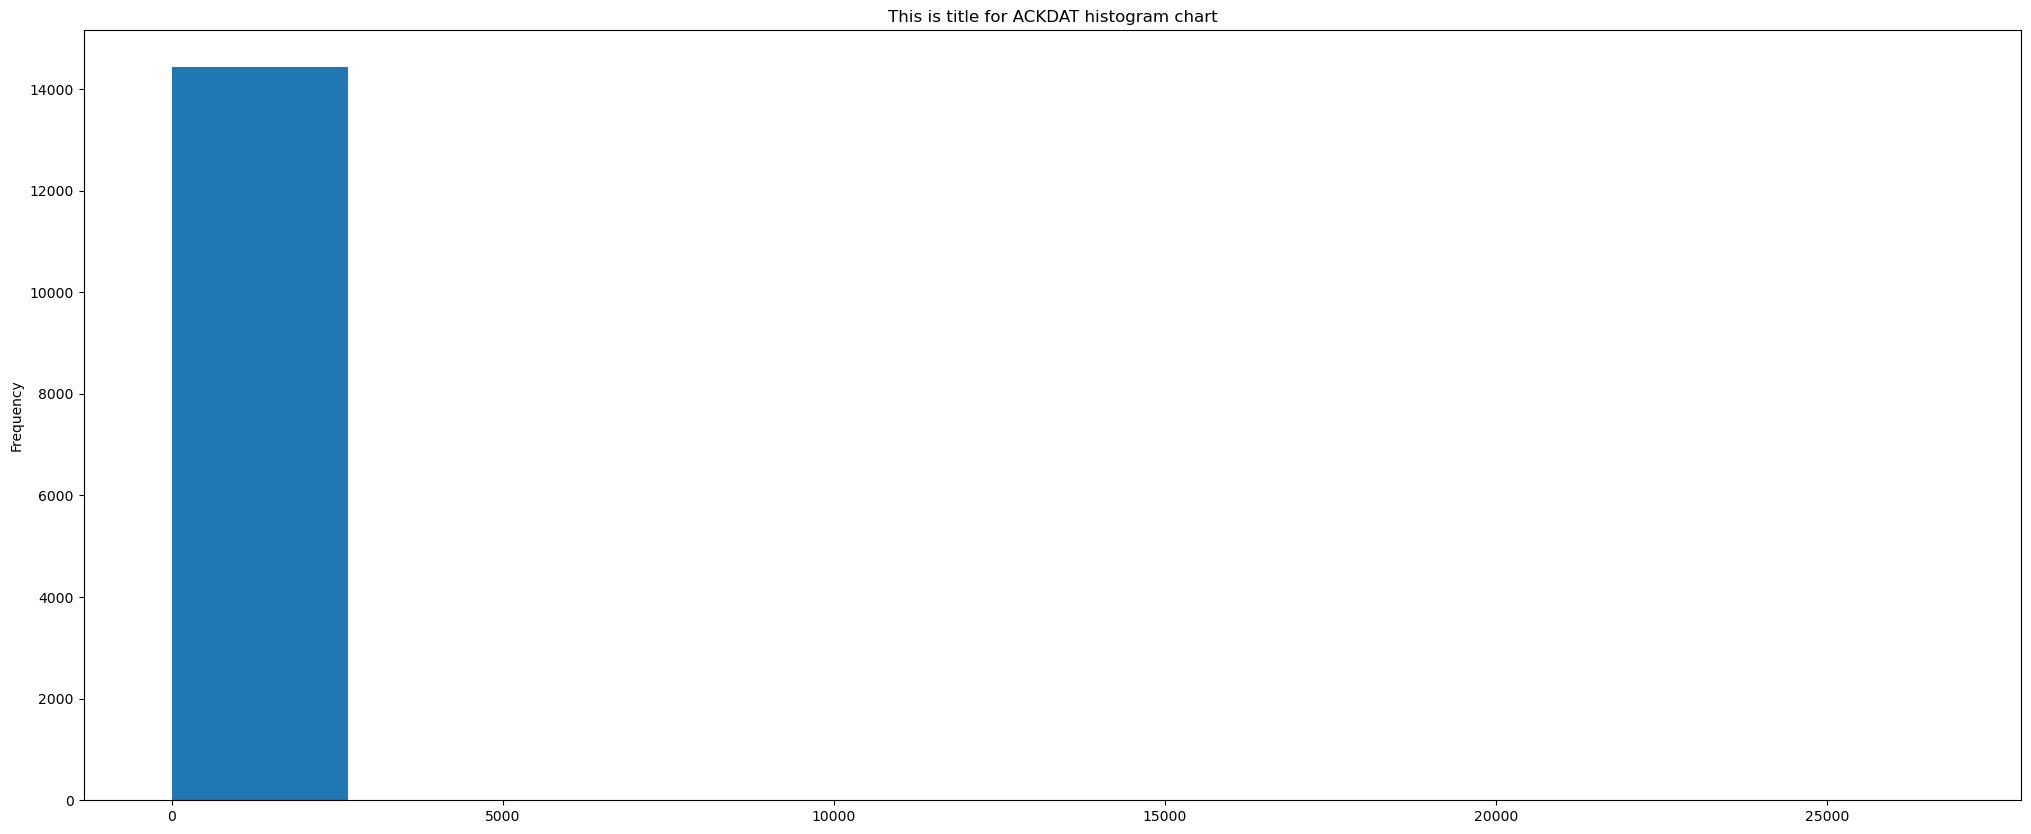

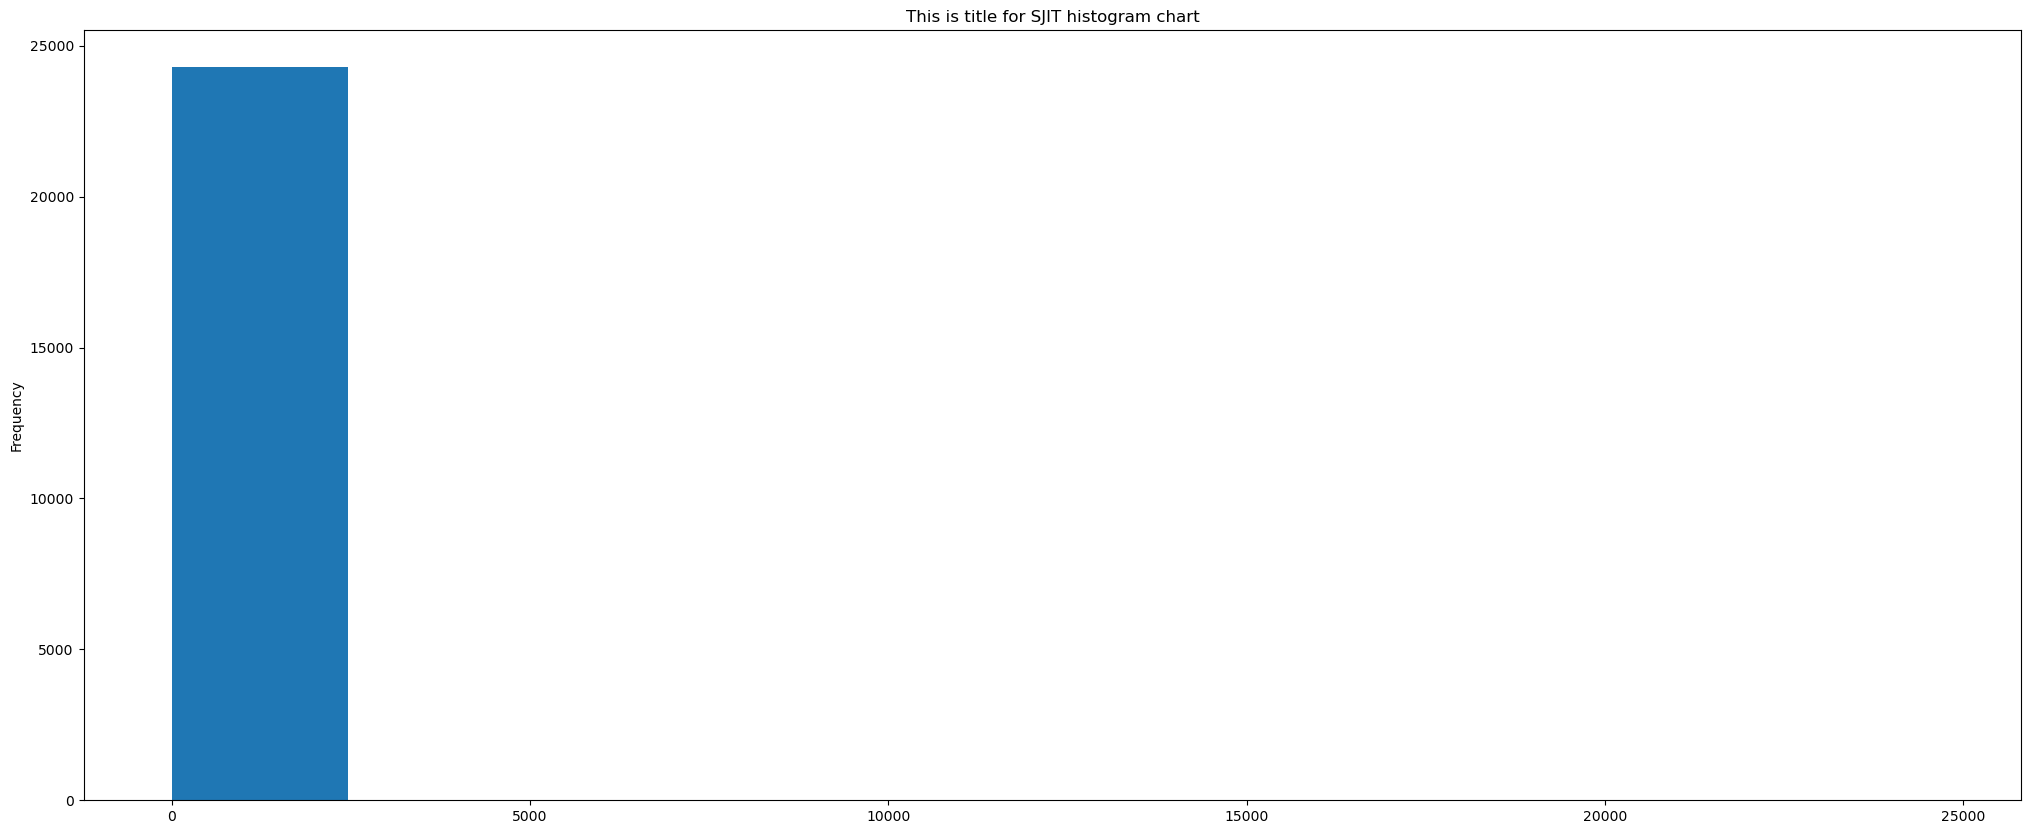

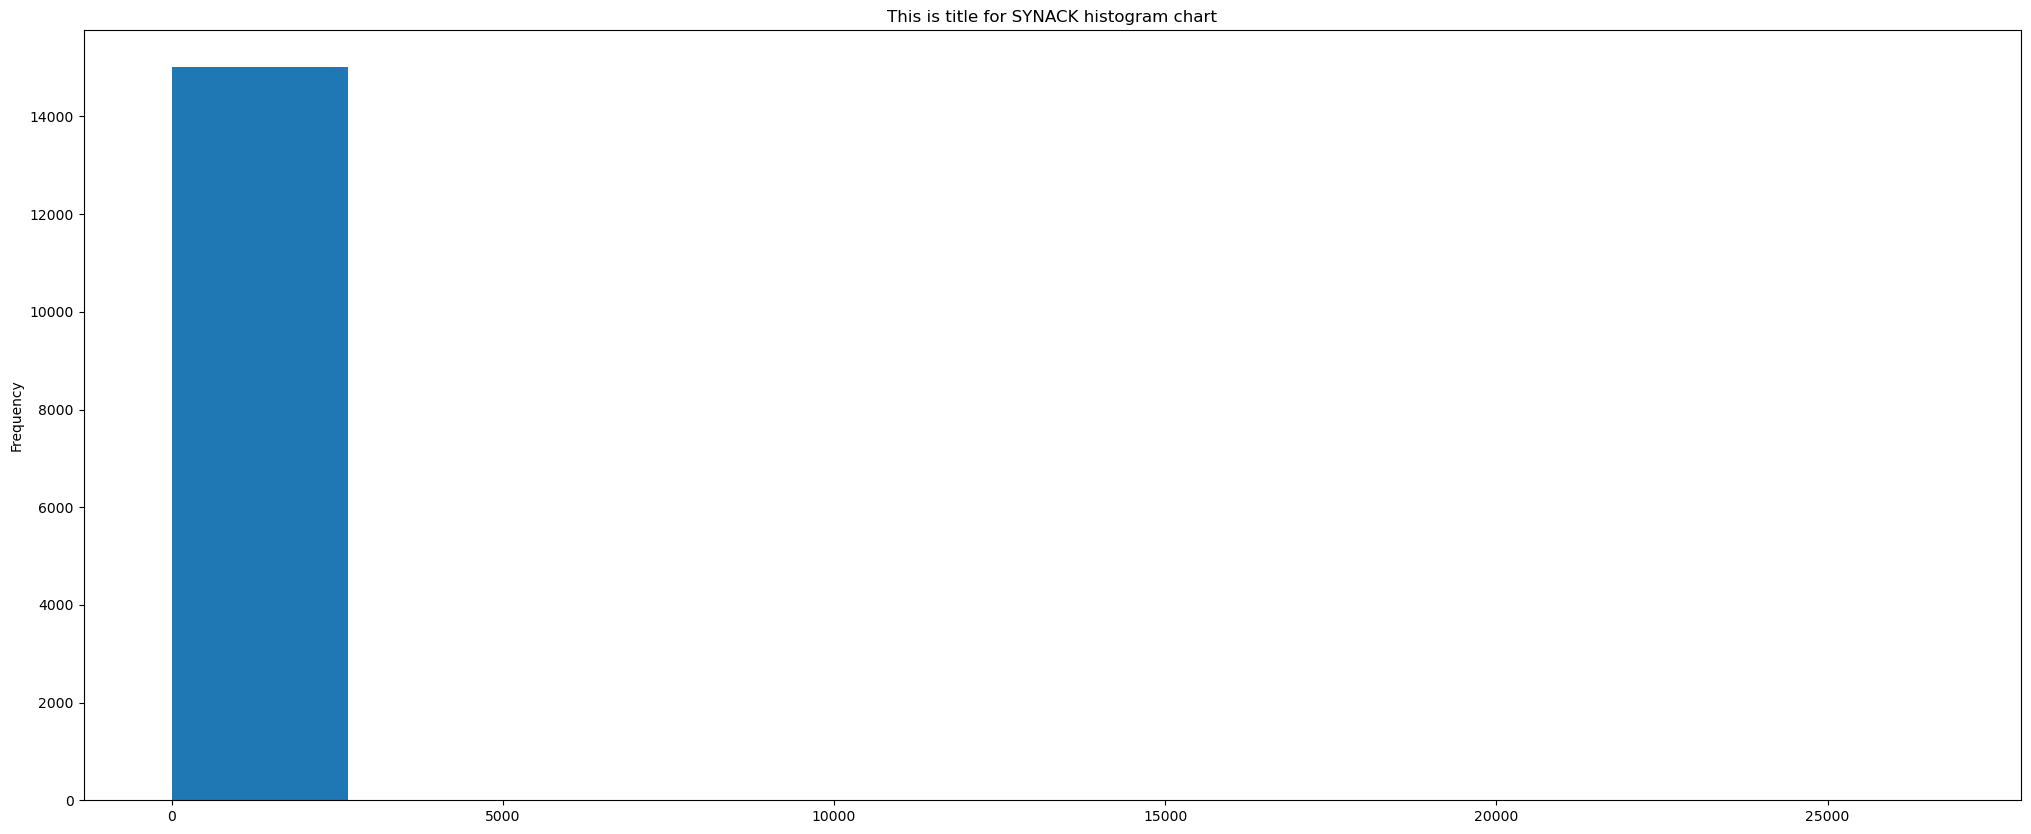

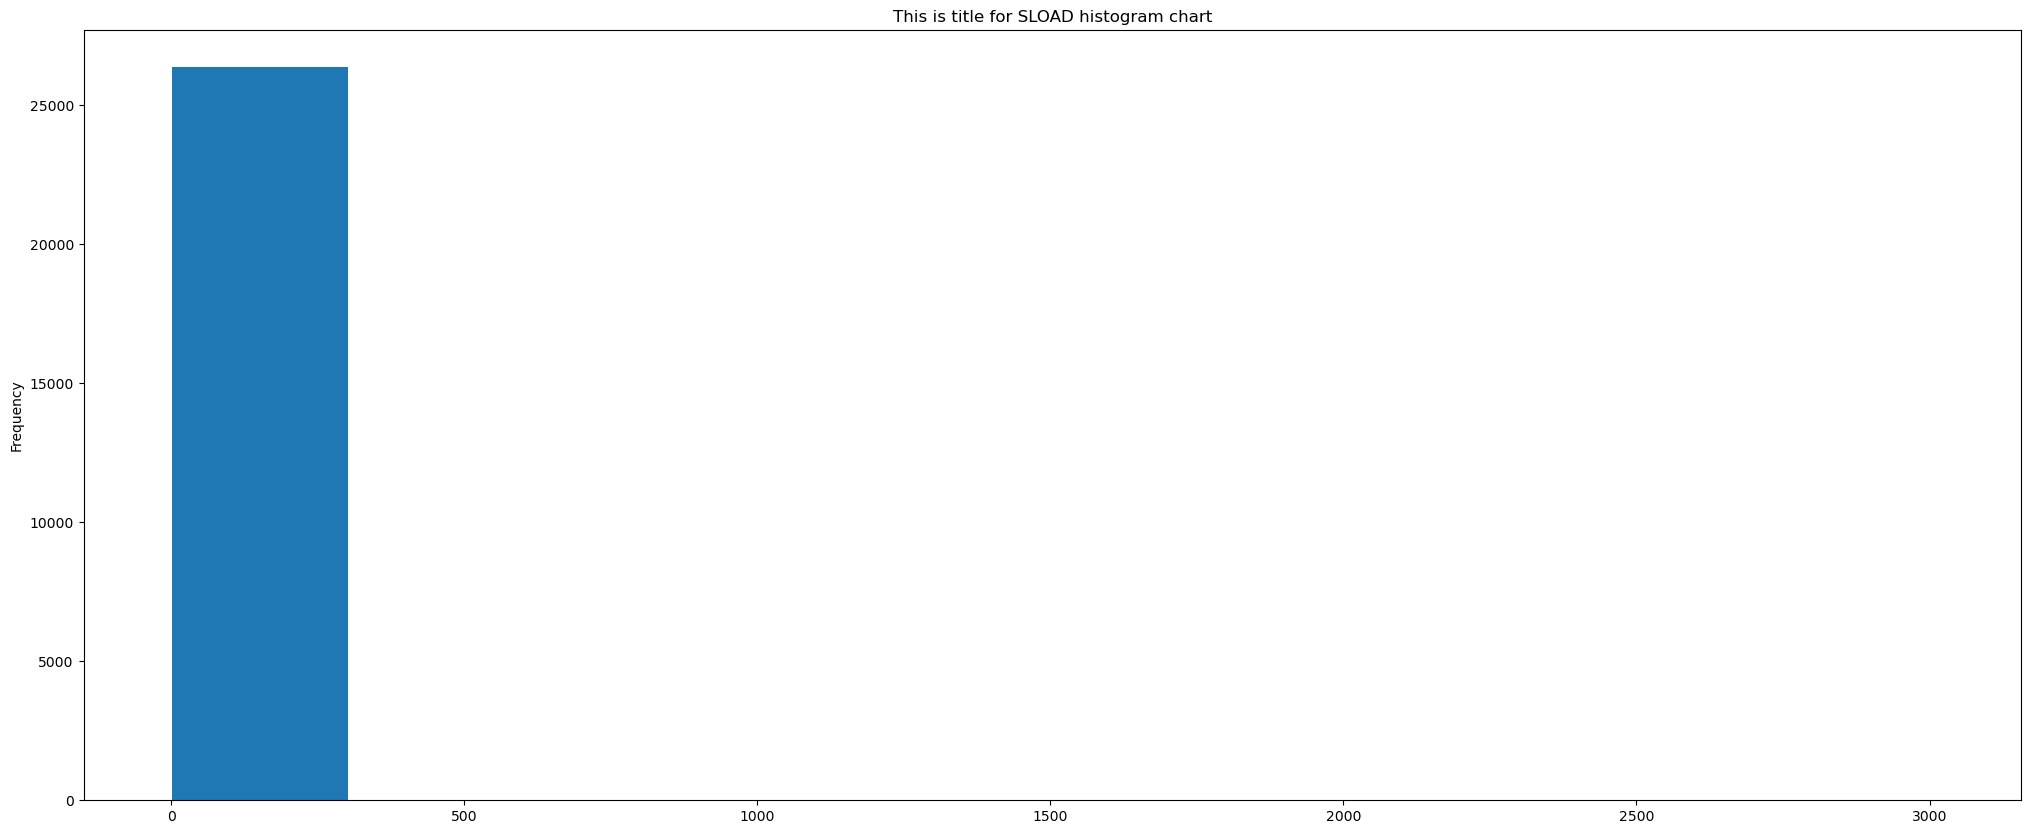

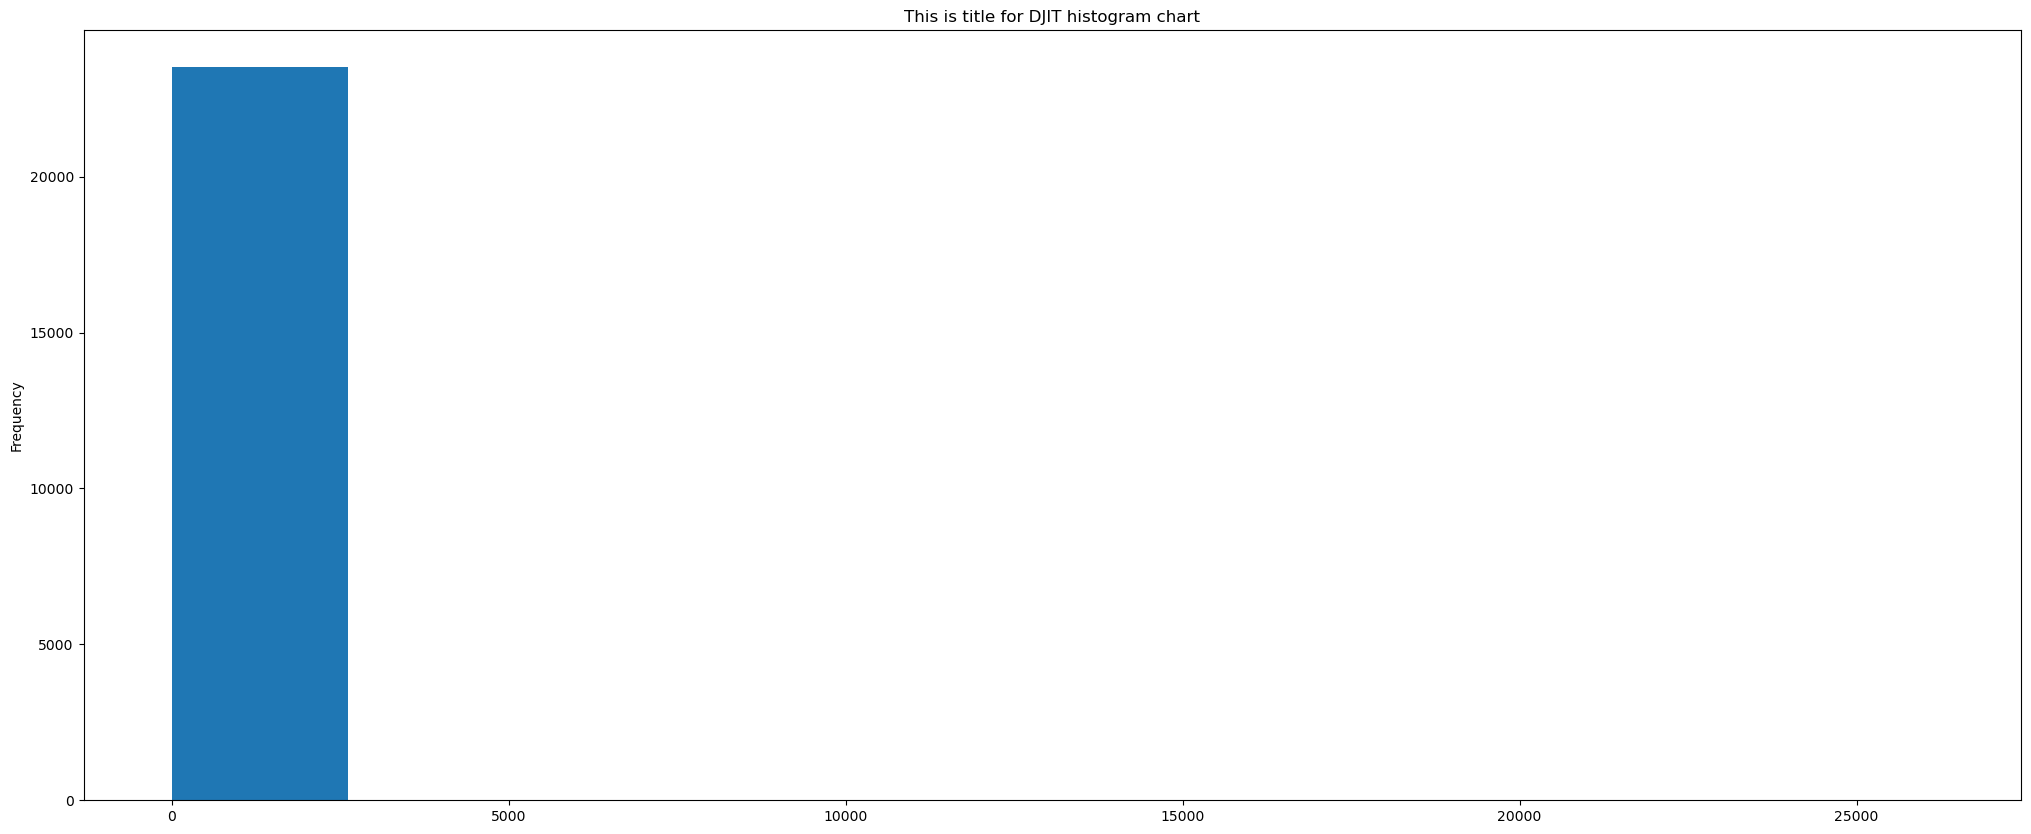

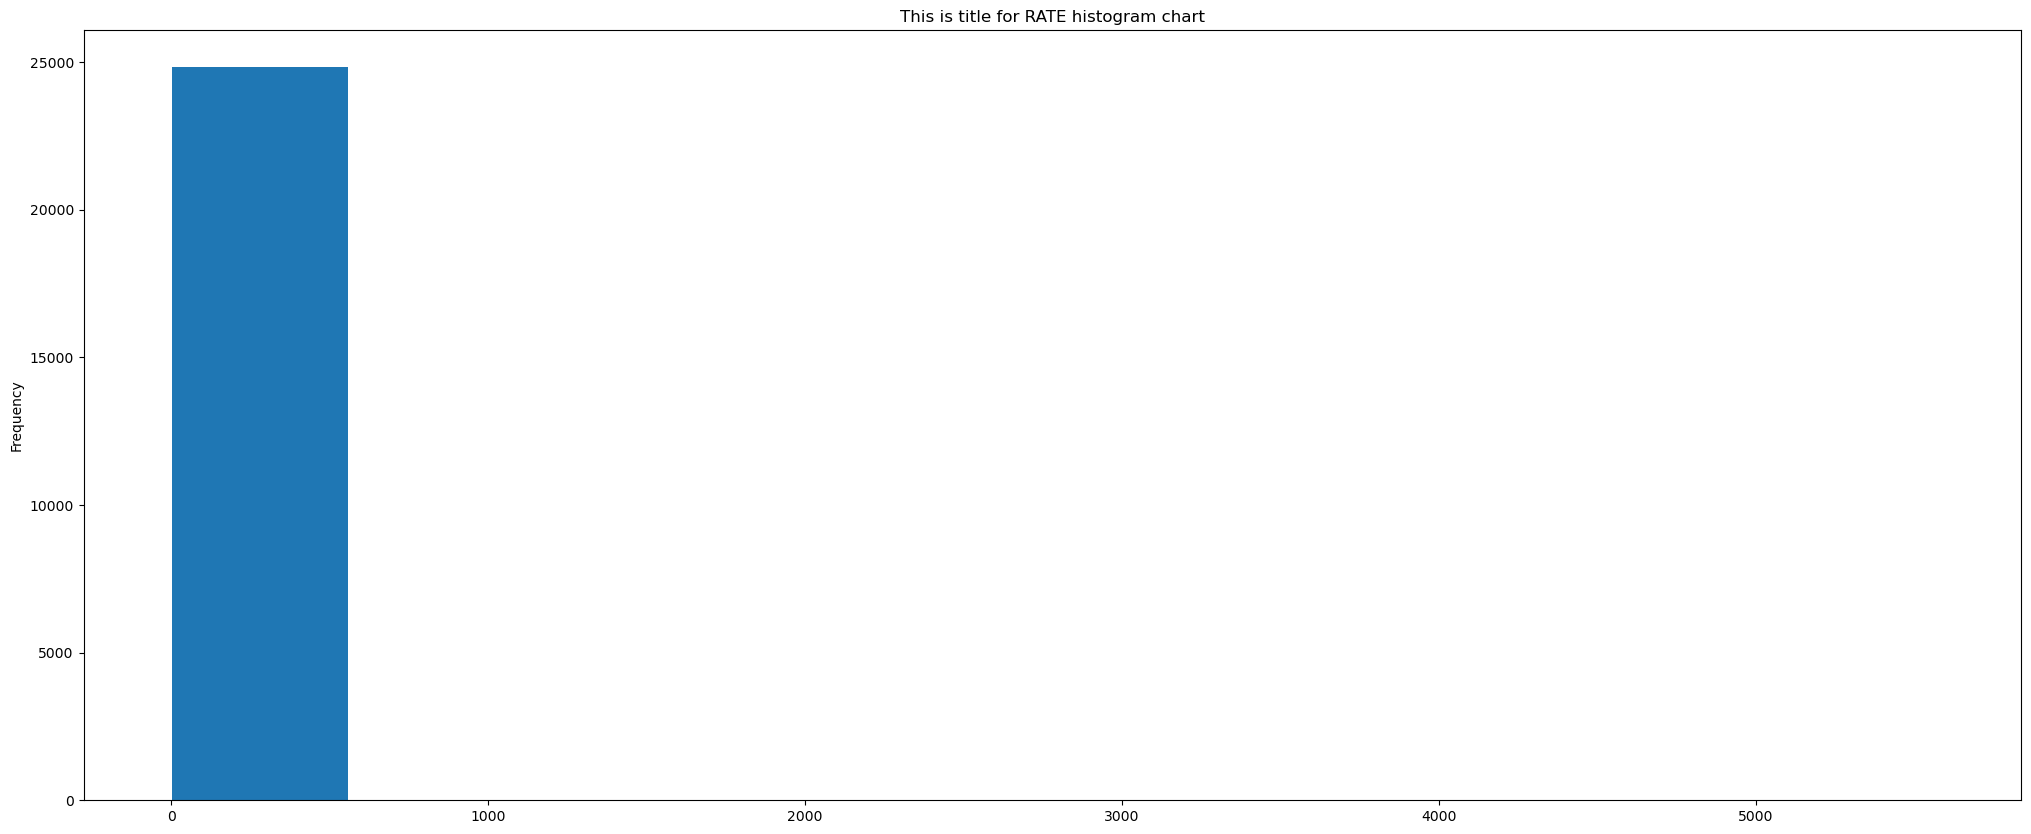

In [42]:
show_histogram_plots_for_all_continuous_plots(eda_unsw_nb15_df, eda_unsw_nb15_continuous_features)

#### Spliting and Standardizing Dataset for Experiment I

In [43]:
target_kdd_cup_df = kdd_cup_df[target_variable]
target_unsw_nb15_df = unsw_nb15_df[target_variable]

In [44]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)
features_unsw_nb15_df = unsw_nb15_df.drop([target_variable], axis=1)

In [45]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for protocol_type feature


Processing feature mapping for service feature


Processing feature mapping for flag feature




In [46]:
features_kdd_cup_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
1704492,0,0,0,0,1032,0,0,0,0,0,...,255,255,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.00
4203393,0,0,0,0,520,0,0,0,0,0,...,255,255,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.00
4178178,0,0,0,0,520,0,0,0,0,0,...,255,255,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.00
1376154,0,1,1,0,147,10388,0,0,0,0,...,37,255,1.0,0.0,0.03,0.08,0.0,0.01,0.0,0.01
2755980,0,0,0,0,1032,0,0,0,0,0,...,255,255,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.00


In [47]:
features_unsw_nb15_df = process_feature_mapping(features_unsw_nb15_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for proto feature


Processing feature mapping for service feature


Processing feature mapping for state feature




In [48]:
features_unsw_nb15_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
59545,59546,0.000010,0,0,0,2,0,114,0,100000.002500,...,7,7,3,7,0,0,0,7,10,0
2414,2415,0.179562,1,1,1,10,6,2416,268,83.536605,...,1,1,1,1,0,0,1,1,1,0
192911,110580,0.000000,2,1,0,1,0,46,0,0.000000,...,1,1,1,1,0,0,0,1,1,1
140477,58146,0.883534,1,2,1,50,24,41225,1950,82.622739,...,1,1,1,2,0,0,0,1,2,0
243867,161536,0.000009,0,0,0,2,0,114,0,111111.107200,...,33,33,16,33,0,0,0,34,33,0


In [49]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [50]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [51]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [52]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [53]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      64138
size       64138
Name: traffic_type, dtype: int64

32069

32069


In [54]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51028
size       51028
Name: traffic_type, dtype: int64

25514

25514


In [55]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment I

In [56]:
experiment_type = "EXPERIMENT-ONE"



ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.86      0.97      0.91      1705
      Attack       0.99      0.97      0.98      8295

    accuracy                           0.97     10000
   macro avg       0.93      0.97      0.95     10000
weighted avg       0.97      0.97      0.97     10000




CONFUSION MATRIX



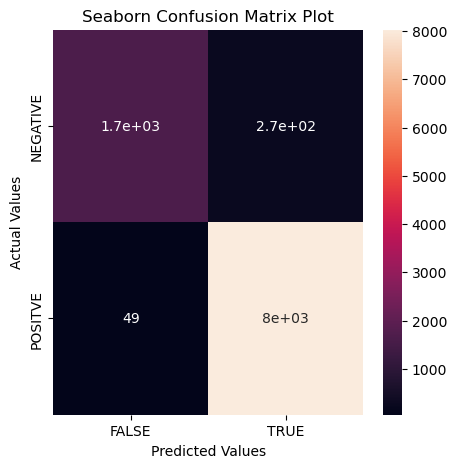




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9275
GEOMETRIC MEAN SCORE:  0.9252










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.77      0.70      0.73      3993
      Attack       0.81      0.86      0.83      6007

    accuracy                           0.79     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.79      0.79     10000




CONFUSION MATRIX



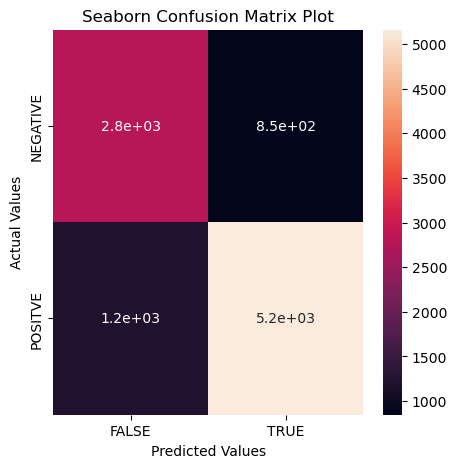




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.7889
GEOMETRIC MEAN SCORE:  0.7886










In [57]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      1938
      Attack       1.00      1.00      1.00      8062

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



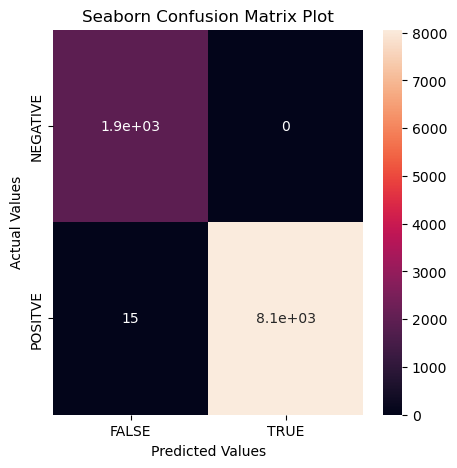




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9991
GEOMETRIC MEAN SCORE:  0.9991










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.93      0.85      0.89      3955
      Attack       0.91      0.96      0.93      6045

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000




CONFUSION MATRIX



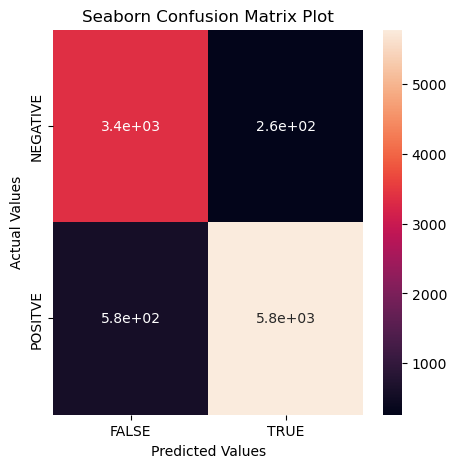




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9185
GEOMETRIC MEAN SCORE:  0.9185










In [58]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      1948
      Attack       1.00      1.00      1.00      8052

    accuracy                           1.00     10000
   macro avg       1.00      0.99      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



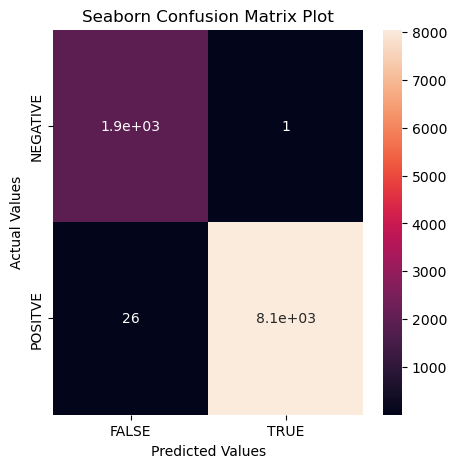




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9981
GEOMETRIC MEAN SCORE:  0.9981










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.96      0.71      0.81      4929
      Attack       0.77      0.97      0.86      5071

    accuracy                           0.84     10000
   macro avg       0.87      0.84      0.84     10000
weighted avg       0.87      0.84      0.84     10000




CONFUSION MATRIX



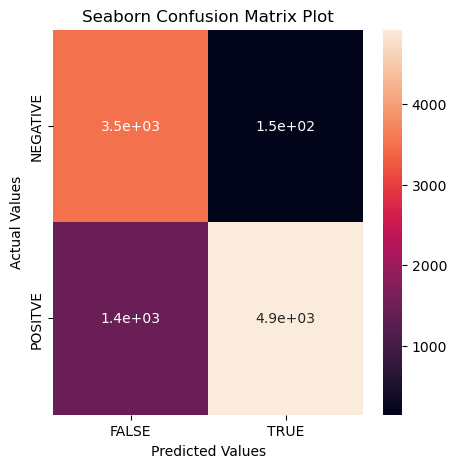




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8669
GEOMETRIC MEAN SCORE:  0.8619










In [59]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1926
      Attack       1.00      1.00      1.00      8074

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



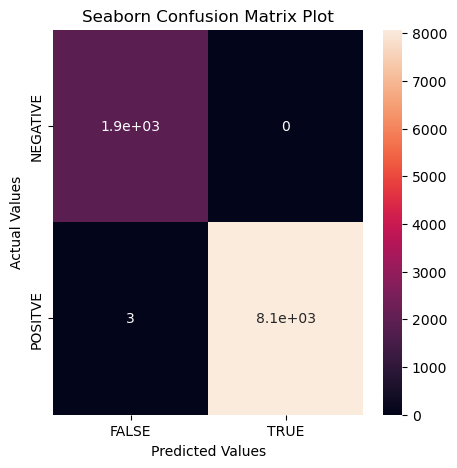




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9998
GEOMETRIC MEAN SCORE:  0.9998










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET


CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.85      0.97      0.91      3201
      Attack       0.98      0.92      0.95      6799

    accuracy                           0.94     10000
   macro avg       0.92      0.95      0.93     10000
weighted avg       0.94      0.94      0.94     10000




CONFUSION MATRIX



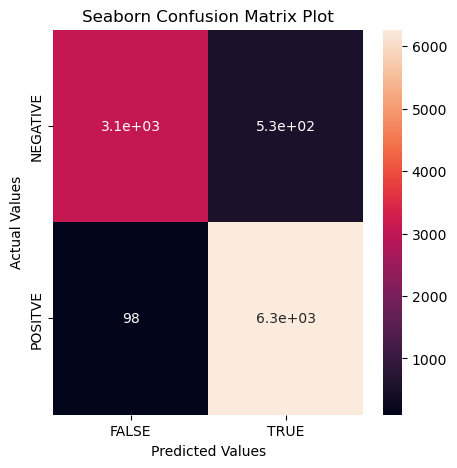




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9190
GEOMETRIC MEAN SCORE:  0.9167










In [60]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 1)                 42        
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
642/642 [==============================] - 2s 2ms/step - loss: 0.4047 - accuracy: 0.9026
Epoch 2/10
642/642 [==============================] - 1s 2ms/step - loss: 0.1967 - accuracy: 0.9971
Epoch 3/10
642/642 [==============================] - 1s 2ms/step - loss: 0.1242 - accuracy: 0.9978
Epoch 4/10
642/642

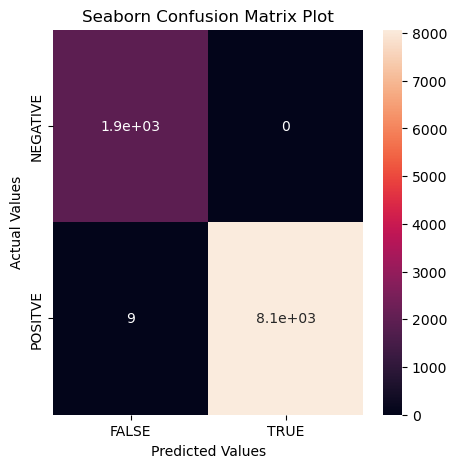




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9994
GEOMETRIC MEAN SCORE:  0.9994








Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1892      
                                                                 
 dense_4 (Dense)             (None, 1)                 44        
                                                                 
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
511/511 [==============================] - 2s 3ms/step - loss: 0.6042 - accuracy: 0.7533
Epoch 2/10
511/511 [==============================] - 2s 3ms/step - loss: 0.4518 - accuracy: 0.8738
Epoch 3/10
511/511 [======

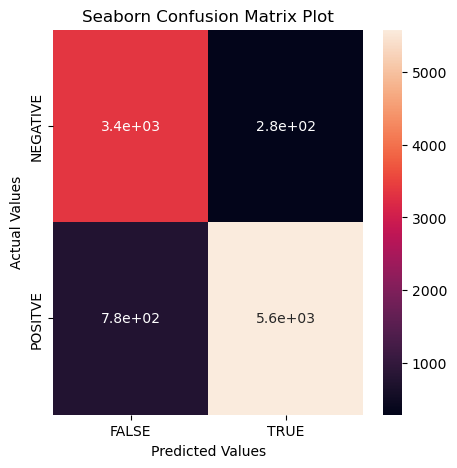




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9002
GEOMETRIC MEAN SCORE:  0.9000










In [73]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment One

In [74]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [76]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [77]:
KDD_Analysis_Summary_df

,AUC,G-MEAN
NBC,0.927544,0.925165
SVM,0.999071,0.999071
DTC,0.998130,0.998130
RFC,0.999814,0.999814
ANN,0.999443,0.999443


In [78]:
UNSWNB15_Analysis_Summary_df

,AUC,G-MEAN
NBC,0.788931,0.788628
SVM,0.918540,0.918489
DTC,0.866865,0.861864
RFC,0.919006,0.916662
ANN,0.900234,0.899953


### Experiment II Setup